In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PSIQUIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=154.3, y1=133.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 336
Page 1, Q1, A: Yellow percentage: 0.0%


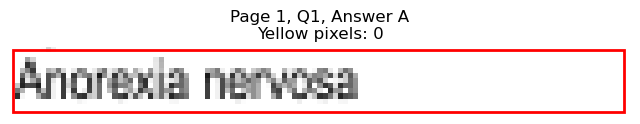

Page 1, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=117.0, y1=145.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 168
Page 1, Q1, B: Yellow percentage: 0.0%


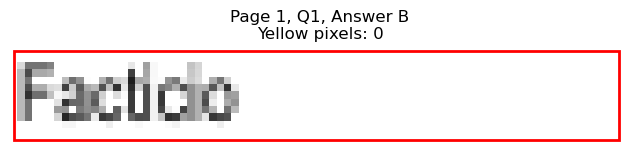

Page 1, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=124.2, y1=157.4
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 213
Page 1, Q1, C: Yellow percentage: 0.0%


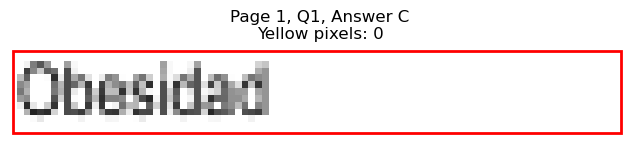

Page 1, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=378.3, y1=133.3
Page 1, Q1, D: Yellow pixels: 93
Page 1, Q1, D: Total non-white pixels: 307
Page 1, Q1, D: Yellow percentage: 30.3%


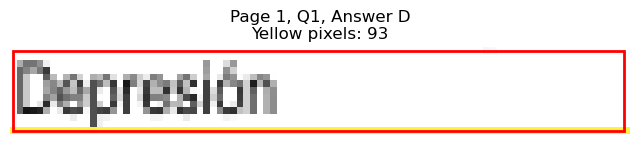

Page 1, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=390.3, y1=145.3
Page 1, Q1, E: Yellow pixels: 1028
Page 1, Q1, E: Total non-white pixels: 1365
Page 1, Q1, E: Yellow percentage: 75.3%


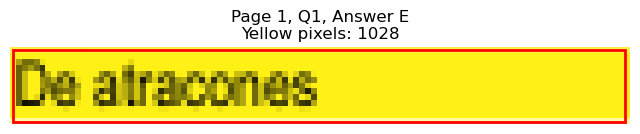


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=255.9, y1=193.5
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 890
Page 1, Q2, A: Yellow percentage: 0.0%


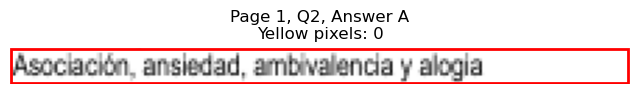

Page 1, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=235.4, y1=205.5
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 760
Page 1, Q2, B: Yellow percentage: 0.0%


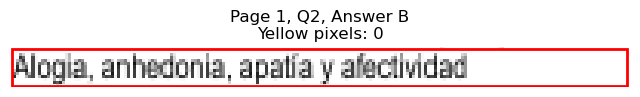

Page 1, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=269.3, y1=217.7
Page 1, Q2, C: Yellow pixels: 1727
Page 1, Q2, C: Total non-white pixels: 2483
Page 1, Q2, C: Yellow percentage: 69.6%


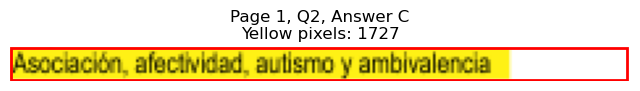

Page 1, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=503.7, y1=193.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 842
Page 1, Q2, D: Yellow percentage: 0.0%


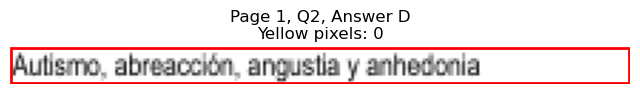

Page 1, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=499.9, y1=205.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 816
Page 1, Q2, E: Yellow percentage: 0.0%


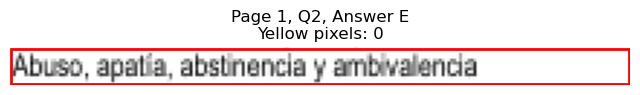


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=289.9, x1=145.3, y1=302.0
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 319
Page 1, Q3, A: Yellow percentage: 0.0%


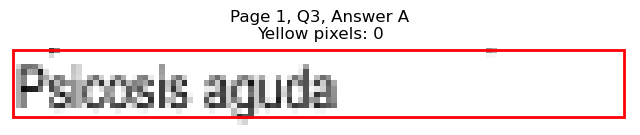

Page 1, Q3 - B: Detected box: x0=85.0, y0=301.9, x1=120.9, y1=314.0
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 214
Page 1, Q3, B: Yellow percentage: 0.0%


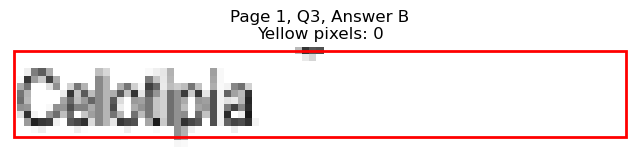

Page 1, Q3 - C: Detected box: x0=85.0, y0=313.9, x1=124.7, y1=326.0
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 203
Page 1, Q3, C: Yellow percentage: 0.0%


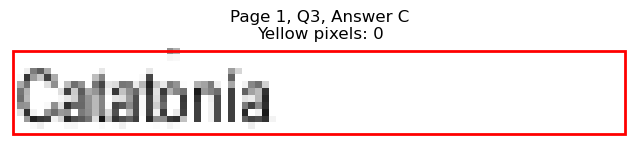

Page 1, Q3 - D: Detected box: x0=336.7, y0=289.9, x1=383.6, y1=302.0
Page 1, Q3, D: Yellow pixels: 982
Page 1, Q3, D: Total non-white pixels: 1274
Page 1, Q3, D: Yellow percentage: 77.1%


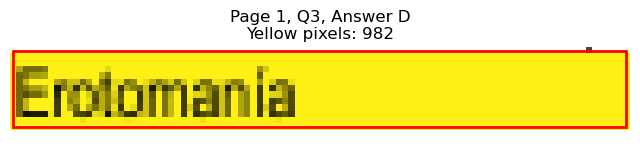

Page 1, Q3 - E: Detected box: x0=336.7, y0=301.9, x1=390.3, y1=314.0
Page 1, Q3, E: Yellow pixels: 105
Page 1, Q3, E: Total non-white pixels: 390
Page 1, Q3, E: Yellow percentage: 26.9%


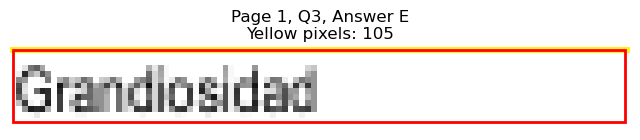


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=422.4, x1=167.8, y1=434.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 429
Page 1, Q4, A: Yellow percentage: 0.0%


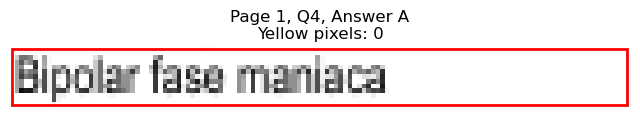

Page 1, Q4 - B: Detected box: x0=85.0, y0=434.4, x1=178.8, y1=446.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 490
Page 1, Q4, B: Yellow percentage: 0.0%


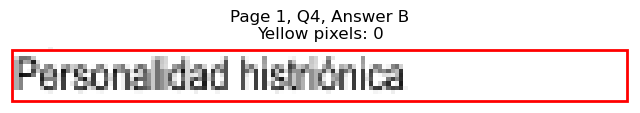

Page 1, Q4 - C: Detected box: x0=85.0, y0=446.6, x1=174.5, y1=458.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 483
Page 1, Q4, C: Yellow percentage: 0.0%


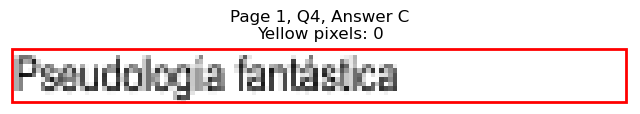

Page 1, Q4 - D: Detected box: x0=336.7, y0=422.4, x1=432.4, y1=434.5
Page 1, Q4, D: Yellow pixels: 147
Page 1, Q4, D: Total non-white pixels: 631
Page 1, Q4, D: Yellow percentage: 23.3%


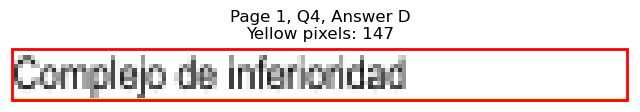

Page 1, Q4 - E: Detected box: x0=336.7, y0=434.4, x1=428.1, y1=446.5
Page 1, Q4, E: Yellow pixels: 1471
Page 1, Q4, E: Total non-white pixels: 1859
Page 1, Q4, E: Yellow percentage: 79.1%


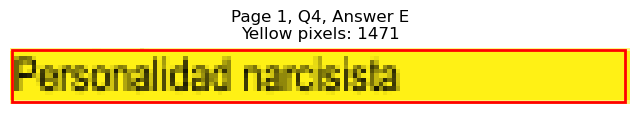


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=506.8, x1=117.0, y1=518.9
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 254
Page 1, Q5, A: Yellow percentage: 0.0%


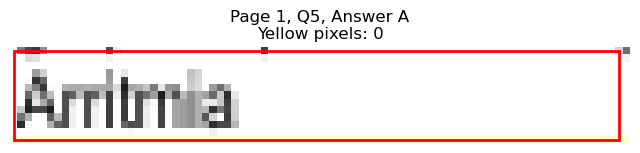

Page 1, Q5 - B: Detected box: x0=85.0, y0=518.8, x1=124.7, y1=530.9
Page 1, Q5, B: Yellow pixels: 928
Page 1, Q5, B: Total non-white pixels: 1183
Page 1, Q5, B: Yellow percentage: 78.4%


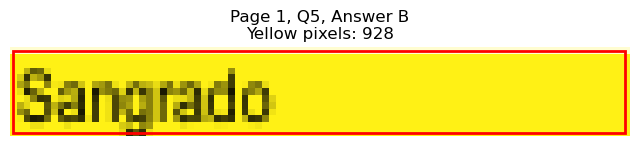

Page 1, Q5 - C: Detected box: x0=85.0, y0=530.9, x1=137.2, y1=543.0
Page 1, Q5, C: Yellow pixels: 101
Page 1, Q5, C: Total non-white pixels: 370
Page 1, Q5, C: Yellow percentage: 27.3%


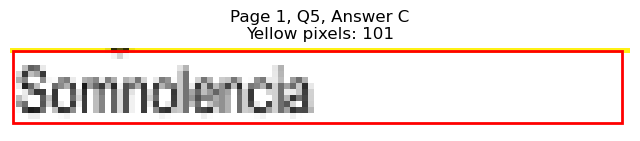

Page 1, Q5 - D: Detected box: x0=336.7, y0=506.8, x1=381.2, y1=518.9
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 265
Page 1, Q5, D: Yellow percentage: 0.0%


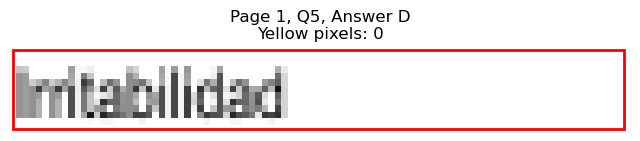

Page 1, Q5 - E: Detected box: x0=336.7, y0=518.8, x1=370.6, y1=530.9
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 169
Page 1, Q5, E: Yellow percentage: 0.0%


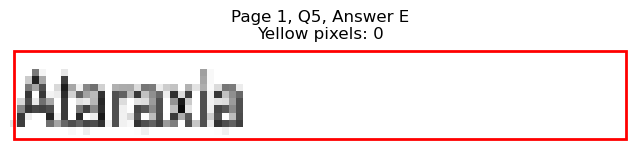


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=579.1, x1=227.7, y1=591.2
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 699
Page 1, Q6, A: Yellow percentage: 0.0%


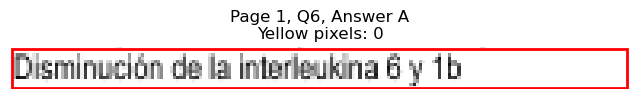

Page 1, Q6 - B: Detected box: x0=85.0, y0=591.2, x1=273.5, y1=603.3
Page 1, Q6, B: Yellow pixels: 36
Page 1, Q6, B: Total non-white pixels: 989
Page 1, Q6, B: Yellow percentage: 3.6%


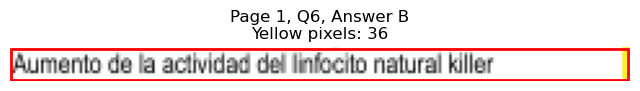

Page 1, Q6 - C: Detected box: x0=85.0, y0=603.2, x1=244.4, y1=615.3
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 773
Page 1, Q6, C: Yellow percentage: 0.0%


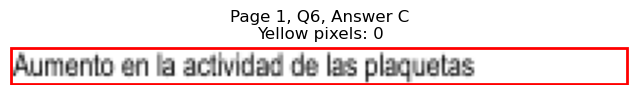

Page 1, Q6 - D: Detected box: x0=336.7, y0=579.1, x1=526.9, y1=591.2
Page 1, Q6, D: Yellow pixels: 1520
Page 1, Q6, D: Total non-white pixels: 2470
Page 1, Q6, D: Yellow percentage: 61.5%


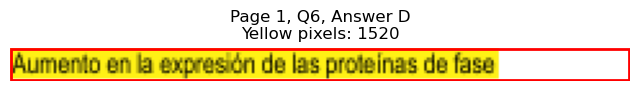

Page 1, Q6 - E: Detected box: x0=336.7, y0=603.2, x1=501.9, y1=615.3
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 1039
Page 1, Q6, E: Yellow percentage: 0.0%


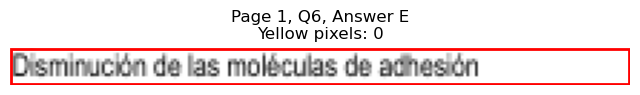


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=639.3, x1=132.4, y1=651.4
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 244
Page 1, Q7, A: Yellow percentage: 0.0%


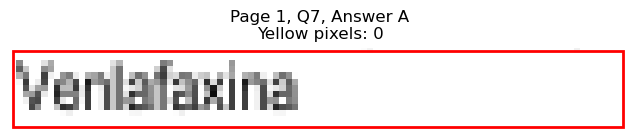

Page 1, Q7 - B: Detected box: x0=85.0, y0=651.4, x1=127.1, y1=663.5
Page 1, Q7, B: Yellow pixels: 94
Page 1, Q7, B: Total non-white pixels: 322
Page 1, Q7, B: Yellow percentage: 29.2%


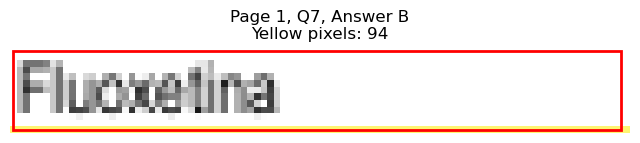

Page 1, Q7 - C: Detected box: x0=85.0, y0=663.4, x1=128.1, y1=675.5
Page 1, Q7, C: Yellow pixels: 1032
Page 1, Q7, C: Total non-white pixels: 1235
Page 1, Q7, C: Yellow percentage: 83.6%


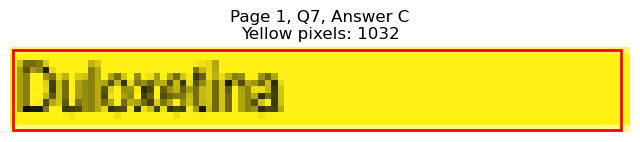

Page 1, Q7 - D: Detected box: x0=336.7, y0=639.3, x1=387.4, y1=651.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 263
Page 1, Q7, D: Yellow percentage: 0.0%


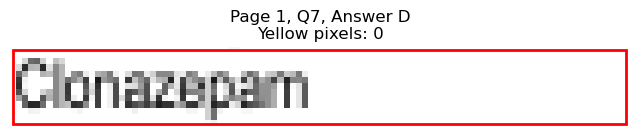

Page 1, Q7 - E: Detected box: x0=336.7, y0=651.4, x1=390.3, y1=663.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 284
Page 1, Q7, E: Yellow percentage: 0.0%


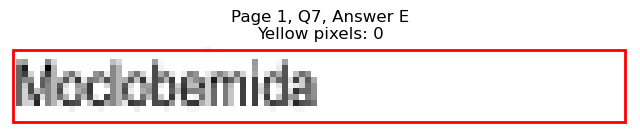


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=711.7, x1=127.1, y1=723.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 232
Page 1, Q8, A: Yellow percentage: 0.0%


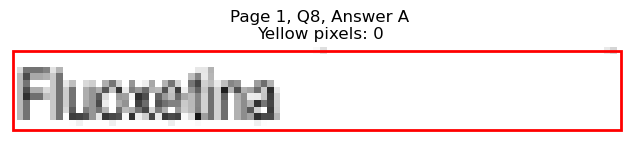

Page 1, Q8 - B: Detected box: x0=85.0, y0=723.7, x1=128.1, y1=735.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 239
Page 1, Q8, B: Yellow percentage: 0.0%


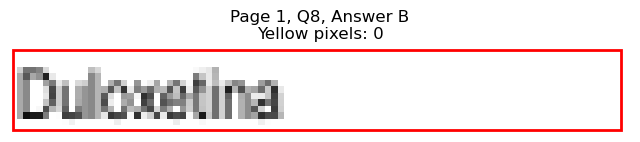

Page 1, Q8 - C: Detected box: x0=85.0, y0=735.8, x1=131.9, y1=747.9
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 268
Page 1, Q8, C: Yellow percentage: 0.0%


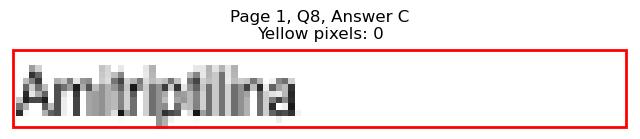

Page 1, Q8 - D: Detected box: x0=336.7, y0=711.7, x1=384.1, y1=723.8
Page 1, Q8, D: Yellow pixels: 967
Page 1, Q8, D: Total non-white pixels: 1287
Page 1, Q8, D: Yellow percentage: 75.1%


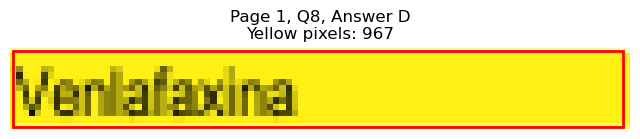

Page 1, Q8 - E: Detected box: x0=336.7, y0=723.7, x1=381.3, y1=735.8
Page 1, Q8, E: Yellow pixels: 96
Page 1, Q8, E: Total non-white pixels: 358
Page 1, Q8, E: Yellow percentage: 26.8%


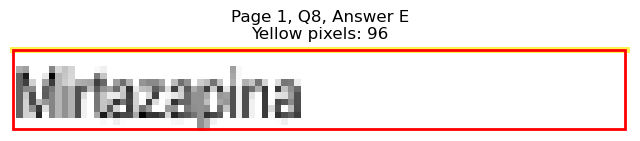


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=127.1, y1=157.4
Page 2, Q1, A: Yellow pixels: 94
Page 2, Q1, A: Total non-white pixels: 329
Page 2, Q1, A: Yellow percentage: 28.6%


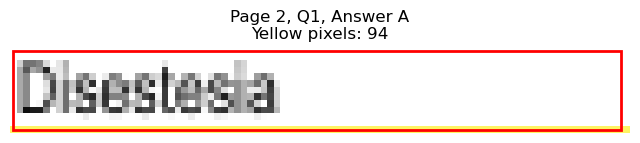

Page 2, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=118.9, y1=169.4
Page 2, Q1, B: Yellow pixels: 957
Page 2, Q1, B: Total non-white pixels: 1105
Page 2, Q1, B: Yellow percentage: 86.6%


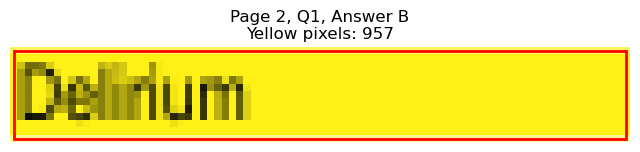

Page 2, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=131.4, y1=181.5
Page 2, Q1, C: Yellow pixels: 98
Page 2, Q1, C: Total non-white pixels: 334
Page 2, Q1, C: Yellow percentage: 29.3%


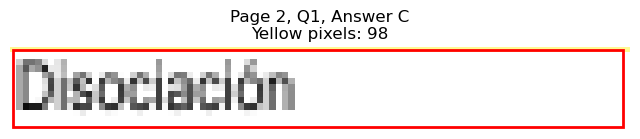

Page 2, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=378.3, y1=157.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 213
Page 2, Q1, D: Yellow percentage: 0.0%


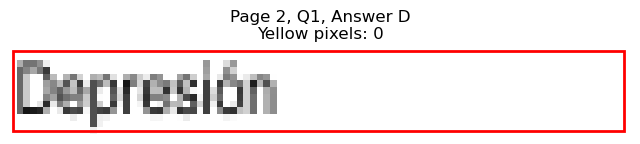

Page 2, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=378.0, y1=169.4
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 211
Page 2, Q1, E: Yellow percentage: 0.0%


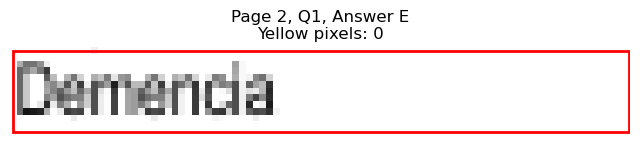


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=241.7, x1=160.1, y1=253.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 391
Page 2, Q2, A: Yellow percentage: 0.0%


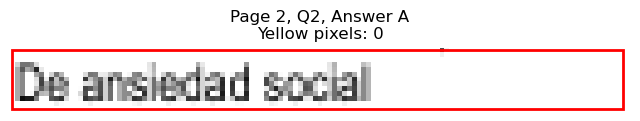

Page 2, Q2 - B: Detected box: x0=85.0, y0=253.7, x1=139.7, y1=265.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 283
Page 2, Q2, B: Yellow percentage: 0.0%


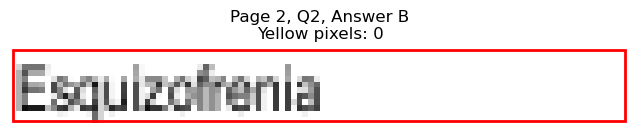

Page 2, Q2 - C: Detected box: x0=85.0, y0=265.8, x1=118.5, y1=277.9
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 160
Page 2, Q2, C: Yellow percentage: 0.0%


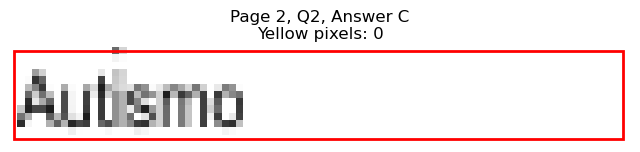

Page 2, Q2 - D: Detected box: x0=336.7, y0=241.7, x1=420.4, y1=253.8
Page 2, Q2, D: Yellow pixels: 1296
Page 2, Q2, D: Total non-white pixels: 1755
Page 2, Q2, D: Yellow percentage: 73.8%


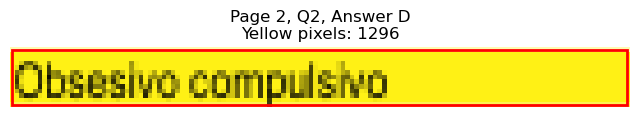

Page 2, Q2 - E: Detected box: x0=336.7, y0=253.7, x1=380.7, y1=265.8
Page 2, Q2, E: Yellow pixels: 94
Page 2, Q2, E: Total non-white pixels: 334
Page 2, Q2, E: Yellow percentage: 28.1%


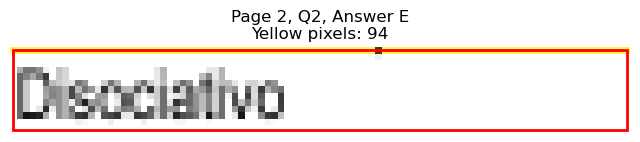


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=301.9, x1=131.4, y1=314.0
Page 2, Q3, A: Yellow pixels: 984
Page 2, Q3, A: Total non-white pixels: 1275
Page 2, Q3, A: Yellow percentage: 77.2%


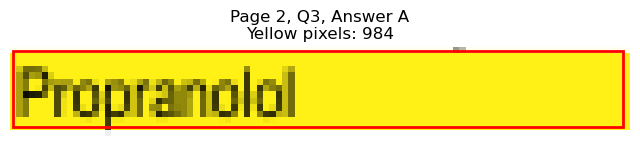

Page 2, Q3 - B: Detected box: x0=85.0, y0=313.9, x1=128.5, y1=326.0
Page 2, Q3, B: Yellow pixels: 94
Page 2, Q3, B: Total non-white pixels: 331
Page 2, Q3, B: Yellow percentage: 28.4%


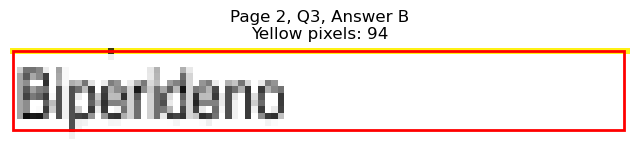

Page 2, Q3 - C: Detected box: x0=85.0, y0=326.1, x1=130.9, y1=338.2
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 217
Page 2, Q3, C: Yellow percentage: 0.0%


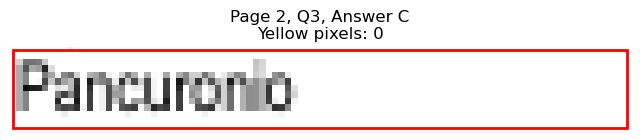

Page 2, Q3 - D: Detected box: x0=336.7, y0=301.9, x1=369.7, y1=314.0
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 165
Page 2, Q3, D: Yellow percentage: 0.0%


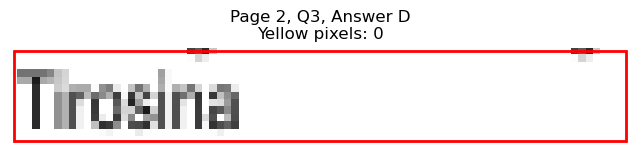

Page 2, Q3 - E: Detected box: x0=336.7, y0=313.9, x1=387.4, y1=326.0
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 261
Page 2, Q3, E: Yellow percentage: 0.0%


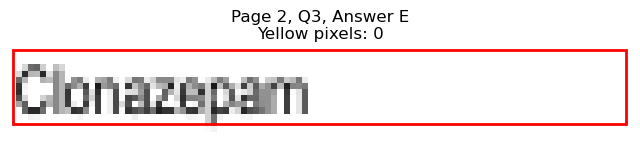


Page 2, Q3 - Selected Answer: A (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=156.3, y1=386.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 363
Page 2, Q4, A: Yellow percentage: 0.0%


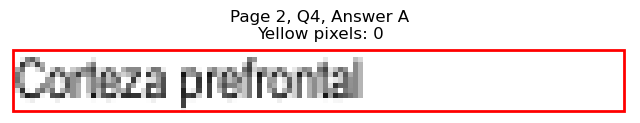

Page 2, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=160.6, y1=398.4
Page 2, Q4, B: Yellow pixels: 127
Page 2, Q4, B: Total non-white pixels: 511
Page 2, Q4, B: Yellow percentage: 24.9%


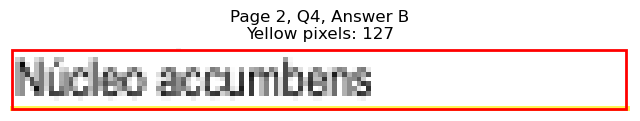

Page 2, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=123.7, y1=410.4
Page 2, Q4, C: Yellow pixels: 999
Page 2, Q4, C: Total non-white pixels: 1170
Page 2, Q4, C: Yellow percentage: 85.4%


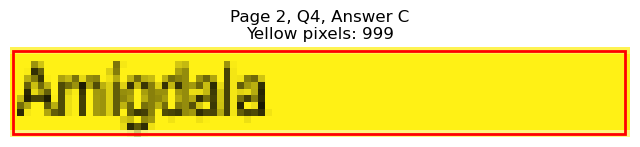

Page 2, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=382.6, y1=386.3
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 240
Page 2, Q4, D: Yellow percentage: 0.0%


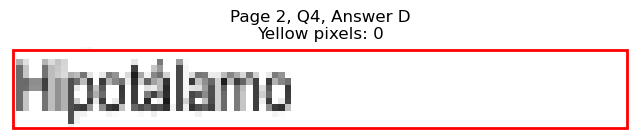

Page 2, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=394.6, y1=398.4
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 292
Page 2, Q4, E: Yellow percentage: 0.0%


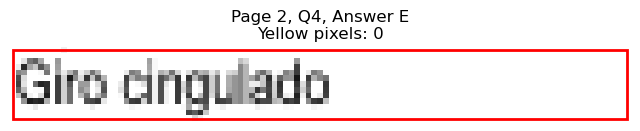


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=446.6, x1=171.6, y1=458.7
Page 2, Q5, A: Yellow pixels: 138
Page 2, Q5, A: Total non-white pixels: 581
Page 2, Q5, A: Yellow percentage: 23.8%


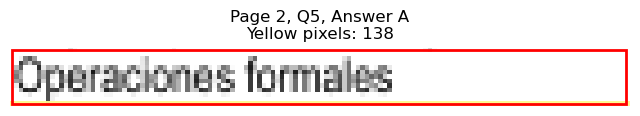

Page 2, Q5 - B: Detected box: x0=85.0, y0=458.6, x1=175.9, y1=470.7
Page 2, Q5, B: Yellow pixels: 1476
Page 2, Q5, B: Total non-white pixels: 1846
Page 2, Q5, B: Yellow percentage: 80.0%


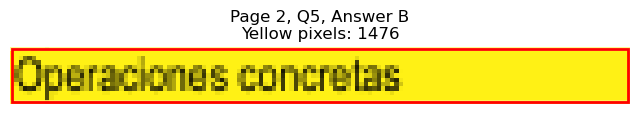

Page 2, Q5 - C: Detected box: x0=85.0, y0=470.7, x1=145.8, y1=482.8
Page 2, Q5, C: Yellow pixels: 112
Page 2, Q5, C: Total non-white pixels: 397
Page 2, Q5, C: Yellow percentage: 28.2%


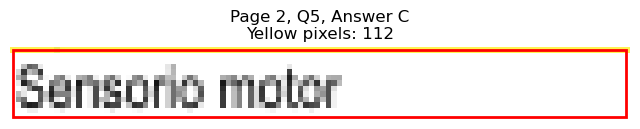

Page 2, Q5 - D: Detected box: x0=336.7, y0=446.6, x1=397.0, y1=458.7
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 307
Page 2, Q5, D: Yellow percentage: 0.0%


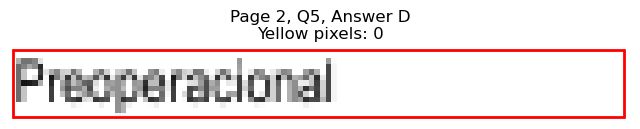

Page 2, Q5 - E: Detected box: x0=336.7, y0=458.6, x1=398.5, y1=470.7
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 298
Page 2, Q5, E: Yellow percentage: 0.0%


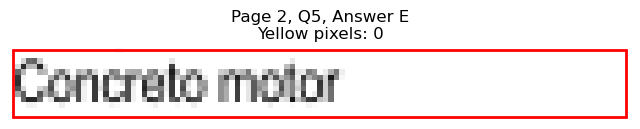


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=506.8, x1=148.2, y1=518.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 351
Page 2, Q6, A: Yellow percentage: 0.0%


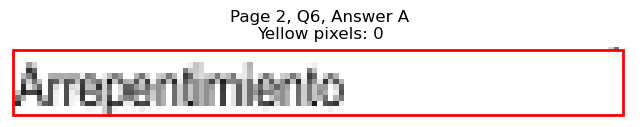

Page 2, Q6 - B: Detected box: x0=85.0, y0=518.8, x1=97.5, y1=530.9
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 57
Page 2, Q6, B: Yellow percentage: 0.0%


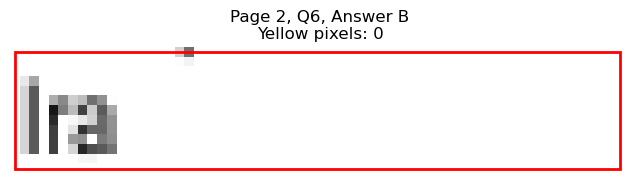

Page 2, Q6 - C: Detected box: x0=85.0, y0=530.9, x1=130.0, y1=543.0
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 237
Page 2, Q6, C: Yellow percentage: 0.0%


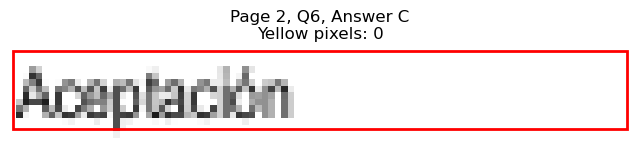

Page 2, Q6 - D: Detected box: x0=336.7, y0=506.8, x1=378.8, y1=518.9
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 329
Page 2, Q6, D: Yellow percentage: 0.0%


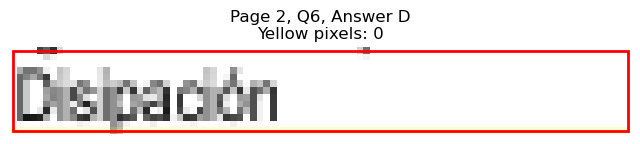

Page 2, Q6 - E: Detected box: x0=336.7, y0=518.8, x1=375.4, y1=530.9
Page 2, Q6, E: Yellow pixels: 906
Page 2, Q6, E: Total non-white pixels: 1170
Page 2, Q6, E: Yellow percentage: 77.4%


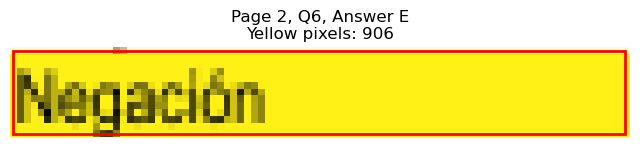


Page 2, Q6 - Selected Answer: E (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=175.9, y1=603.3
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 485
Page 2, Q7, A: Yellow percentage: 0.0%


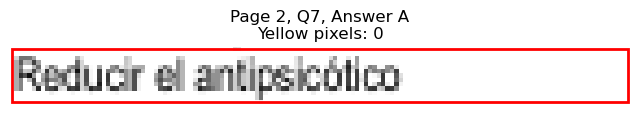

Page 2, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=158.7, y1=615.3
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 352
Page 2, Q7, B: Yellow percentage: 0.0%


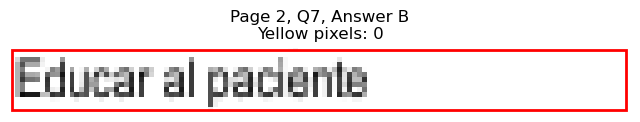

Page 2, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=206.6, y1=627.3
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 628
Page 2, Q7, C: Yellow percentage: 0.0%


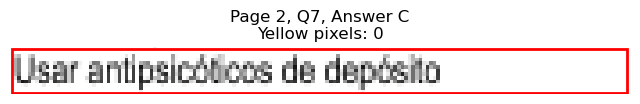

Page 2, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=422.4, y1=603.3
Page 2, Q7, D: Yellow pixels: 1275
Page 2, Q7, D: Total non-white pixels: 1781
Page 2, Q7, D: Yellow percentage: 71.6%


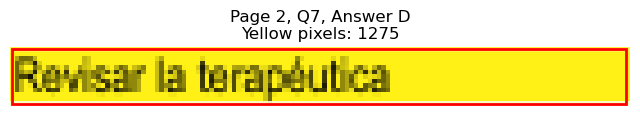

Page 2, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=440.1, y1=615.3
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 682
Page 2, Q7, E: Yellow percentage: 0.0%


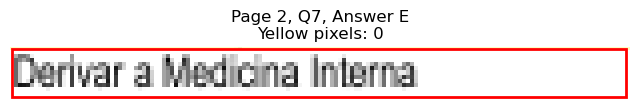


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=687.5, x1=113.2, y1=699.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 132
Page 2, Q8, A: Yellow percentage: 0.0%


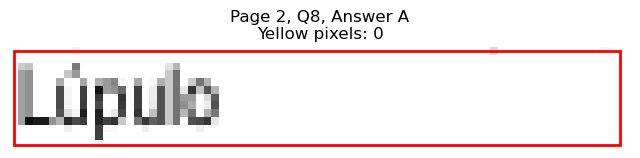

Page 2, Q8 - B: Detected box: x0=85.0, y0=699.5, x1=112.2, y1=711.7
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 160
Page 2, Q8, B: Yellow percentage: 0.0%


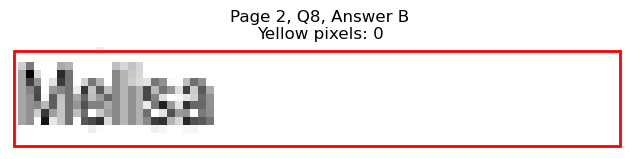

Page 2, Q8 - C: Detected box: x0=85.0, y0=711.7, x1=119.4, y1=723.8
Page 2, Q8, C: Yellow pixels: 893
Page 2, Q8, C: Total non-white pixels: 1118
Page 2, Q8, C: Yellow percentage: 79.9%


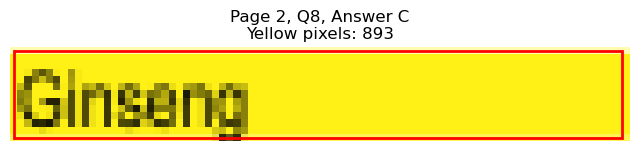

Page 2, Q8 - D: Detected box: x0=336.7, y0=687.5, x1=375.4, y1=699.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 201
Page 2, Q8, D: Yellow percentage: 0.0%


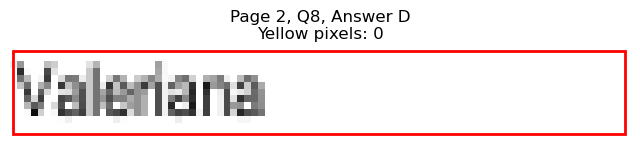

Page 2, Q8 - E: Detected box: x0=336.7, y0=699.5, x1=378.0, y1=711.7
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 231
Page 2, Q8, E: Yellow percentage: 0.0%


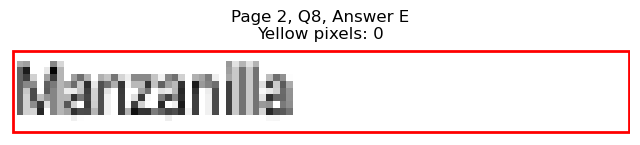


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=168.3, y1=157.4
Page 3, Q1, A: Yellow pixels: 1272
Page 3, Q1, A: Total non-white pixels: 1755
Page 3, Q1, A: Yellow percentage: 72.5%


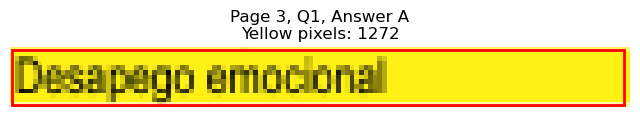

Page 3, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=163.9, y1=169.4
Page 3, Q1, B: Yellow pixels: 2
Page 3, Q1, B: Total non-white pixels: 532
Page 3, Q1, B: Yellow percentage: 0.4%


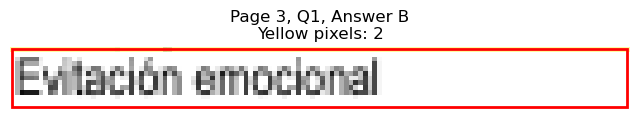

Page 3, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=154.8, y1=181.5
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 359
Page 3, Q1, C: Yellow percentage: 0.0%


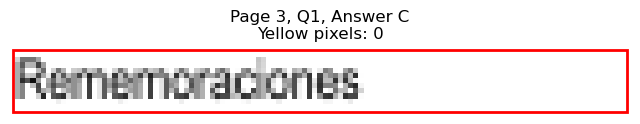

Page 3, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=382.2, y1=157.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 232
Page 3, Q1, D: Yellow percentage: 0.0%


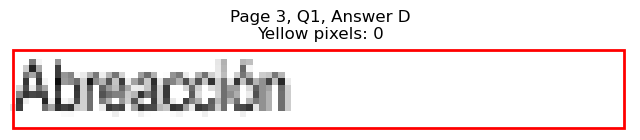

Page 3, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=383.6, y1=169.4
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 251
Page 3, Q1, E: Yellow percentage: 0.0%


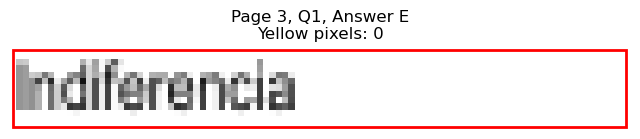


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=217.5, x1=185.7, y1=229.7
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 525
Page 3, Q2, A: Yellow percentage: 0.0%


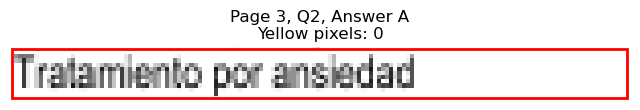

Page 3, Q2 - B: Detected box: x0=85.0, y0=229.7, x1=178.8, y1=241.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 464
Page 3, Q2, B: Yellow percentage: 0.0%


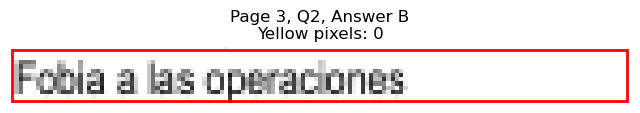

Page 3, Q2 - C: Detected box: x0=85.0, y0=241.7, x1=163.5, y1=253.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 393
Page 3, Q2, C: Yellow percentage: 0.0%


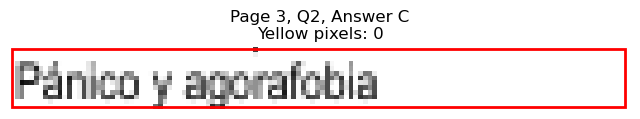

Page 3, Q2 - D: Detected box: x0=336.7, y0=217.5, x1=427.8, y1=229.7
Page 3, Q2, D: Yellow pixels: 1464
Page 3, Q2, D: Total non-white pixels: 1846
Page 3, Q2, D: Yellow percentage: 79.3%


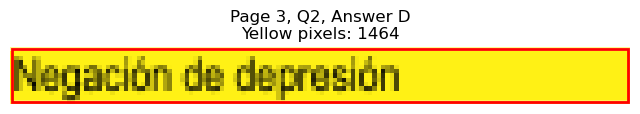

Page 3, Q2 - E: Detected box: x0=336.7, y0=229.7, x1=414.2, y1=241.8
Page 3, Q2, E: Yellow pixels: 129
Page 3, Q2, E: Total non-white pixels: 518
Page 3, Q2, E: Yellow percentage: 24.9%


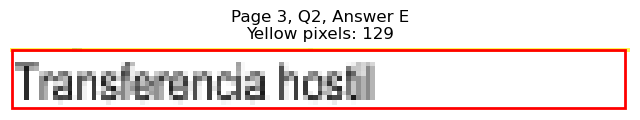


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=125.7, y1=289.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 211
Page 3, Q3, A: Yellow percentage: 0.0%


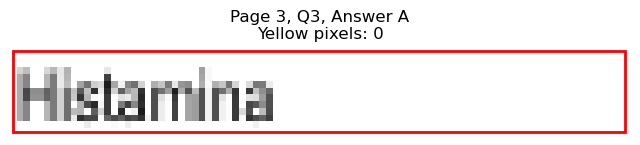

Page 3, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=126.6, y1=302.0
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 215
Page 3, Q3, B: Yellow percentage: 0.0%


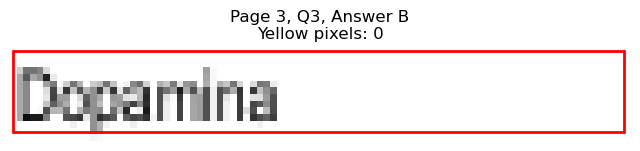

Page 3, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=127.1, y1=314.0
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 220
Page 3, Q3, C: Yellow percentage: 0.0%


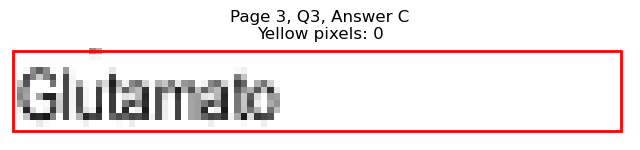

Page 3, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=380.7, y1=289.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 229
Page 3, Q3, D: Yellow percentage: 0.0%


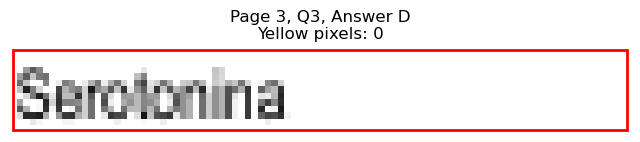

Page 3, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=393.2, y1=302.0
Page 3, Q3, E: Yellow pixels: 1053
Page 3, Q3, E: Total non-white pixels: 1404
Page 3, Q3, E: Yellow percentage: 75.0%


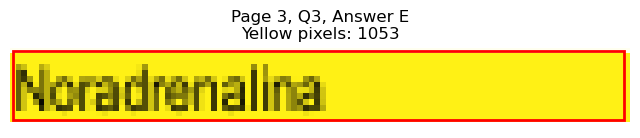


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=125.2, y1=350.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 177
Page 3, Q4, A: Yellow percentage: 0.0%


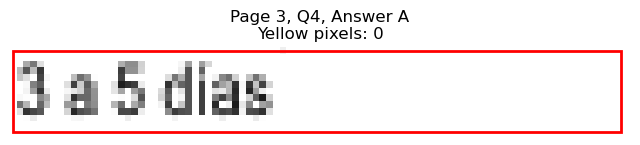

Page 3, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=134.3, y1=362.3
Page 3, Q4, B: Yellow pixels: 1035
Page 3, Q4, B: Total non-white pixels: 1313
Page 3, Q4, B: Yellow percentage: 78.8%


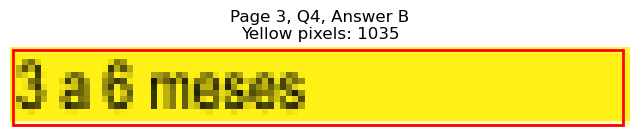

Page 3, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=143.9, y1=374.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 382
Page 3, Q4, C: Yellow percentage: 0.0%


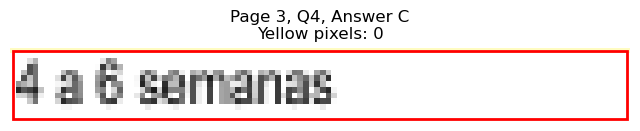

Page 3, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=390.8, y1=350.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 238
Page 3, Q4, D: Yellow percentage: 0.0%


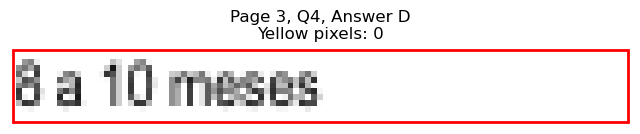

Page 3, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=386.5, y1=362.3
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 224
Page 3, Q4, E: Yellow percentage: 0.0%


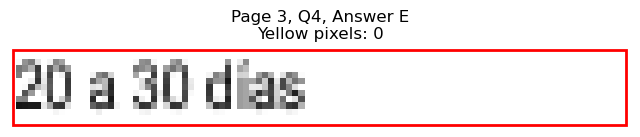


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=446.6, x1=253.0, y1=458.7
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 842
Page 3, Q5, A: Yellow percentage: 0.0%


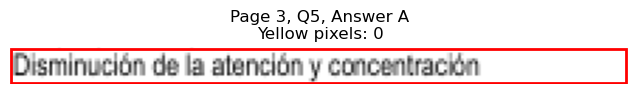

Page 3, Q5 - B: Detected box: x0=85.0, y0=458.6, x1=225.8, y1=470.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 705
Page 3, Q5, B: Yellow percentage: 0.0%


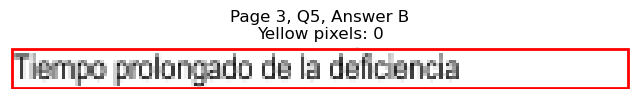

Page 3, Q5 - C: Detected box: x0=85.0, y0=470.7, x1=265.5, y1=482.8
Page 3, Q5, C: Yellow pixels: 1521
Page 3, Q5, C: Total non-white pixels: 2483
Page 3, Q5, C: Yellow percentage: 61.3%


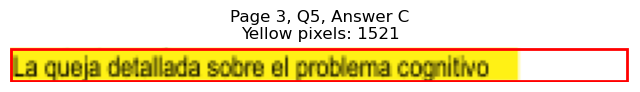

Page 3, Q5 - D: Detected box: x0=336.7, y0=446.6, x1=476.0, y1=458.7
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 688
Page 3, Q5, D: Yellow percentage: 0.0%


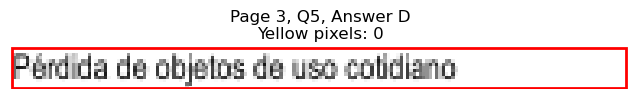

Page 3, Q5 - E: Detected box: x0=336.7, y0=458.6, x1=498.9, y1=470.7
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 815
Page 3, Q5, E: Yellow percentage: 0.0%


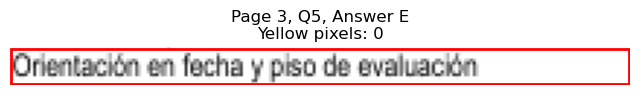


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=518.8, x1=123.7, y1=530.9
Page 3, Q6, A: Yellow pixels: 926
Page 3, Q6, A: Total non-white pixels: 1170
Page 3, Q6, A: Yellow percentage: 79.1%


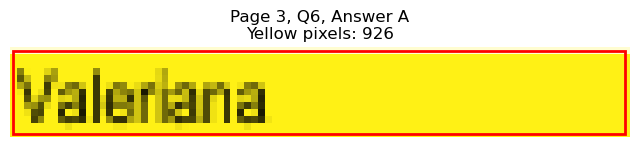

Page 3, Q6 - B: Detected box: x0=85.0, y0=530.9, x1=120.9, y1=543.0
Page 3, Q6, B: Yellow pixels: 87
Page 3, Q6, B: Total non-white pixels: 280
Page 3, Q6, B: Yellow percentage: 31.1%


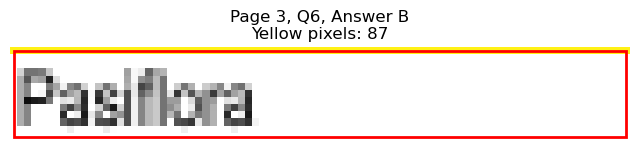

Page 3, Q6 - C: Detected box: x0=85.0, y0=542.9, x1=107.1, y1=555.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 103
Page 3, Q6, C: Yellow percentage: 0.0%


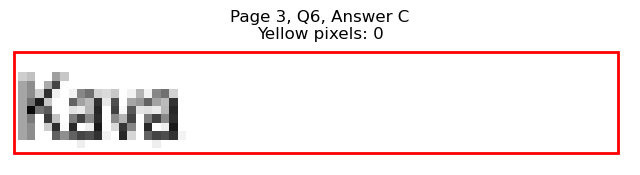

Page 3, Q6 - D: Detected box: x0=336.7, y0=518.8, x1=370.6, y1=530.9
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 175
Page 3, Q6, D: Yellow percentage: 0.0%


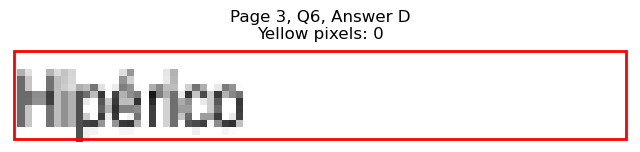

Page 3, Q6 - E: Detected box: x0=336.7, y0=530.9, x1=377.4, y1=543.0
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 227
Page 3, Q6, E: Yellow percentage: 0.0%


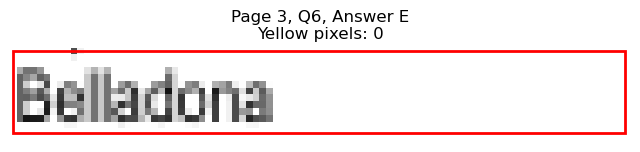


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=133.8, y1=603.3
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 259
Page 3, Q7, A: Yellow percentage: 0.0%


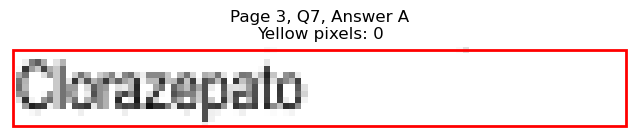

Page 3, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=129.0, y1=615.3
Page 3, Q7, B: Yellow pixels: 96
Page 3, Q7, B: Total non-white pixels: 336
Page 3, Q7, B: Yellow percentage: 28.6%


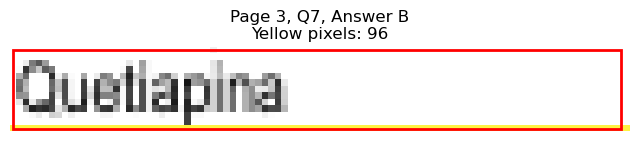

Page 3, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=126.3, y1=627.3
Page 3, Q7, C: Yellow pixels: 932
Page 3, Q7, C: Total non-white pixels: 1209
Page 3, Q7, C: Yellow percentage: 77.1%


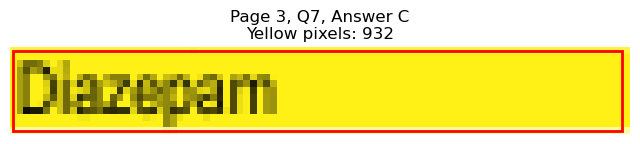

Page 3, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=383.6, y1=603.3
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 264
Page 3, Q7, D: Yellow percentage: 0.0%


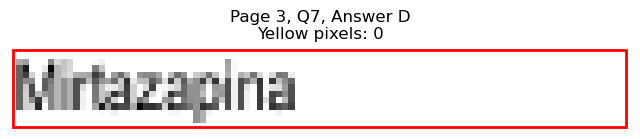

Page 3, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=383.1, y1=615.3
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 236
Page 3, Q7, E: Yellow percentage: 0.0%


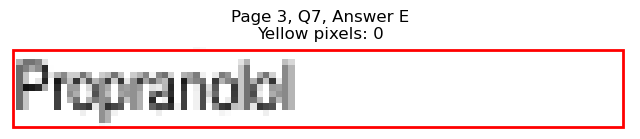


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=70.8, y0=338.1, x1=79.0, y1=350.2
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 211
Page 3, Q8, A: Yellow percentage: 0.0%


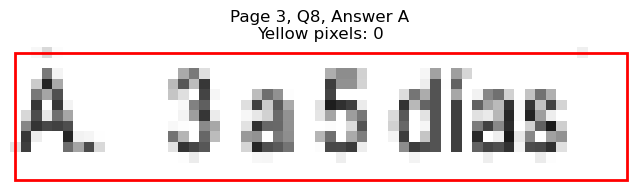

Page 3, Q8 - B: Detected box: x0=70.8, y0=675.4, x1=79.0, y1=687.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 69
Page 3, Q8, B: Yellow percentage: 0.0%


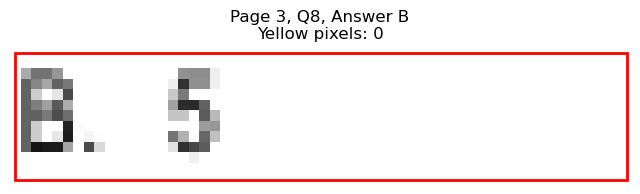

Page 3, Q8 - C: Detected box: x0=85.0, y0=687.5, x1=97.0, y1=699.7
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 55
Page 3, Q8, C: Yellow percentage: 0.0%


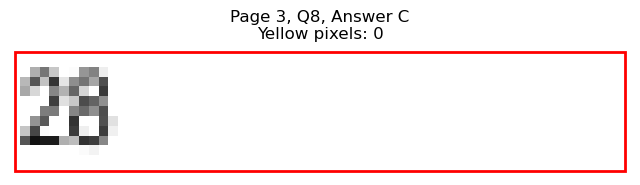

Page 3, Q8 - D: Detected box: x0=322.5, y0=663.4, x1=331.2, y1=675.5
Page 3, Q8, D: Yellow pixels: 60
Page 3, Q8, D: Total non-white pixels: 125
Page 3, Q8, D: Yellow percentage: 48.0%


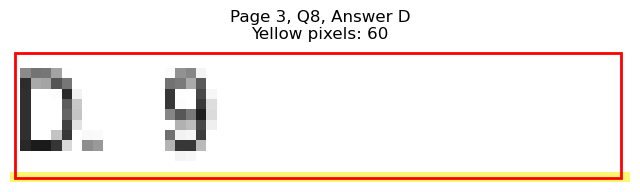

Page 3, Q8 - E: Detected box: x0=336.7, y0=675.4, x1=348.7, y1=687.5
Page 3, Q8, E: Yellow pixels: 788
Page 3, Q8, E: Total non-white pixels: 819
Page 3, Q8, E: Yellow percentage: 96.2%


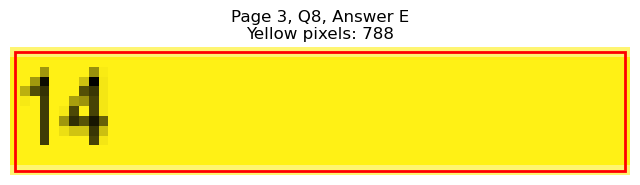


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=723.7, x1=157.2, y1=735.8
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 375
Page 3, Q9, A: Yellow percentage: 0.0%


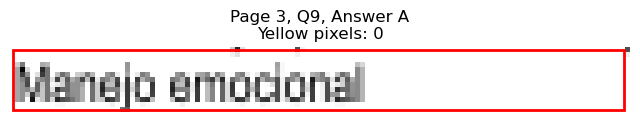

Page 3, Q9 - B: Detected box: x0=85.0, y0=735.8, x1=154.3, y1=747.9
Page 3, Q9, B: Yellow pixels: 1147
Page 3, Q9, B: Total non-white pixels: 1573
Page 3, Q9, B: Yellow percentage: 72.9%


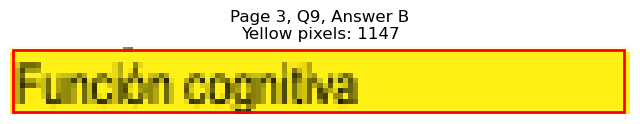

Page 3, Q9 - C: Detected box: x0=85.0, y0=747.8, x1=169.7, y1=759.9
Page 3, Q9, C: Yellow pixels: 133
Page 3, Q9, C: Total non-white pixels: 583
Page 3, Q9, C: Yellow percentage: 22.8%


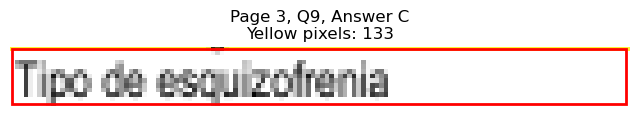

Page 3, Q9 - D: Detected box: x0=336.7, y0=723.7, x1=393.7, y1=735.8
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 301
Page 3, Q9, D: Yellow percentage: 0.0%


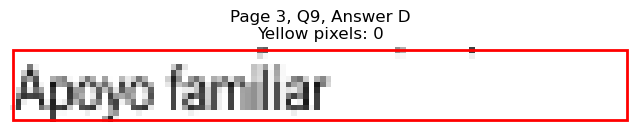

Page 3, Q9 - E: Detected box: x0=336.7, y0=735.8, x1=413.7, y1=747.9
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 379
Page 3, Q9, E: Yellow percentage: 0.0%


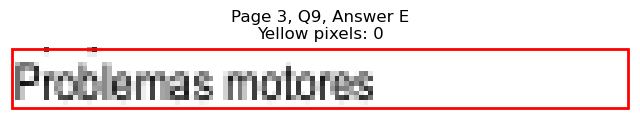


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=136.7, y1=109.2
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 278
Page 4, Q1, A: Yellow percentage: 0.0%


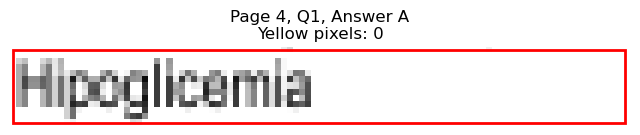

Page 4, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=142.9, y1=121.3
Page 4, Q1, B: Yellow pixels: 1051
Page 4, Q1, B: Total non-white pixels: 1417
Page 4, Q1, B: Yellow percentage: 74.2%


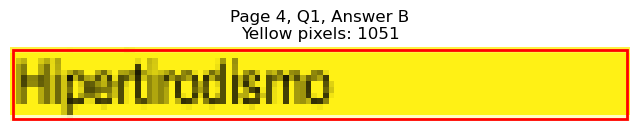

Page 4, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=179.8, y1=133.3
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 624
Page 4, Q1, C: Yellow percentage: 0.0%


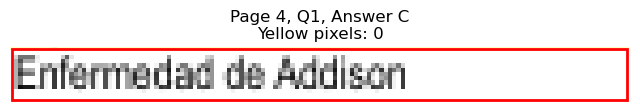

Page 4, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=396.1, y1=109.2
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 287
Page 4, Q1, D: Yellow percentage: 0.0%


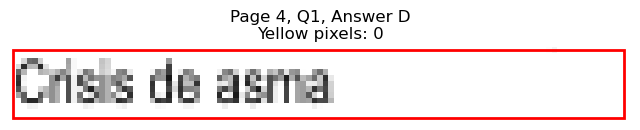

Page 4, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=384.1, y1=121.3
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 255
Page 4, Q1, E: Yellow percentage: 0.0%


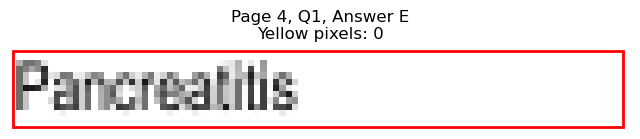


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=122.8, y1=169.4
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 187
Page 4, Q2, A: Yellow percentage: 0.0%


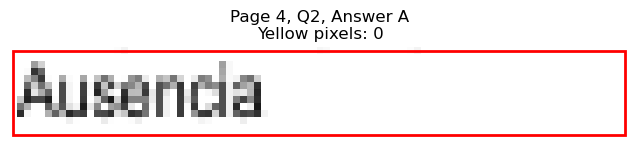

Page 4, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=128.1, y1=181.5
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 241
Page 4, Q2, B: Yellow percentage: 0.0%


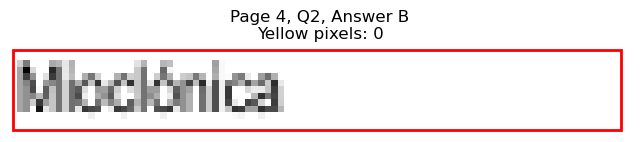

Page 4, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=142.5, y1=193.5
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 286
Page 4, Q2, C: Yellow percentage: 0.0%


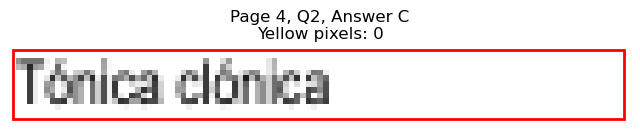

Page 4, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=402.3, y1=169.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 360
Page 4, Q2, D: Yellow percentage: 0.0%


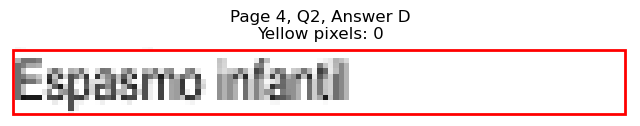

Page 4, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=402.2, y1=181.5
Page 4, Q2, E: Yellow pixels: 1253
Page 4, Q2, E: Total non-white pixels: 1521
Page 4, Q2, E: Yellow percentage: 82.4%


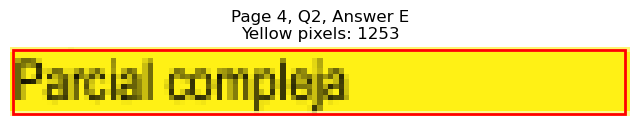


Page 4, Q2 - Selected Answer: E (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=143.9, y1=265.8
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 311
Page 4, Q3, A: Yellow percentage: 0.0%


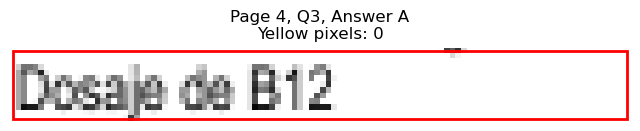

Page 4, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=130.0, y1=277.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 251
Page 4, Q3, B: Yellow percentage: 0.0%


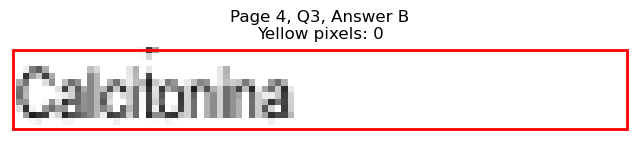

Page 4, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=162.0, y1=289.9
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 399
Page 4, Q3, C: Yellow percentage: 0.0%


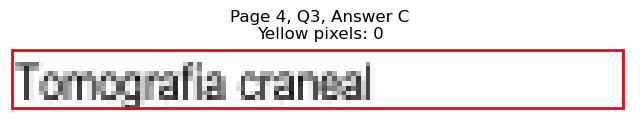

Page 4, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=390.4, y1=265.8
Page 4, Q3, D: Yellow pixels: 1080
Page 4, Q3, D: Total non-white pixels: 1365
Page 4, Q3, D: Yellow percentage: 79.1%


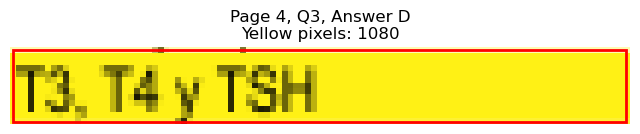

Page 4, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=398.0, y1=277.9
Page 4, Q3, E: Yellow pixels: 110
Page 4, Q3, E: Total non-white pixels: 408
Page 4, Q3, E: Yellow percentage: 27.0%


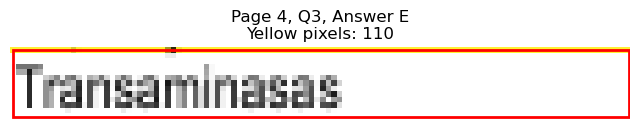


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=104.2, y1=326.0
Page 4, Q4, A: Yellow pixels: 773
Page 4, Q4, A: Total non-white pixels: 994
Page 4, Q4, A: Yellow percentage: 77.8%


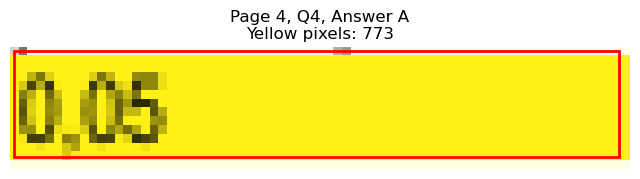

Page 4, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=104.2, y1=338.2
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 161
Page 4, Q4, B: Yellow percentage: 0.0%


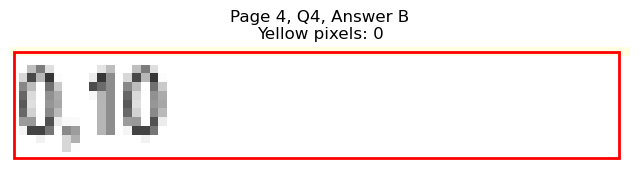

Page 4, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=104.2, y1=350.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 85
Page 4, Q4, C: Yellow percentage: 0.0%


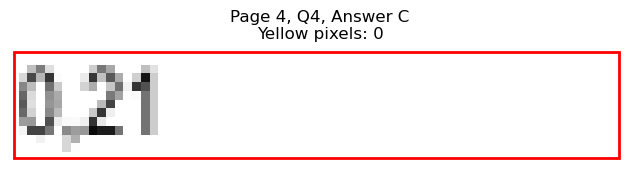

Page 4, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=355.9, y1=326.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 65
Page 4, Q4, D: Yellow percentage: 0.0%


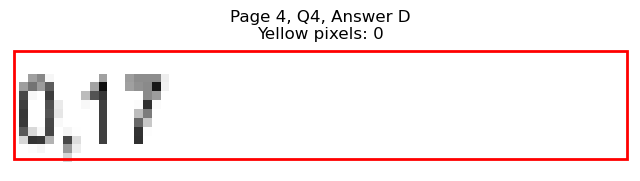

Page 4, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=355.9, y1=338.2
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 94
Page 4, Q4, E: Yellow percentage: 0.0%


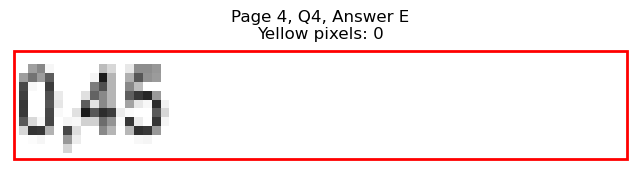


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=164.9, y1=386.3
Page 4, Q5, A: Yellow pixels: 1252
Page 4, Q5, A: Total non-white pixels: 1703
Page 4, Q5, A: Yellow percentage: 73.5%


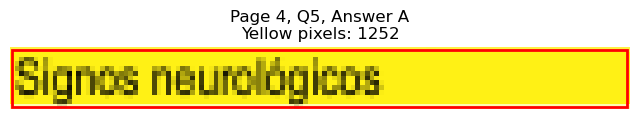

Page 4, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=137.7, y1=398.4
Page 4, Q5, B: Yellow pixels: 1
Page 4, Q5, B: Total non-white pixels: 365
Page 4, Q5, B: Yellow percentage: 0.3%


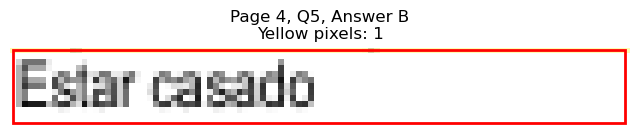

Page 4, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=138.6, y1=410.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 272
Page 4, Q5, C: Yellow percentage: 0.0%


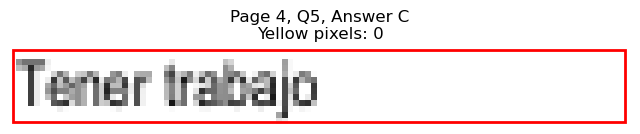

Page 4, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=433.9, y1=386.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 480
Page 4, Q5, D: Yellow percentage: 0.0%


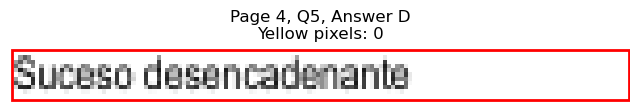

Page 4, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=383.6, y1=398.4
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 228
Page 4, Q5, E: Yellow percentage: 0.0%


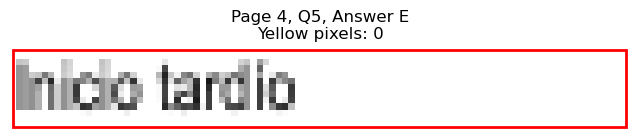


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=138.1, y1=458.7
Page 4, Q6, A: Yellow pixels: 1150
Page 4, Q6, A: Total non-white pixels: 1365
Page 4, Q6, A: Yellow percentage: 84.2%


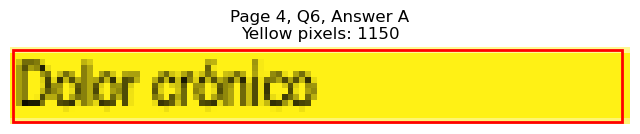

Page 4, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=121.3, y1=470.7
Page 4, Q6, B: Yellow pixels: 88
Page 4, Q6, B: Total non-white pixels: 291
Page 4, Q6, B: Yellow percentage: 30.2%


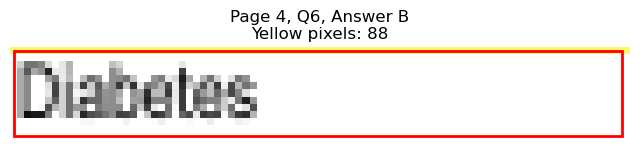

Page 4, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=153.5, y1=482.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 353
Page 4, Q6, C: Yellow percentage: 0.0%


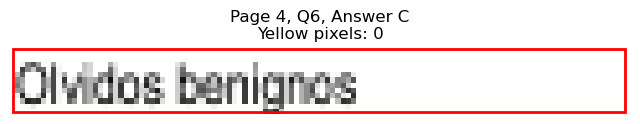

Page 4, Q6 - D: Detected box: x0=336.7, y0=446.6, x1=382.6, y1=458.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 238
Page 4, Q6, D: Yellow percentage: 0.0%


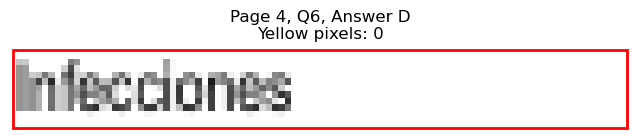

Page 4, Q6 - E: Detected box: x0=336.7, y0=458.6, x1=375.0, y1=470.7
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 200
Page 4, Q6, E: Yellow percentage: 0.0%


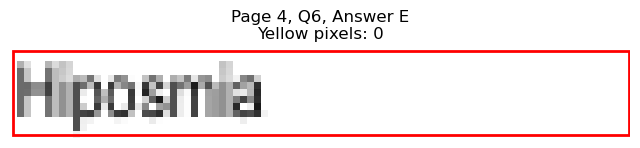


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=115.6, y1=518.9
Page 4, Q7, A: Yellow pixels: 878
Page 4, Q7, A: Total non-white pixels: 1066
Page 4, Q7, A: Yellow percentage: 82.4%


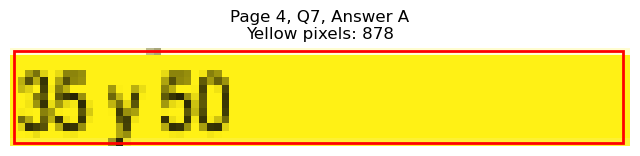

Page 4, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=115.6, y1=530.9
Page 4, Q7, B: Yellow pixels: 80
Page 4, Q7, B: Total non-white pixels: 195
Page 4, Q7, B: Yellow percentage: 41.0%


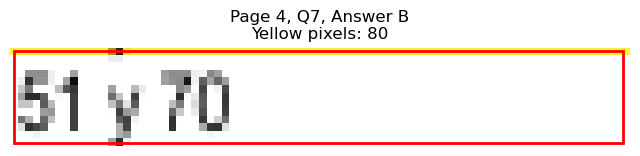

Page 4, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=115.6, y1=543.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 138
Page 4, Q7, C: Yellow percentage: 0.0%


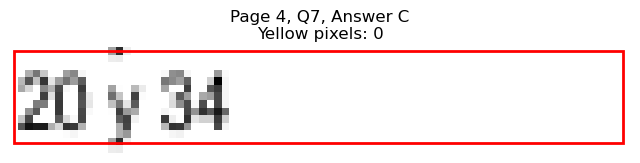

Page 4, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=367.3, y1=518.9
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 115
Page 4, Q7, D: Yellow percentage: 0.0%


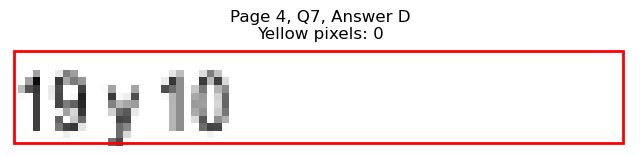

Page 4, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=367.3, y1=530.9
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 128
Page 4, Q7, E: Yellow percentage: 0.0%


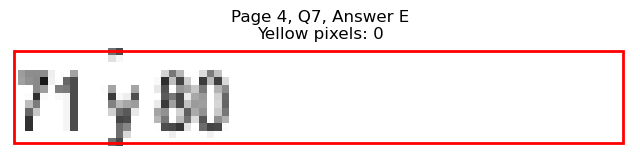


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=132.4, y1=579.2
Page 4, Q8, A: Yellow pixels: 99
Page 4, Q8, A: Total non-white pixels: 316
Page 4, Q8, A: Yellow percentage: 31.3%


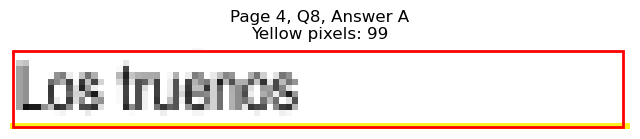

Page 4, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=138.1, y1=591.2
Page 4, Q8, B: Yellow pixels: 1045
Page 4, Q8, B: Total non-white pixels: 1365
Page 4, Q8, B: Yellow percentage: 76.6%


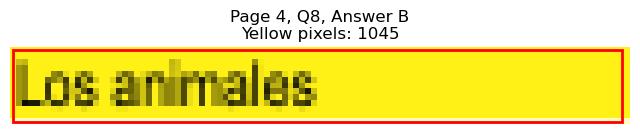

Page 4, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=133.3, y1=603.3
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 321
Page 4, Q8, C: Yellow percentage: 0.0%


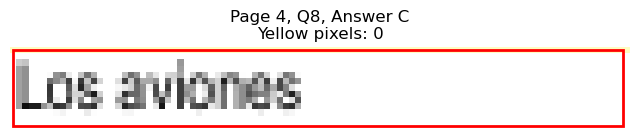

Page 4, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=388.4, y1=579.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 243
Page 4, Q8, D: Yellow percentage: 0.0%


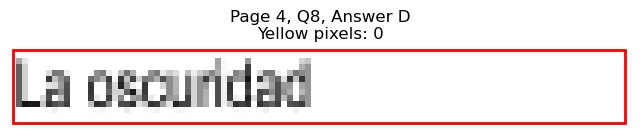

Page 4, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=381.2, y1=591.2
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 219
Page 4, Q8, E: Yellow percentage: 0.0%


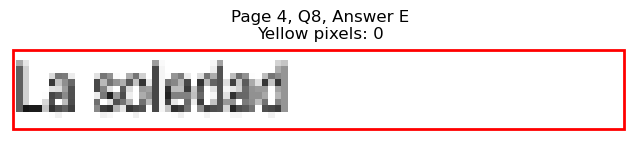


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=154.3, y1=675.5
Page 4, Q9, A: Yellow pixels: 121
Page 4, Q9, A: Total non-white pixels: 491
Page 4, Q9, A: Yellow percentage: 24.6%


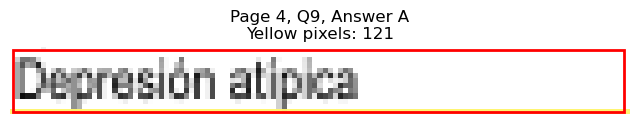

Page 4, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=208.5, y1=687.5
Page 4, Q9, B: Yellow pixels: 1761
Page 4, Q9, B: Total non-white pixels: 2275
Page 4, Q9, B: Yellow percentage: 77.4%


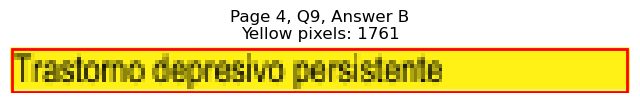

Page 4, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=210.9, y1=699.7
Page 4, Q9, C: Yellow pixels: 177
Page 4, Q9, C: Total non-white pixels: 826
Page 4, Q9, C: Yellow percentage: 21.4%


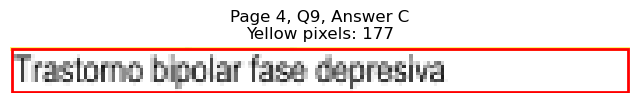

Page 4, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=473.1, y1=675.5
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 738
Page 4, Q9, D: Yellow percentage: 0.0%


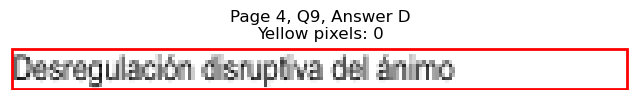

Page 4, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=443.9, y1=687.5
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 533
Page 4, Q9, E: Yellow percentage: 0.0%


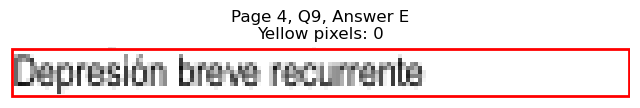


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=747.8, x1=130.9, y1=759.9
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 272
Page 4, Q10, A: Yellow percentage: 0.0%


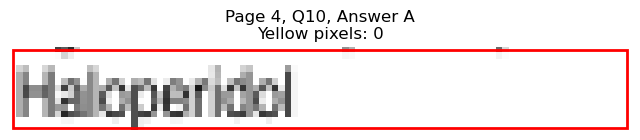

Page 4, Q10 - B: Detected box: x0=85.0, y0=759.8, x1=130.9, y1=771.9
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 244
Page 4, Q10, B: Yellow percentage: 0.0%


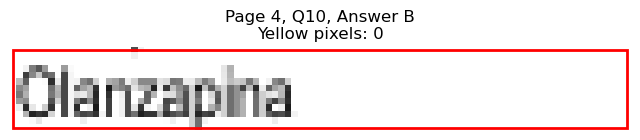

Page 4, Q10 - C: Detected box: x0=85.0, y0=771.9, x1=118.0, y1=784.0
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 174
Page 4, Q10, C: Yellow percentage: 0.0%


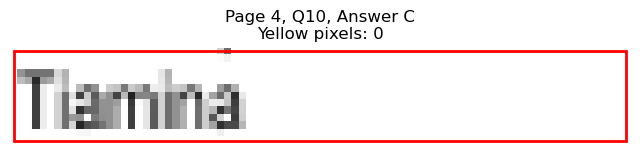

Page 4, Q10 - D: Detected box: x0=336.7, y0=747.8, x1=375.9, y1=759.9
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 292
Page 4, Q10, D: Yellow percentage: 0.0%


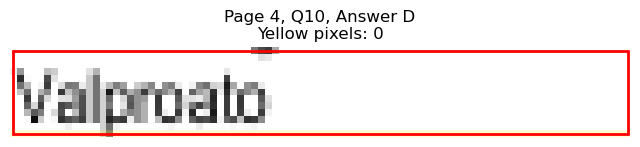

Page 4, Q10 - E: Detected box: x0=336.7, y0=759.8, x1=375.6, y1=771.9
Page 4, Q10, E: Yellow pixels: 899
Page 4, Q10, E: Total non-white pixels: 1170
Page 4, Q10, E: Yellow percentage: 76.8%


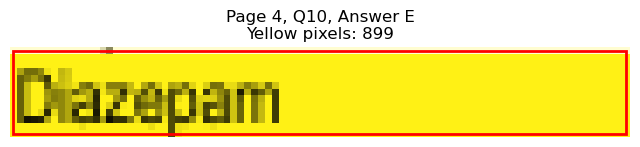


Page 4, Q10 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=211.9, y1=109.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 642
Page 5, Q1, A: Yellow percentage: 0.0%


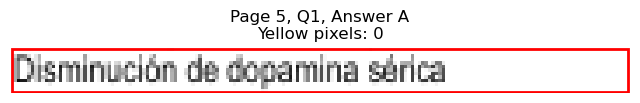

Page 5, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=224.3, y1=121.3
Page 5, Q1, B: Yellow pixels: 1724
Page 5, Q1, B: Total non-white pixels: 2483
Page 5, Q1, B: Yellow percentage: 69.4%


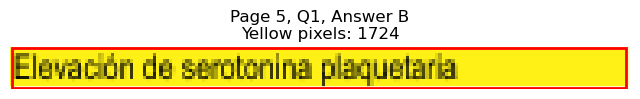

Page 5, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=134.4, y1=133.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 486
Page 5, Q1, C: Yellow percentage: 0.0%


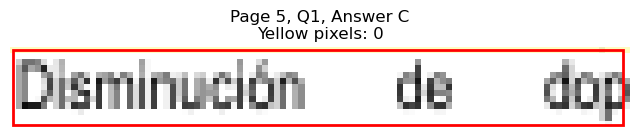

Page 5, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=485.5, y1=109.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 772
Page 5, Q1, D: Yellow percentage: 0.0%


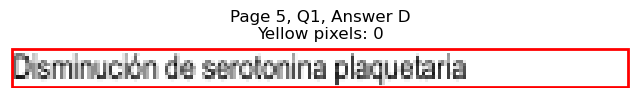

Page 5, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=468.8, y1=121.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 645
Page 5, Q1, E: Yellow percentage: 0.0%


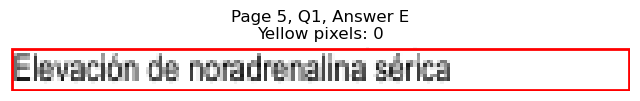


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=173.1, y1=193.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 464
Page 5, Q2, A: Yellow percentage: 0.0%


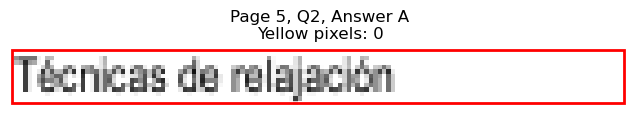

Page 5, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=153.9, y1=205.5
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 388
Page 5, Q2, B: Yellow percentage: 0.0%


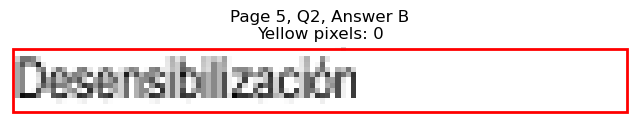

Page 5, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=188.9, y1=217.7
Page 5, Q2, C: Yellow pixels: 1602
Page 5, Q2, C: Total non-white pixels: 2015
Page 5, Q2, C: Yellow percentage: 79.5%


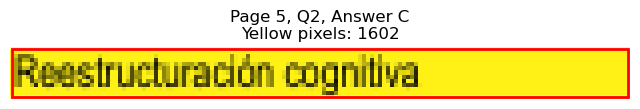

Page 5, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=391.8, y1=193.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 294
Page 5, Q2, D: Yellow percentage: 0.0%


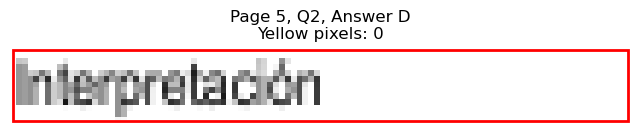

Page 5, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=410.4, y1=205.5
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 348
Page 5, Q2, E: Yellow percentage: 0.0%


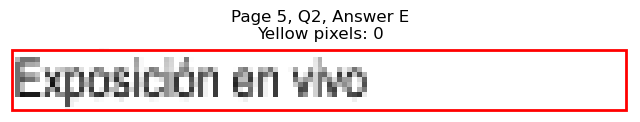


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=168.3, y1=253.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 440
Page 5, Q3, A: Yellow percentage: 0.0%


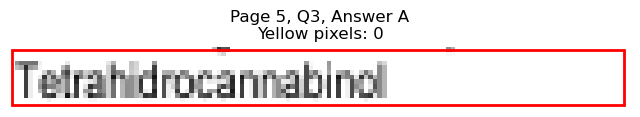

Page 5, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=150.5, y1=265.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 347
Page 5, Q3, B: Yellow percentage: 0.0%


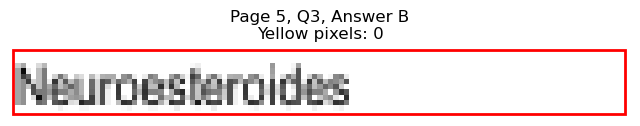

Page 5, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=138.6, y1=277.9
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 278
Page 5, Q3, C: Yellow percentage: 0.0%


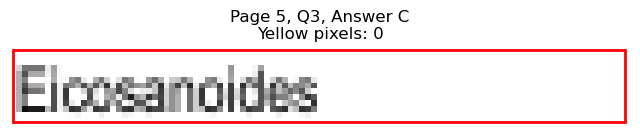

Page 5, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=384.6, y1=253.8
Page 5, Q3, D: Yellow pixels: 984
Page 5, Q3, D: Total non-white pixels: 1287
Page 5, Q3, D: Yellow percentage: 76.5%


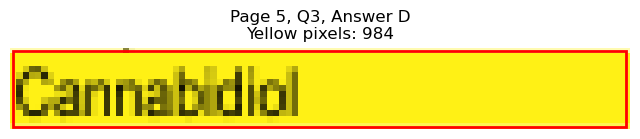

Page 5, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=387.4, y1=265.8
Page 5, Q3, E: Yellow pixels: 102
Page 5, Q3, E: Total non-white pixels: 352
Page 5, Q3, E: Yellow percentage: 29.0%


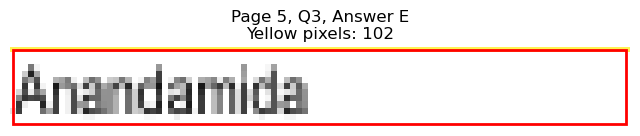


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=116.5, y1=338.2
Page 5, Q4, A: Yellow pixels: 869
Page 5, Q4, A: Total non-white pixels: 1079
Page 5, Q4, A: Yellow percentage: 80.5%


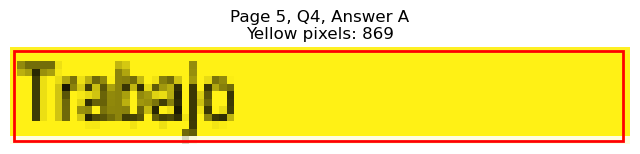

Page 5, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=128.1, y1=350.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 317
Page 5, Q4, B: Yellow percentage: 0.0%


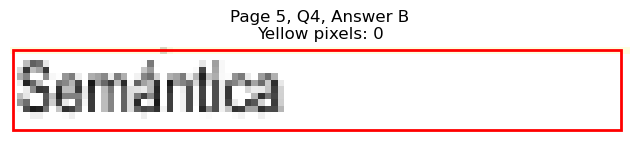

Page 5, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=142.5, y1=362.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 301
Page 5, Q4, C: Yellow percentage: 0.0%


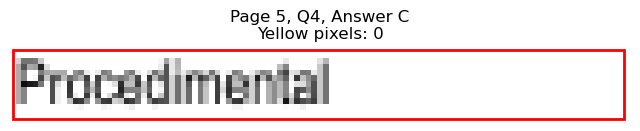

Page 5, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=369.2, y1=338.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 172
Page 5, Q4, D: Yellow percentage: 0.0%


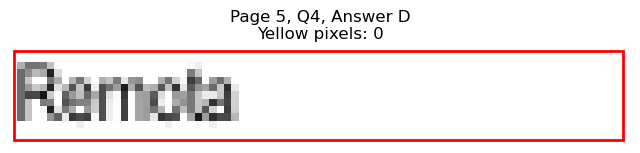

Page 5, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=362.5, y1=350.2
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 122
Page 5, Q4, E: Yellow percentage: 0.0%


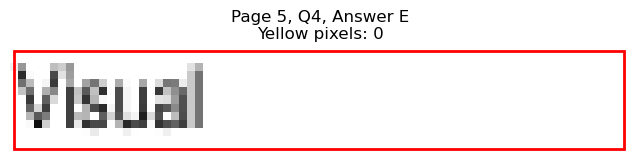


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=262.1, y1=398.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 849
Page 5, Q5, A: Yellow percentage: 0.0%


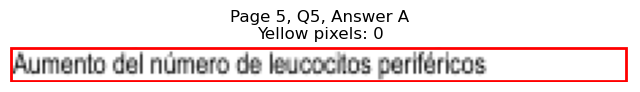

Page 5, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=283.6, y1=410.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 1010
Page 5, Q5, B: Yellow percentage: 0.0%


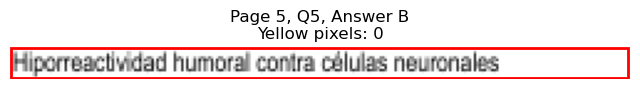

Page 5, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=252.5, y1=422.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 819
Page 5, Q5, C: Yellow percentage: 0.0%


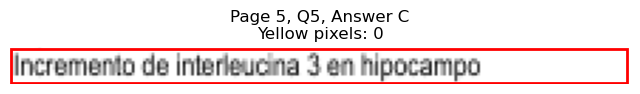

Page 5, Q5 - D: Detected box: x0=85.0, y0=422.4, x1=236.2, y1=434.5
Page 5, Q5, D: Yellow pixels: 203
Page 5, Q5, D: Total non-white pixels: 972
Page 5, Q5, D: Yellow percentage: 20.9%


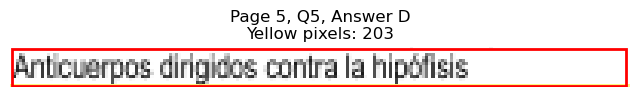

Page 5, Q5 - E: Detected box: x0=85.0, y0=434.4, x1=311.9, y1=446.5
Page 5, Q5, E: Yellow pixels: 2724
Page 5, Q5, E: Total non-white pixels: 3614
Page 5, Q5, E: Yellow percentage: 75.4%


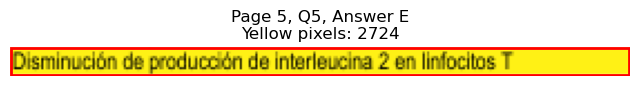


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=125.7, y1=494.8
Page 5, Q6, A: Yellow pixels: 942
Page 5, Q6, A: Total non-white pixels: 1196
Page 5, Q6, A: Yellow percentage: 78.8%


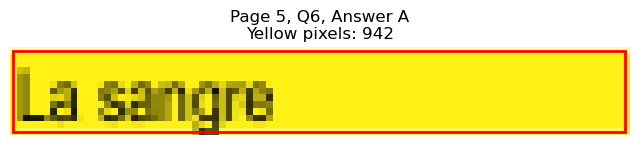

Page 5, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=135.3, y1=506.8
Page 5, Q6, B: Yellow pixels: 98
Page 5, Q6, B: Total non-white pixels: 340
Page 5, Q6, B: Yellow percentage: 28.8%


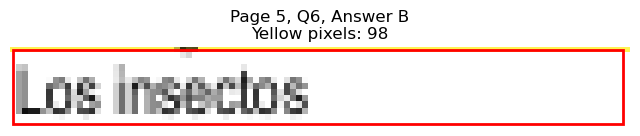

Page 5, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=124.7, y1=518.9
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 179
Page 5, Q6, C: Yellow percentage: 0.0%


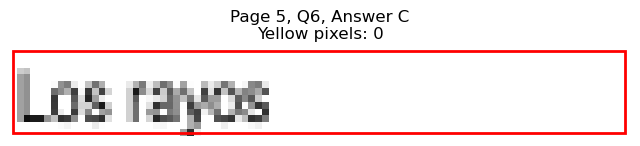

Page 5, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=368.2, y1=494.8
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 157
Page 5, Q6, D: Yellow percentage: 0.0%


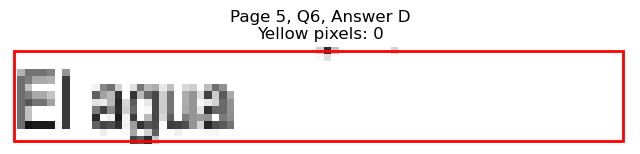

Page 5, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=379.8, y1=506.8
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 195
Page 5, Q6, E: Yellow percentage: 0.0%


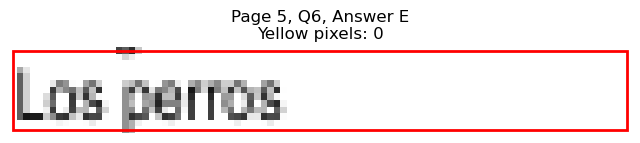


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=579.1, x1=129.5, y1=591.2
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 237
Page 5, Q7, A: Yellow percentage: 0.0%


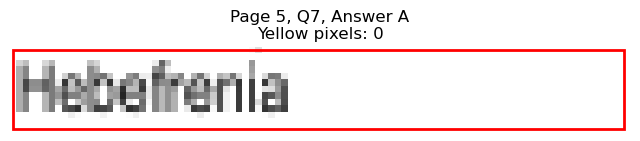

Page 5, Q7 - B: Detected box: x0=85.0, y0=591.2, x1=152.1, y1=603.3
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 350
Page 5, Q7, B: Yellow percentage: 0.0%


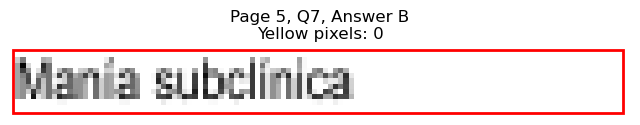

Page 5, Q7 - C: Detected box: x0=85.0, y0=603.2, x1=134.8, y1=615.3
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 257
Page 5, Q7, C: Yellow percentage: 0.0%


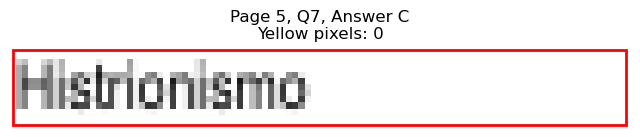

Page 5, Q7 - D: Detected box: x0=336.7, y0=579.1, x1=376.4, y1=591.2
Page 5, Q7, D: Yellow pixels: 909
Page 5, Q7, D: Total non-white pixels: 1183
Page 5, Q7, D: Yellow percentage: 76.8%


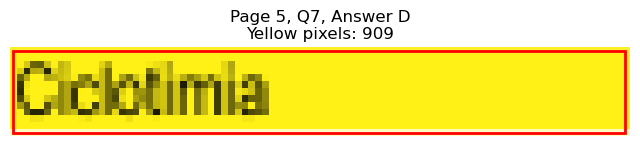

Page 5, Q7 - E: Detected box: x0=336.7, y0=591.2, x1=390.3, y1=603.3
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 387
Page 5, Q7, E: Yellow percentage: 0.0%


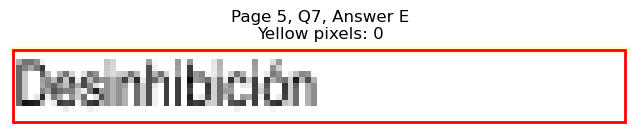


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=675.4, x1=127.6, y1=687.5
Page 5, Q8, A: Yellow pixels: 1041
Page 5, Q8, A: Total non-white pixels: 1222
Page 5, Q8, A: Yellow percentage: 85.2%


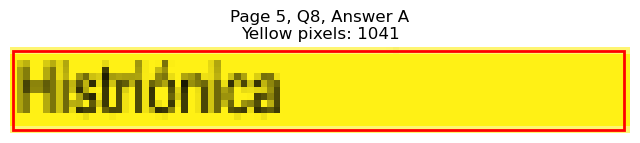

Page 5, Q8 - B: Detected box: x0=85.0, y0=687.5, x1=123.3, y1=699.7
Page 5, Q8, B: Yellow pixels: 90
Page 5, Q8, B: Total non-white pixels: 288
Page 5, Q8, B: Yellow percentage: 31.2%


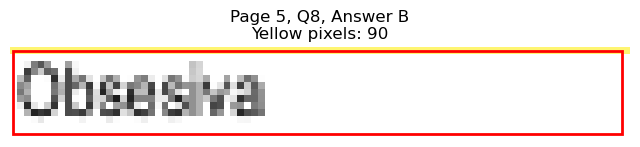

Page 5, Q8 - C: Detected box: x0=85.0, y0=699.5, x1=120.9, y1=711.7
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 184
Page 5, Q8, C: Yellow percentage: 0.0%


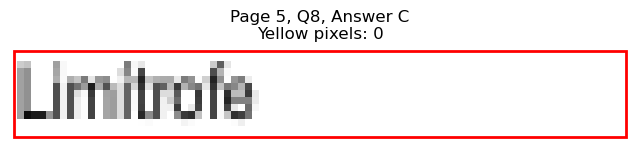

Page 5, Q8 - D: Detected box: x0=336.7, y0=675.4, x1=378.3, y1=687.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 210
Page 5, Q8, D: Yellow percentage: 0.0%


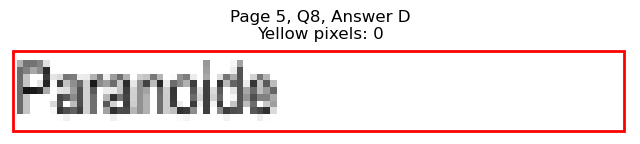

Page 5, Q8 - E: Detected box: x0=336.7, y0=687.5, x1=385.7, y1=699.7
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 274
Page 5, Q8, E: Yellow percentage: 0.0%


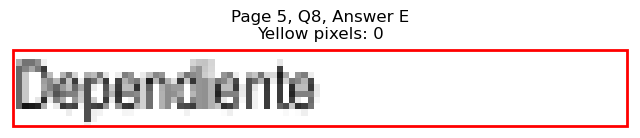


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=154.3, y1=145.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 364
Page 6, Q1, A: Yellow percentage: 0.0%


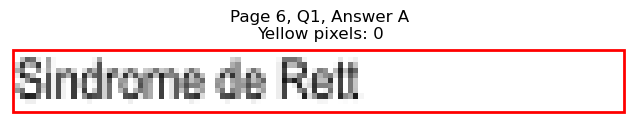

Page 6, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=139.6, y1=157.4
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 284
Page 6, Q1, B: Yellow percentage: 0.0%


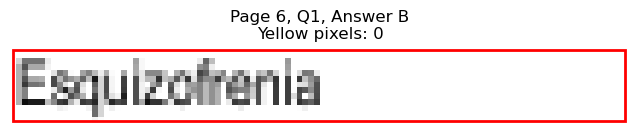

Page 6, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=168.7, y1=169.4
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 410
Page 6, Q1, C: Yellow percentage: 0.0%


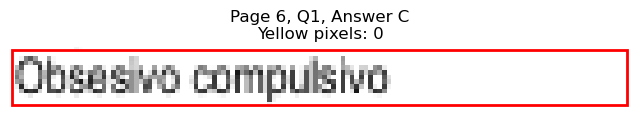

Page 6, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=415.2, y1=145.3
Page 6, Q1, D: Yellow pixels: 1230
Page 6, Q1, D: Total non-white pixels: 1690
Page 6, Q1, D: Yellow percentage: 72.8%


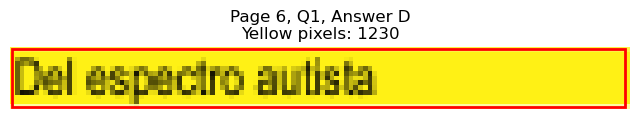

Page 6, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=407.5, y1=157.4
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 494
Page 6, Q1, E: Yellow percentage: 0.0%


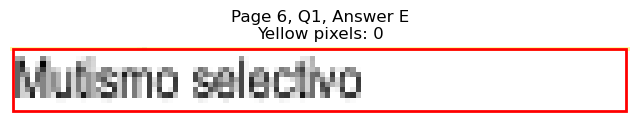


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=101.8, y1=205.5
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 86
Page 6, Q2, A: Yellow percentage: 0.0%


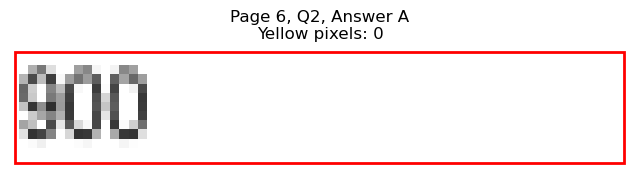

Page 6, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=101.8, y1=217.7
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 78
Page 6, Q2, B: Yellow percentage: 0.0%


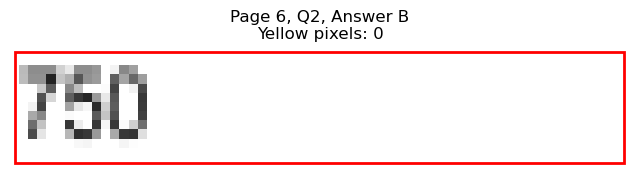

Page 6, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=101.8, y1=229.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 78
Page 6, Q2, C: Yellow percentage: 0.0%


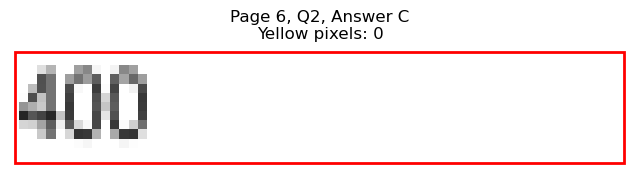

Page 6, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=358.3, y1=205.5
Page 6, Q2, D: Yellow pixels: 868
Page 6, Q2, D: Total non-white pixels: 949
Page 6, Q2, D: Yellow percentage: 91.5%


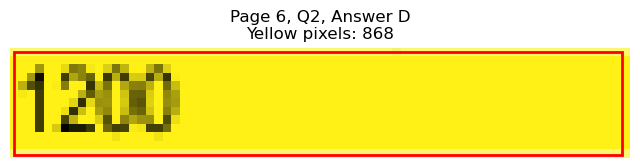

Page 6, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=358.3, y1=217.7
Page 6, Q2, E: Yellow pixels: 73
Page 6, Q2, E: Total non-white pixels: 182
Page 6, Q2, E: Yellow percentage: 40.1%


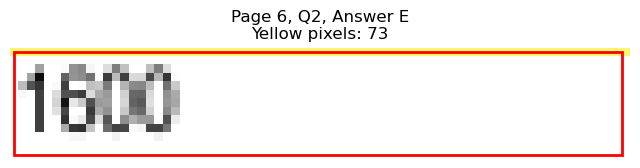


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=147.7, y1=265.8
Page 6, Q3, A: Yellow pixels: 1125
Page 6, Q3, A: Total non-white pixels: 1482
Page 6, Q3, A: Yellow percentage: 75.9%


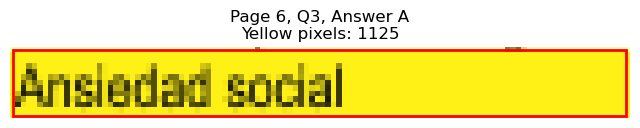

Page 6, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=181.2, y1=277.9
Page 6, Q3, B: Yellow pixels: 148
Page 6, Q3, B: Total non-white pixels: 644
Page 6, Q3, B: Yellow percentage: 23.0%


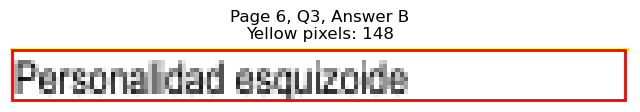

Page 6, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=121.8, y1=289.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 186
Page 6, Q3, C: Yellow percentage: 0.0%


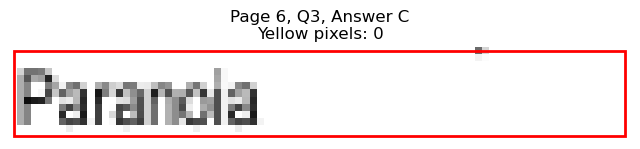

Page 6, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=390.8, y1=265.8
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 252
Page 6, Q3, D: Yellow percentage: 0.0%


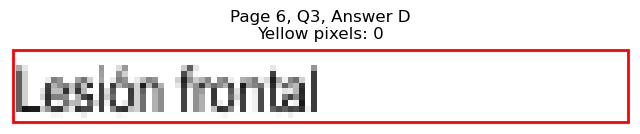

Page 6, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=420.4, y1=277.9
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 436
Page 6, Q3, E: Yellow percentage: 0.0%


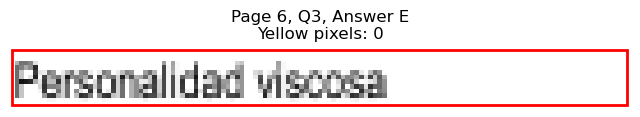


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=131.9, y1=326.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 246
Page 6, Q4, A: Yellow percentage: 0.0%


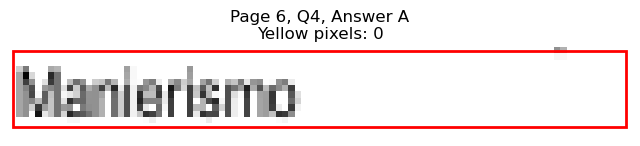

Page 6, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=132.9, y1=338.2
Page 6, Q4, B: Yellow pixels: 965
Page 6, Q4, B: Total non-white pixels: 1287
Page 6, Q4, B: Yellow percentage: 75.0%


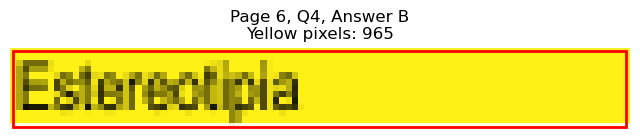

Page 6, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=127.1, y1=350.2
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 328
Page 6, Q4, C: Yellow percentage: 0.0%


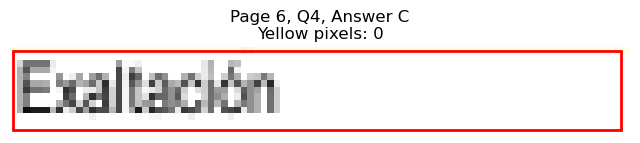

Page 6, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=370.6, y1=326.0
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 174
Page 6, Q4, D: Yellow percentage: 0.0%


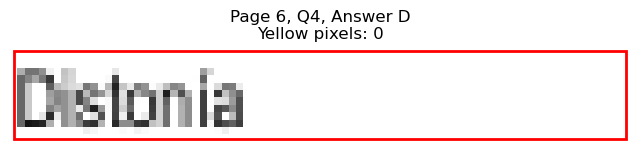

Page 6, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=382.6, y1=338.2
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 224
Page 6, Q4, E: Yellow percentage: 0.0%


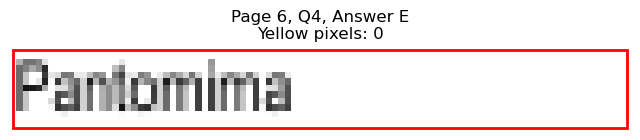


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=187.9, y1=398.4
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 566
Page 6, Q5, A: Yellow percentage: 0.0%


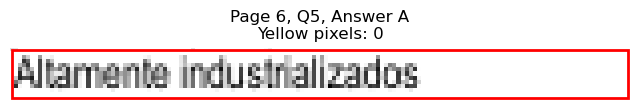

Page 6, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=176.4, y1=410.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 457
Page 6, Q5, B: Yellow percentage: 0.0%


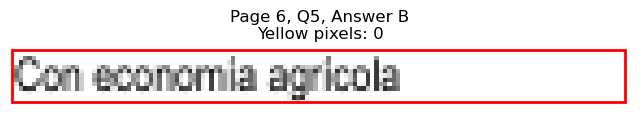

Page 6, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=202.7, y1=422.5
Page 6, Q5, C: Yellow pixels: 1708
Page 6, Q5, C: Total non-white pixels: 2197
Page 6, Q5, C: Yellow percentage: 77.7%


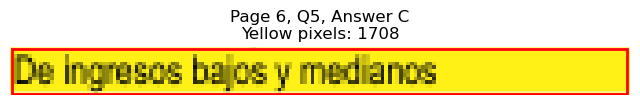

Page 6, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=416.1, y1=398.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 418
Page 6, Q5, D: Yellow percentage: 0.0%


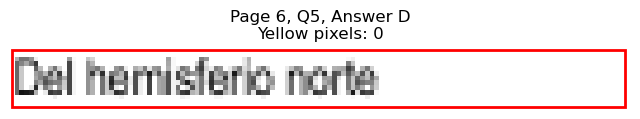

Page 6, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=450.6, y1=410.4
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 590
Page 6, Q5, E: Yellow percentage: 0.0%


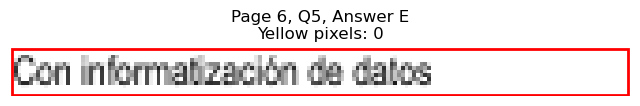


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=107.4, y1=458.7
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 98
Page 6, Q6, A: Yellow percentage: 0.0%


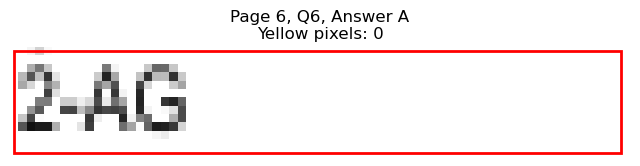

Page 6, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=122.8, y1=470.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 203
Page 6, Q6, B: Yellow percentage: 0.0%


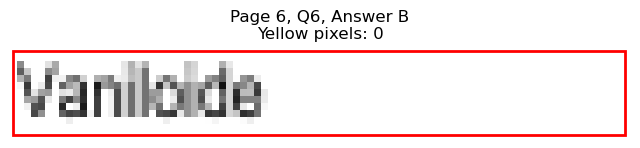

Page 6, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=111.3, y1=482.8
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 131
Page 6, Q6, C: Yellow percentage: 0.0%


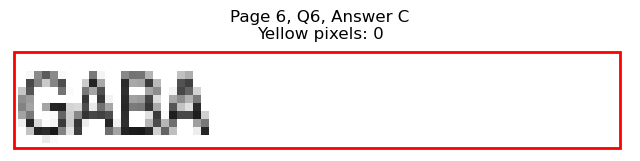

Page 6, Q6 - D: Detected box: x0=336.7, y0=446.6, x1=350.1, y1=458.7
Page 6, Q6, D: Yellow pixels: 65
Page 6, Q6, D: Total non-white pixels: 128
Page 6, Q6, D: Yellow percentage: 50.8%


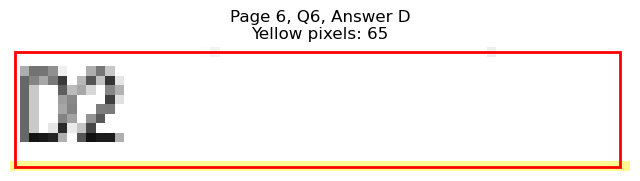

Page 6, Q6 - E: Detected box: x0=336.7, y0=458.6, x1=355.9, y1=470.7
Page 6, Q6, E: Yellow pixels: 839
Page 6, Q6, E: Total non-white pixels: 910
Page 6, Q6, E: Yellow percentage: 92.2%


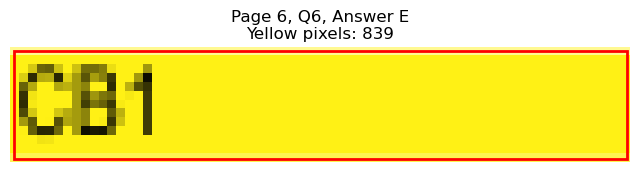


Page 6, Q6 - Selected Answer: E (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=134.8, y1=543.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 272
Page 6, Q7, A: Yellow percentage: 0.0%


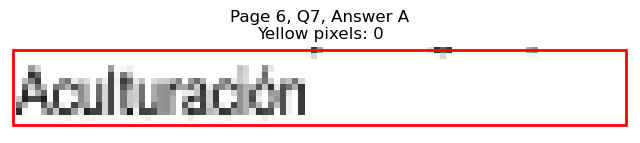

Page 6, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=180.7, y1=555.0
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 490
Page 6, Q7, B: Yellow percentage: 0.0%


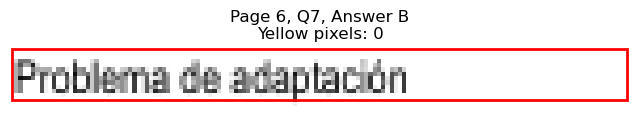

Page 6, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=159.1, y1=567.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 384
Page 6, Q7, C: Yellow percentage: 0.0%


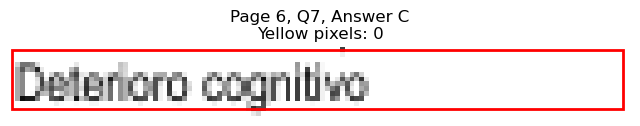

Page 6, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=437.7, y1=543.0
Page 6, Q7, D: Yellow pixels: 152
Page 6, Q7, D: Total non-white pixels: 836
Page 6, Q7, D: Yellow percentage: 18.2%


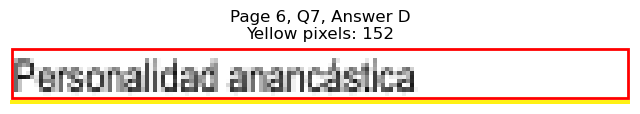

Page 6, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=439.6, y1=555.0
Page 6, Q7, E: Yellow pixels: 1421
Page 6, Q7, E: Total non-white pixels: 2004
Page 6, Q7, E: Yellow percentage: 70.9%


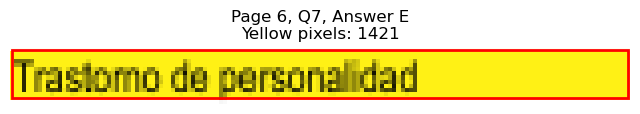


Page 6, Q7 - Selected Answer: E (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=639.3, x1=180.3, y1=651.4
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 494
Page 6, Q8, A: Yellow percentage: 0.0%


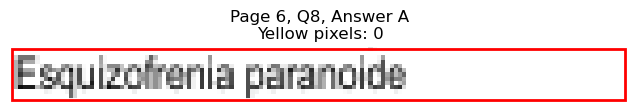

Page 6, Q8 - B: Detected box: x0=85.0, y0=651.4, x1=184.1, y1=663.5
Page 6, Q8, B: Yellow pixels: 1569
Page 6, Q8, B: Total non-white pixels: 1963
Page 6, Q8, B: Yellow percentage: 79.9%


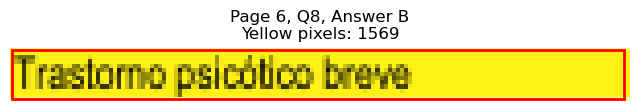

Page 6, Q8 - C: Detected box: x0=85.0, y0=663.4, x1=159.6, y1=675.5
Page 6, Q8, C: Yellow pixels: 126
Page 6, Q8, C: Total non-white pixels: 510
Page 6, Q8, C: Yellow percentage: 24.7%


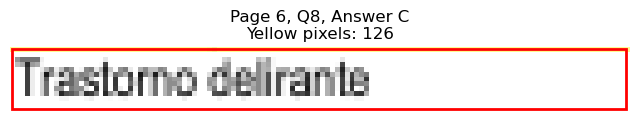

Page 6, Q8 - D: Detected box: x0=336.7, y0=639.3, x1=414.2, y1=651.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 399
Page 6, Q8, D: Yellow percentage: 0.0%


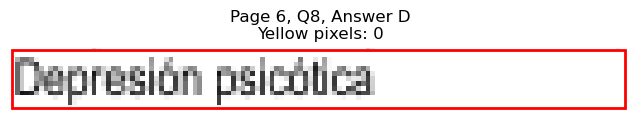

Page 6, Q8 - E: Detected box: x0=336.7, y0=651.4, x1=407.0, y1=663.5
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 362
Page 6, Q8, E: Yellow percentage: 0.0%


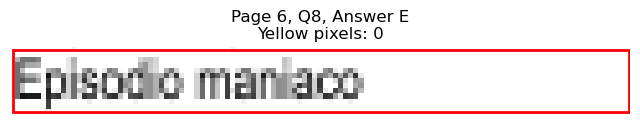


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=735.8, x1=137.2, y1=747.9
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 379
Page 6, Q9, A: Yellow percentage: 0.0%


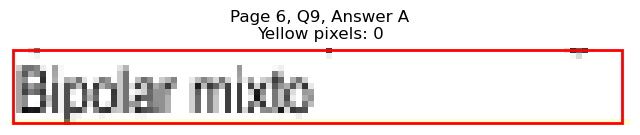

Page 6, Q9 - B: Detected box: x0=85.0, y0=265.8, x1=181.2, y1=277.9
Page 6, Q9, B: Yellow pixels: 148
Page 6, Q9, B: Total non-white pixels: 644
Page 6, Q9, B: Yellow percentage: 23.0%


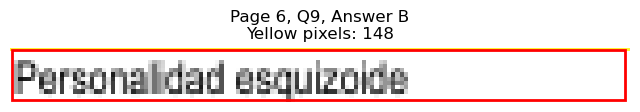

Page 6, Q9 - C: Detected box: x0=85.0, y0=157.3, x1=168.7, y1=169.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 410
Page 6, Q9, C: Yellow percentage: 0.0%


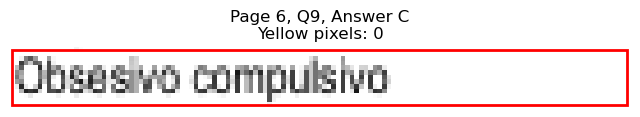

Page 6, Q9 - D: Detected box: x0=336.7, y0=735.8, x1=418.5, y1=747.9
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 423
Page 6, Q9, D: Yellow percentage: 0.0%


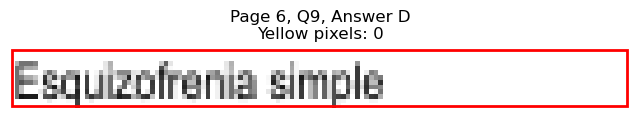

Page 6, Q9 - E: Detected box: x0=336.7, y0=747.8, x1=400.5, y1=759.9
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 317
Page 6, Q9, E: Yellow percentage: 0.0%


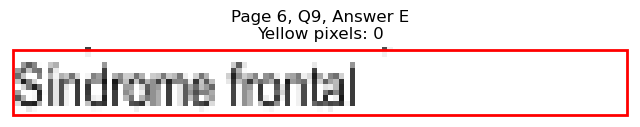


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=125.7, y1=157.4
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 221
Page 7, Q1, A: Yellow percentage: 0.0%


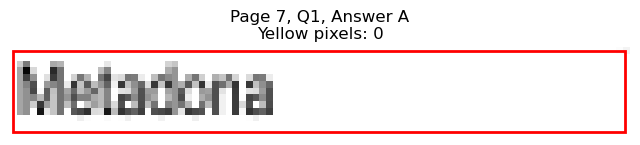

Page 7, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=128.1, y1=169.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 230
Page 7, Q1, B: Yellow percentage: 0.0%


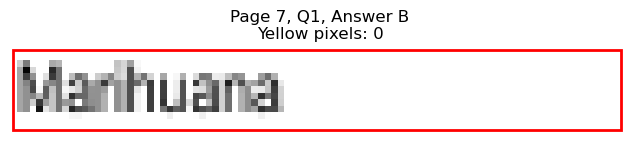

Page 7, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=115.6, y1=181.5
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 141
Page 7, Q1, C: Yellow percentage: 0.0%


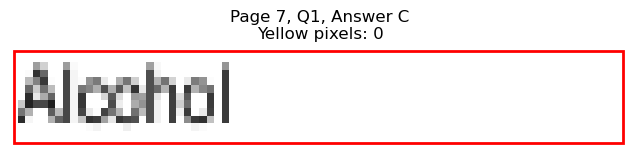

Page 7, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=375.4, y1=157.4
Page 7, Q1, D: Yellow pixels: 90
Page 7, Q1, D: Total non-white pixels: 265
Page 7, Q1, D: Yellow percentage: 34.0%


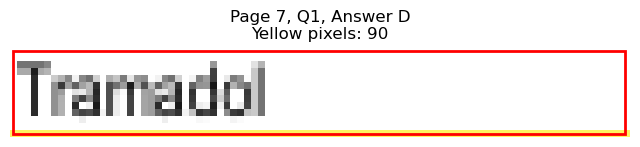

Page 7, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=371.1, y1=169.4
Page 7, Q1, E: Yellow pixels: 972
Page 7, Q1, E: Total non-white pixels: 1118
Page 7, Q1, E: Yellow percentage: 86.9%


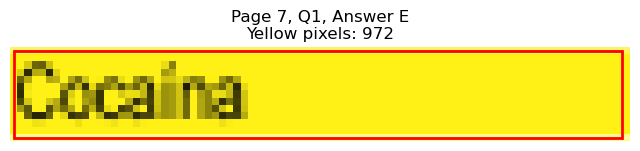


Page 7, Q1 - Selected Answer: E (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=241.7, x1=139.6, y1=253.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 278
Page 7, Q2, A: Yellow percentage: 0.0%


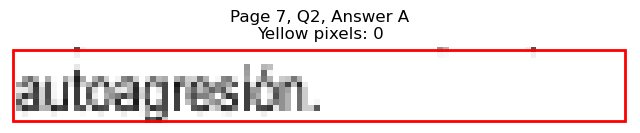

Page 7, Q2 - B: Detected box: x0=85.0, y0=253.7, x1=146.8, y1=265.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 305
Page 7, Q2, B: Yellow percentage: 0.0%


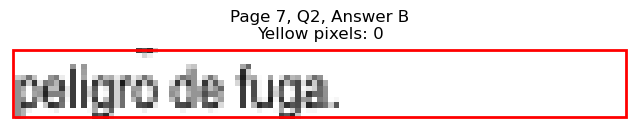

Page 7, Q2 - C: Detected box: x0=85.0, y0=265.8, x1=134.8, y1=277.9
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 269
Page 7, Q2, C: Yellow percentage: 0.0%


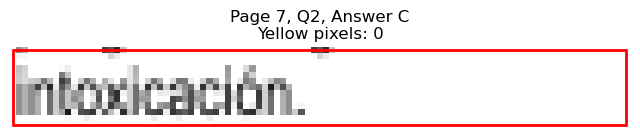

Page 7, Q2 - D: Detected box: x0=336.7, y0=241.7, x1=392.7, y1=253.8
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 379
Page 7, Q2, D: Yellow percentage: 0.0%


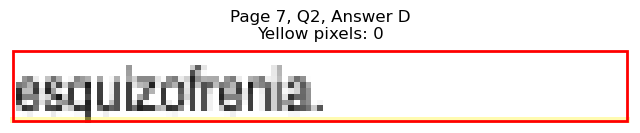

Page 7, Q2 - E: Detected box: x0=336.7, y0=253.7, x1=414.2, y1=265.8
Page 7, Q2, E: Yellow pixels: 1218
Page 7, Q2, E: Total non-white pixels: 1677
Page 7, Q2, E: Yellow percentage: 72.6%


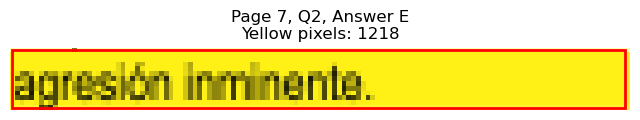


Page 7, Q2 - Selected Answer: E (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=338.1, x1=130.9, y1=350.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 263
Page 7, Q3, A: Yellow percentage: 0.0%


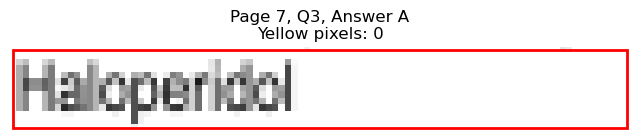

Page 7, Q3 - B: Detected box: x0=85.0, y0=350.2, x1=129.0, y1=362.3
Page 7, Q3, B: Yellow pixels: 968
Page 7, Q3, B: Total non-white pixels: 1248
Page 7, Q3, B: Yellow percentage: 77.6%


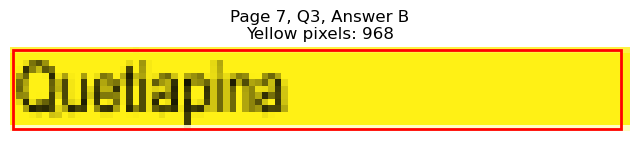

Page 7, Q3 - C: Detected box: x0=85.0, y0=362.2, x1=132.4, y1=374.3
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 353
Page 7, Q3, C: Yellow percentage: 0.0%


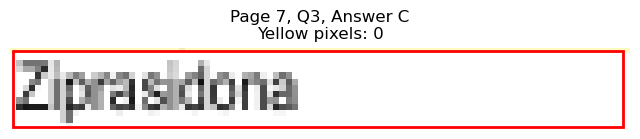

Page 7, Q3 - D: Detected box: x0=336.7, y0=338.1, x1=377.4, y1=350.2
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 206
Page 7, Q3, D: Yellow percentage: 0.0%


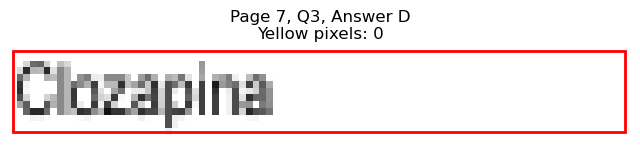

Page 7, Q3 - E: Detected box: x0=336.7, y0=350.2, x1=385.0, y1=362.3
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 268
Page 7, Q3, E: Yellow percentage: 0.0%


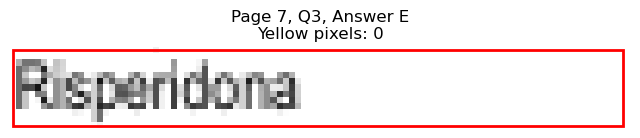


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=434.4, x1=132.9, y1=446.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 269
Page 7, Q4, A: Yellow percentage: 0.0%


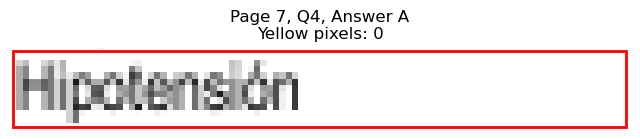

Page 7, Q4 - B: Detected box: x0=85.0, y0=446.6, x1=117.0, y1=458.7
Page 7, Q4, B: Yellow pixels: 962
Page 7, Q4, B: Total non-white pixels: 1092
Page 7, Q4, B: Yellow percentage: 88.1%


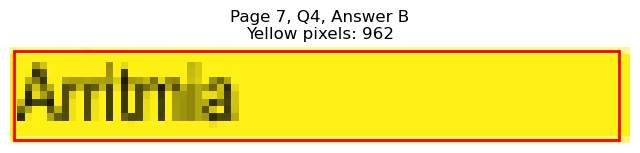

Page 7, Q4 - C: Detected box: x0=85.0, y0=458.6, x1=116.5, y1=470.7
Page 7, Q4, C: Yellow pixels: 83
Page 7, Q4, C: Total non-white pixels: 226
Page 7, Q4, C: Yellow percentage: 36.7%


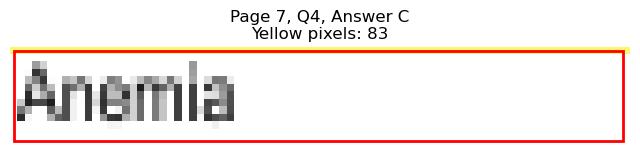

Page 7, Q4 - D: Detected box: x0=336.7, y0=434.4, x1=396.6, y1=446.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 317
Page 7, Q4, D: Yellow percentage: 0.0%


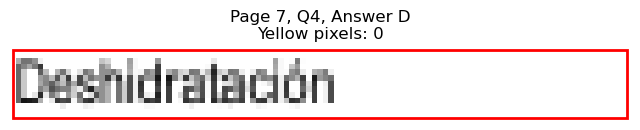

Page 7, Q4 - E: Detected box: x0=336.7, y0=446.6, x1=379.3, y1=458.7
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 206
Page 7, Q4, E: Yellow percentage: 0.0%


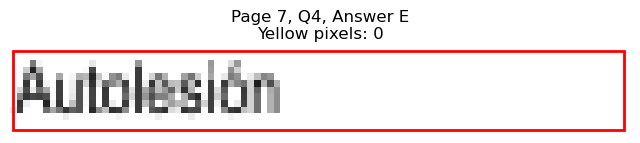


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=494.7, x1=154.0, y1=506.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 344
Page 7, Q5, A: Yellow percentage: 0.0%


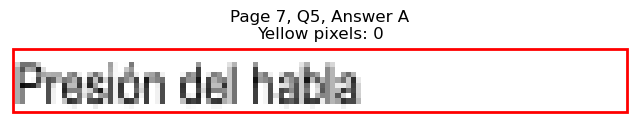

Page 7, Q5 - B: Detected box: x0=85.0, y0=506.8, x1=154.8, y1=518.9
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 474
Page 7, Q5, B: Yellow percentage: 0.0%


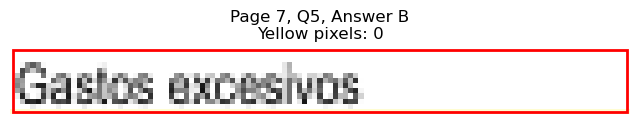

Page 7, Q5 - C: Detected box: x0=85.0, y0=518.8, x1=163.9, y1=530.9
Page 7, Q5, C: Yellow pixels: 1224
Page 7, Q5, C: Total non-white pixels: 1690
Page 7, Q5, C: Yellow percentage: 72.4%


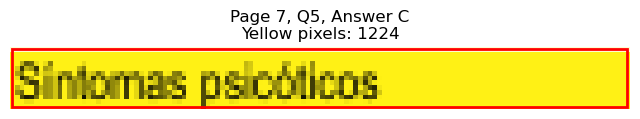

Page 7, Q5 - D: Detected box: x0=336.7, y0=494.7, x1=374.0, y1=506.8
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 194
Page 7, Q5, D: Yellow percentage: 0.0%


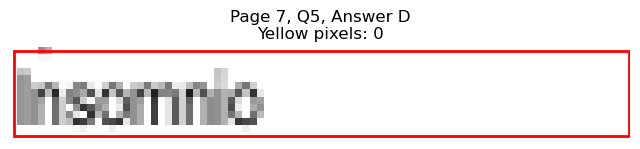

Page 7, Q5 - E: Detected box: x0=336.7, y0=506.8, x1=381.2, y1=518.9
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 265
Page 7, Q5, E: Yellow percentage: 0.0%


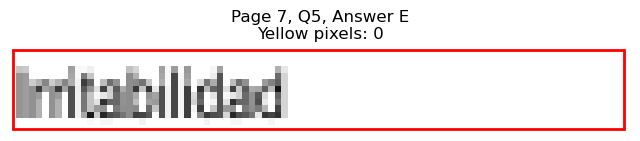


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=579.1, x1=130.9, y1=591.2
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 195
Page 7, Q6, A: Yellow percentage: 0.0%


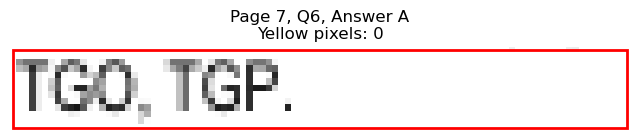

Page 7, Q6 - B: Detected box: x0=85.0, y0=591.2, x1=171.1, y1=603.3
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 472
Page 7, Q6, B: Yellow percentage: 0.0%


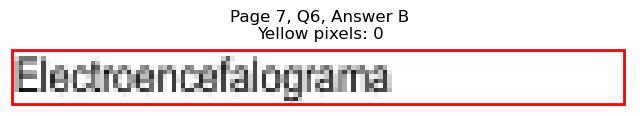

Page 7, Q6 - C: Detected box: x0=85.0, y0=603.2, x1=177.4, y1=615.3
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 485
Page 7, Q6, C: Yellow percentage: 0.0%


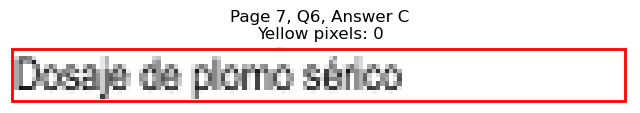

Page 7, Q6 - D: Detected box: x0=336.7, y0=579.1, x1=375.4, y1=591.2
Page 7, Q6, D: Yellow pixels: 944
Page 7, Q6, D: Total non-white pixels: 1170
Page 7, Q6, D: Yellow percentage: 80.7%


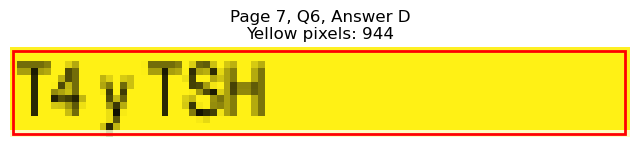

Page 7, Q6 - E: Detected box: x0=336.7, y0=591.2, x1=413.2, y1=603.3
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 483
Page 7, Q6, E: Yellow percentage: 0.0%


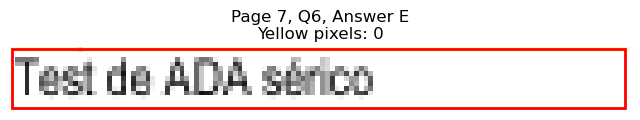


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=687.5, x1=175.9, y1=699.7
Page 7, Q7, A: Yellow pixels: 1468
Page 7, Q7, A: Total non-white pixels: 1846
Page 7, Q7, A: Yellow percentage: 79.5%


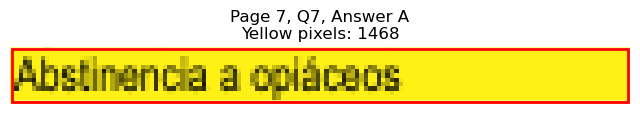

Page 7, Q7 - B: Detected box: x0=85.0, y0=699.5, x1=160.6, y1=711.7
Page 7, Q7, B: Yellow pixels: 127
Page 7, Q7, B: Total non-white pixels: 486
Page 7, Q7, B: Yellow percentage: 26.1%


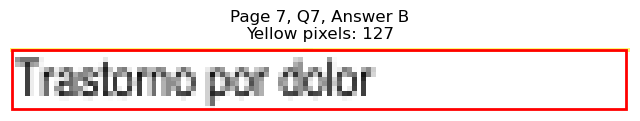

Page 7, Q7 - C: Detected box: x0=85.0, y0=711.7, x1=167.8, y1=723.8
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 388
Page 7, Q7, C: Yellow percentage: 0.0%


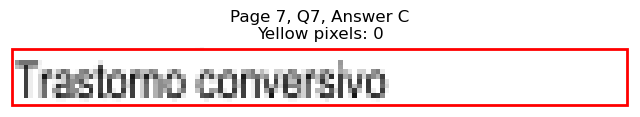

Page 7, Q7 - D: Detected box: x0=336.7, y0=687.5, x1=381.2, y1=699.7
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 227
Page 7, Q7, D: Yellow percentage: 0.0%


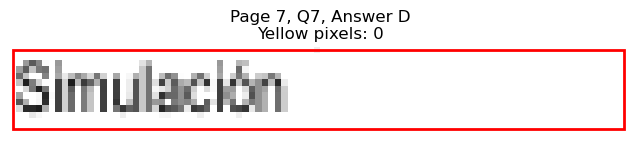

Page 7, Q7 - E: Detected box: x0=336.7, y0=699.5, x1=401.2, y1=711.7
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 311
Page 7, Q7, E: Yellow percentage: 0.0%


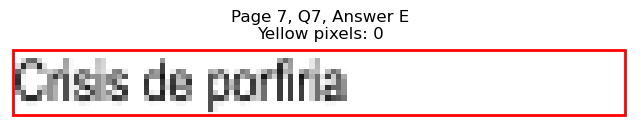


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=70.8, y0=747.8, x1=79.0, y1=759.9
Page 7, Q8, A: Yellow pixels: 660
Page 7, Q8, A: Total non-white pixels: 767
Page 7, Q8, A: Yellow percentage: 86.0%


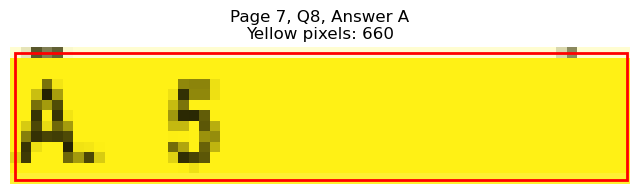

Page 7, Q8 - B: Detected box: x0=70.8, y0=759.8, x1=79.0, y1=771.9
Page 7, Q8, B: Yellow pixels: 59
Page 7, Q8, B: Total non-white pixels: 128
Page 7, Q8, B: Yellow percentage: 46.1%


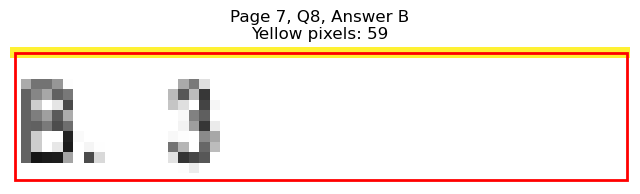

Page 7, Q8 - C: Detected box: x0=70.8, y0=771.9, x1=79.5, y1=784.0
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 68
Page 7, Q8, C: Yellow percentage: 0.0%


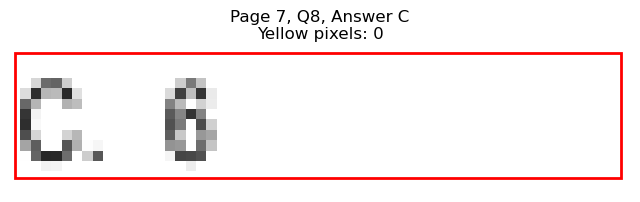

Page 7, Q8 - D: Detected box: x0=322.5, y0=747.8, x1=331.2, y1=759.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 60
Page 7, Q8, D: Yellow percentage: 0.0%


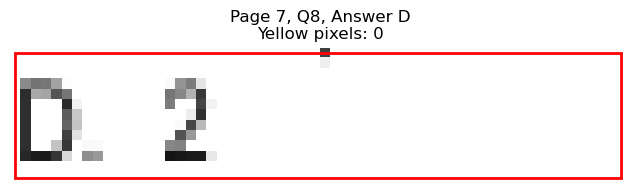

Page 7, Q8 - E: Detected box: x0=322.5, y0=759.8, x1=330.7, y1=771.9
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 62
Page 7, Q8, E: Yellow percentage: 0.0%


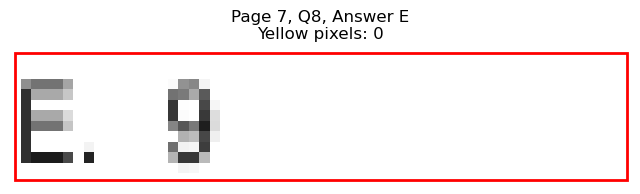


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=133.8, y1=133.3
Page 8, Q1, A: Yellow pixels: 982
Page 8, Q1, A: Total non-white pixels: 1300
Page 8, Q1, A: Yellow percentage: 75.5%


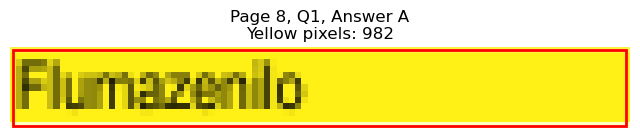

Page 8, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=126.1, y1=145.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 313
Page 8, Q1, B: Yellow percentage: 0.0%


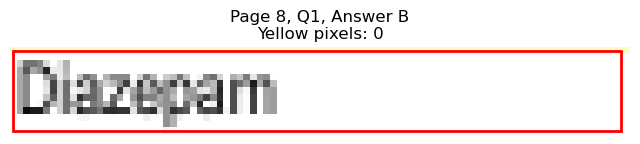

Page 8, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=148.2, y1=157.4
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 329
Page 8, Q1, C: Yellow percentage: 0.0%


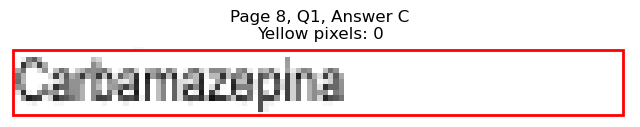

Page 8, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=397.0, y1=133.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 315
Page 8, Q1, D: Yellow percentage: 0.0%


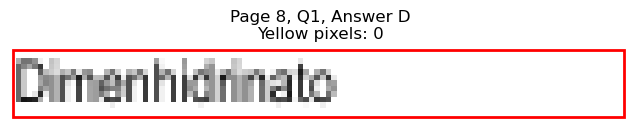

Page 8, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=377.4, y1=145.3
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 205
Page 8, Q1, E: Yellow percentage: 0.0%


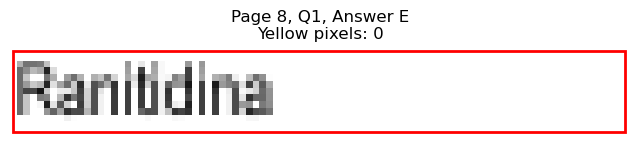


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=143.4, y1=193.5
Page 8, Q2, A: Yellow pixels: 1195
Page 8, Q2, A: Total non-white pixels: 1430
Page 8, Q2, A: Yellow percentage: 83.6%


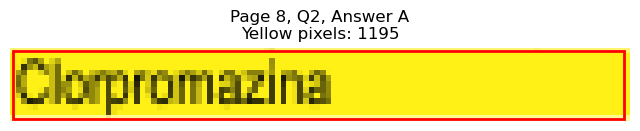

Page 8, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=131.9, y1=205.5
Page 8, Q2, B: Yellow pixels: 98
Page 8, Q2, B: Total non-white pixels: 351
Page 8, Q2, B: Yellow percentage: 27.9%


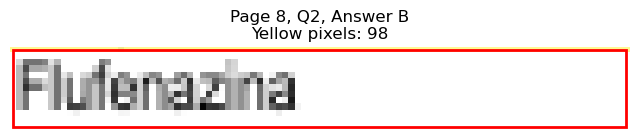

Page 8, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=130.9, y1=217.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 260
Page 8, Q2, C: Yellow percentage: 0.0%


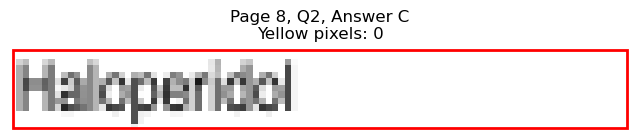

Page 8, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=396.1, y1=193.5
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 312
Page 8, Q2, D: Yellow percentage: 0.0%


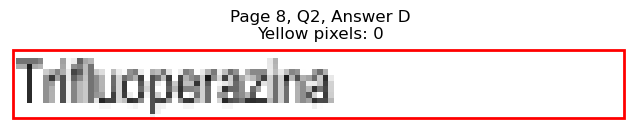

Page 8, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=385.0, y1=205.5
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 259
Page 8, Q2, E: Yellow percentage: 0.0%


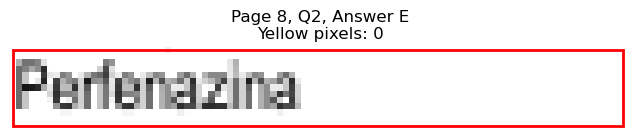


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=289.9, x1=225.3, y1=302.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 732
Page 8, Q3, A: Yellow percentage: 0.0%


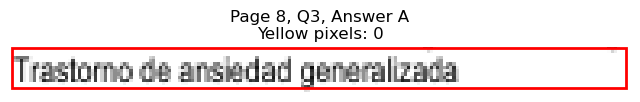

Page 8, Q3 - B: Detected box: x0=85.0, y0=301.9, x1=217.6, y1=314.0
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 708
Page 8, Q3, B: Yellow percentage: 0.0%


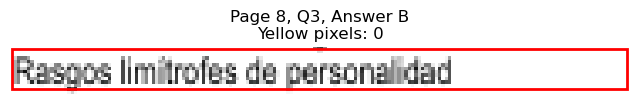

Page 8, Q3 - C: Detected box: x0=85.0, y0=313.9, x1=175.0, y1=326.0
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 475
Page 8, Q3, C: Yellow percentage: 0.0%


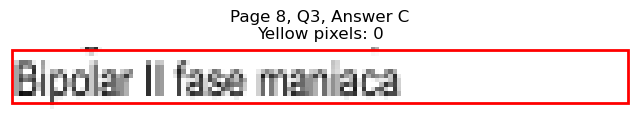

Page 8, Q3 - D: Detected box: x0=336.7, y0=289.9, x1=471.2, y1=302.0
Page 8, Q3, D: Yellow pixels: 1684
Page 8, Q3, D: Total non-white pixels: 2420
Page 8, Q3, D: Yellow percentage: 69.6%


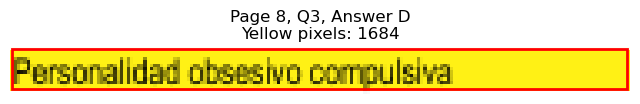

Page 8, Q3 - E: Detected box: x0=336.7, y0=301.9, x1=413.7, y1=314.0
Page 8, Q3, E: Yellow pixels: 126
Page 8, Q3, E: Total non-white pixels: 505
Page 8, Q3, E: Yellow percentage: 25.0%


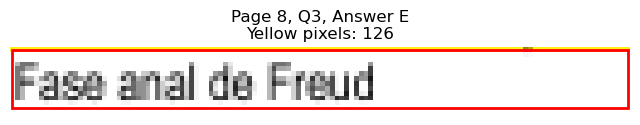


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=362.2, x1=130.9, y1=374.3
Page 8, Q4, A: Yellow pixels: 952
Page 8, Q4, A: Total non-white pixels: 1261
Page 8, Q4, A: Yellow percentage: 75.5%


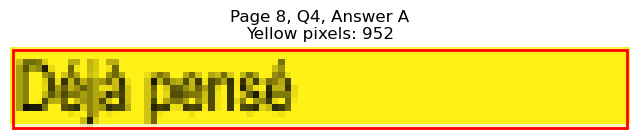

Page 8, Q4 - B: Detected box: x0=85.0, y0=374.2, x1=142.5, y1=386.3
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 413
Page 8, Q4, B: Yellow percentage: 0.0%


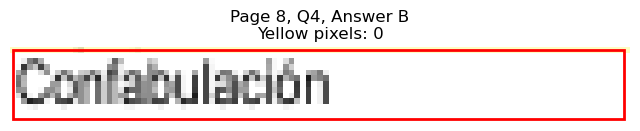

Page 8, Q4 - C: Detected box: x0=85.0, y0=386.3, x1=123.7, y1=398.4
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 197
Page 8, Q4, C: Yellow percentage: 0.0%


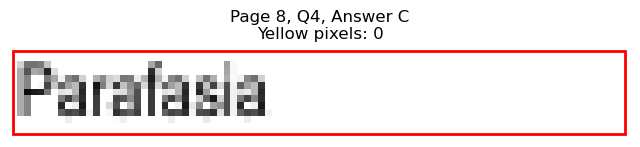

Page 8, Q4 - D: Detected box: x0=336.7, y0=362.2, x1=390.3, y1=374.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 277
Page 8, Q4, D: Yellow percentage: 0.0%


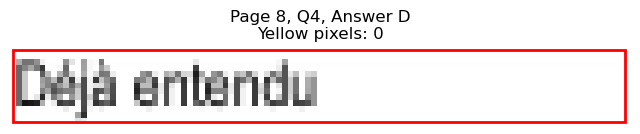

Page 8, Q4 - E: Detected box: x0=336.7, y0=374.2, x1=375.4, y1=386.3
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 199
Page 8, Q4, E: Yellow percentage: 0.0%


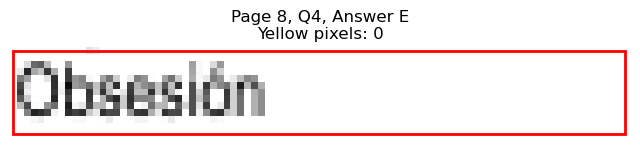


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=135.7, y1=434.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 261
Page 8, Q5, A: Yellow percentage: 0.0%


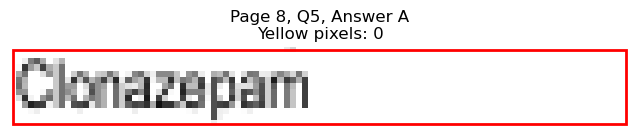

Page 8, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=129.0, y1=446.5
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 241
Page 8, Q5, B: Yellow percentage: 0.0%


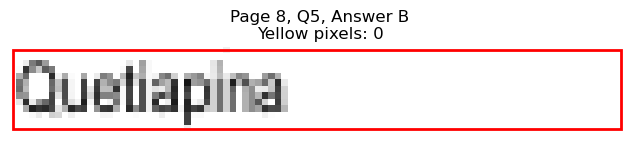

Page 8, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=129.0, y1=458.7
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 224
Page 8, Q5, C: Yellow percentage: 0.0%


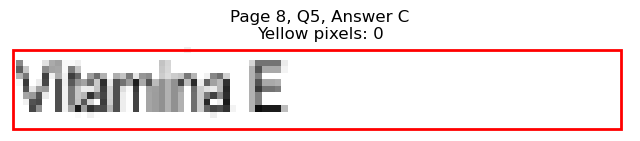

Page 8, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=384.6, y1=434.5
Page 8, Q5, D: Yellow pixels: 99
Page 8, Q5, D: Total non-white pixels: 339
Page 8, Q5, D: Yellow percentage: 29.2%


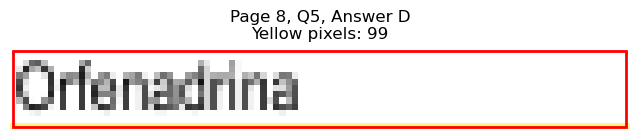

Page 8, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=392.2, y1=446.5
Page 8, Q5, E: Yellow pixels: 1153
Page 8, Q5, E: Total non-white pixels: 1391
Page 8, Q5, E: Yellow percentage: 82.9%


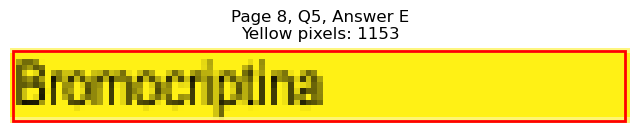


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=156.3, y1=506.8
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 364
Page 8, Q6, A: Yellow percentage: 0.0%


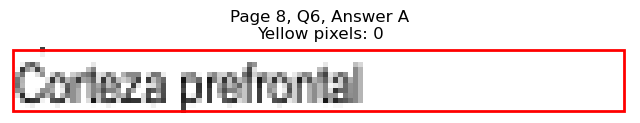

Page 8, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=130.9, y1=518.9
Page 8, Q6, B: Yellow pixels: 959
Page 8, Q6, B: Total non-white pixels: 1261
Page 8, Q6, B: Yellow percentage: 76.1%


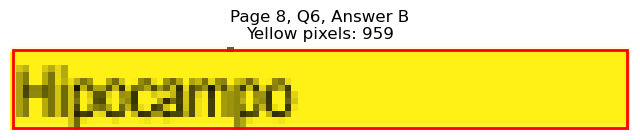

Page 8, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=144.9, y1=530.9
Page 8, Q6, C: Yellow pixels: 107
Page 8, Q6, C: Total non-white pixels: 406
Page 8, Q6, C: Yellow percentage: 26.4%


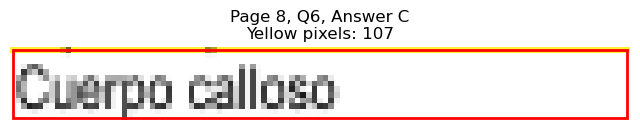

Page 8, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=382.6, y1=506.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 237
Page 8, Q6, D: Yellow percentage: 0.0%


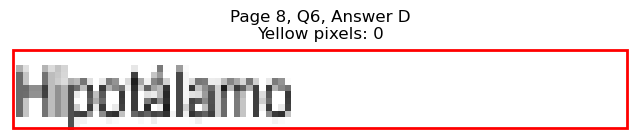

Page 8, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=399.9, y1=518.9
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 334
Page 8, Q6, E: Yellow percentage: 0.0%


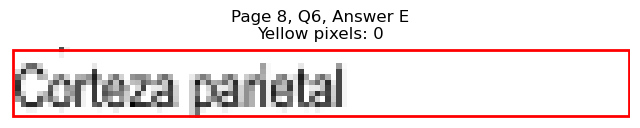


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=123.7, y1=567.0
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 221
Page 8, Q7, A: Yellow percentage: 0.0%


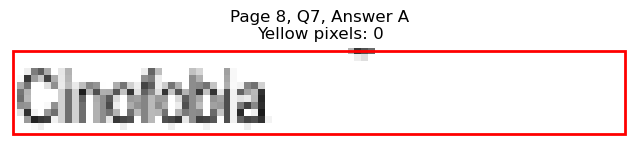

Page 8, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=128.1, y1=579.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 230
Page 8, Q7, B: Yellow percentage: 0.0%


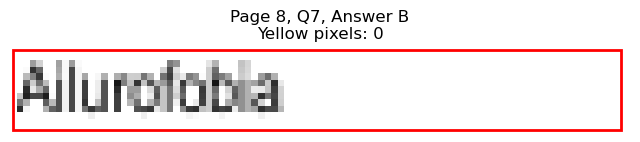

Page 8, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=124.2, y1=591.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 214
Page 8, Q7, C: Yellow percentage: 0.0%


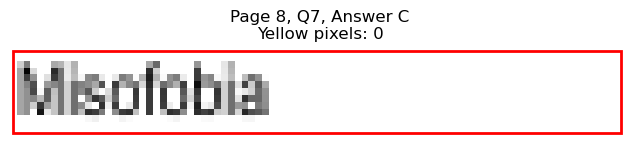

Page 8, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=375.4, y1=567.0
Page 8, Q7, D: Yellow pixels: 936
Page 8, Q7, D: Total non-white pixels: 1260
Page 8, Q7, D: Yellow percentage: 74.3%


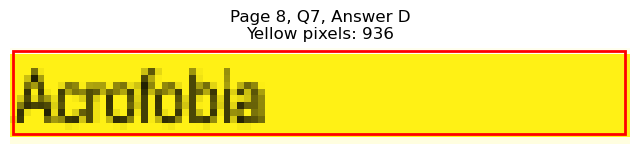

Page 8, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=377.4, y1=579.2
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 310
Page 8, Q7, E: Yellow percentage: 0.0%


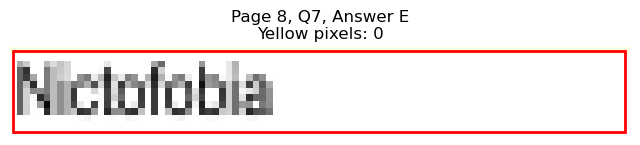


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=663.4, x1=132.9, y1=675.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 246
Page 8, Q8, A: Yellow percentage: 0.0%


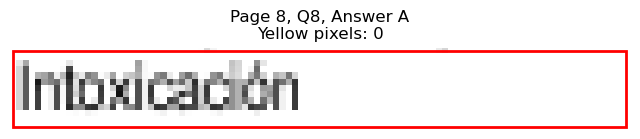

Page 8, Q8 - B: Detected box: x0=85.0, y0=675.4, x1=138.1, y1=687.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 281
Page 8, Q8, B: Yellow percentage: 0.0%


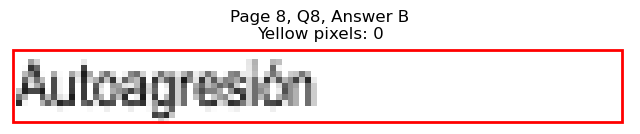

Page 8, Q8 - C: Detected box: x0=85.0, y0=687.5, x1=115.6, y1=699.7
Page 8, Q8, C: Yellow pixels: 957
Page 8, Q8, C: Total non-white pixels: 1066
Page 8, Q8, C: Yellow percentage: 89.8%


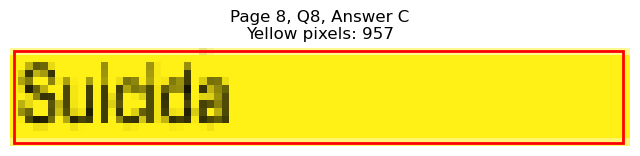

Page 8, Q8 - D: Detected box: x0=336.7, y0=663.4, x1=369.2, y1=675.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 174
Page 8, Q8, D: Yellow percentage: 0.0%


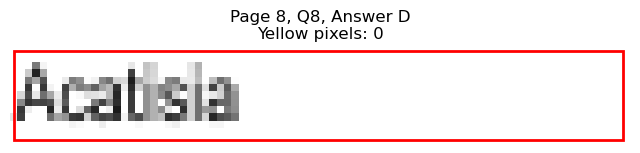

Page 8, Q8 - E: Detected box: x0=336.7, y0=675.4, x1=367.8, y1=687.5
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 158
Page 8, Q8, E: Yellow percentage: 0.0%


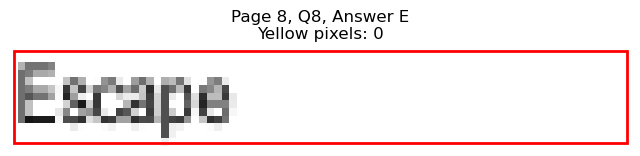


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=156.7, y1=145.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 359
Page 9, Q1, A: Yellow percentage: 0.0%


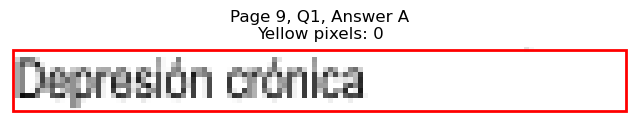

Page 9, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=164.9, y1=157.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 417
Page 9, Q1, B: Yellow percentage: 0.0%


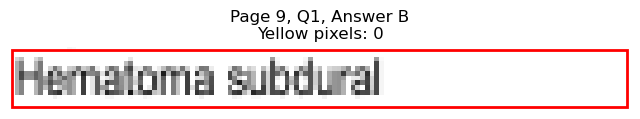

Page 9, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=221.5, y1=169.4
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 734
Page 9, Q1, C: Yellow percentage: 0.0%


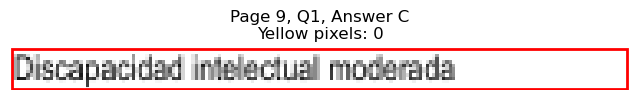

Page 9, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=411.0, y1=145.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 381
Page 9, Q1, D: Yellow percentage: 0.0%


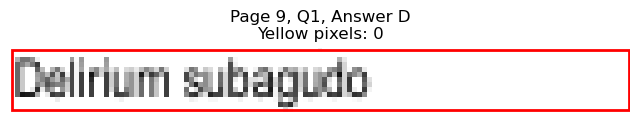

Page 9, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=422.8, y1=157.4
Page 9, Q1, E: Yellow pixels: 1287
Page 9, Q1, E: Total non-white pixels: 1781
Page 9, Q1, E: Yellow percentage: 72.3%


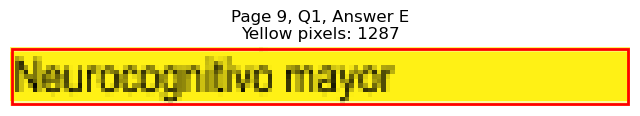


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=111.7, y1=205.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 126
Page 9, Q2, A: Yellow percentage: 0.0%


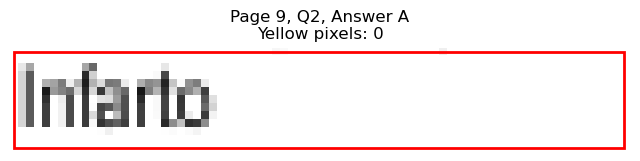

Page 9, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=117.0, y1=217.7
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 156
Page 9, Q2, B: Yellow percentage: 0.0%


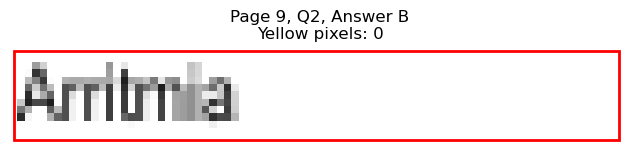

Page 9, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=134.3, y1=229.7
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 276
Page 9, Q2, C: Yellow percentage: 0.0%


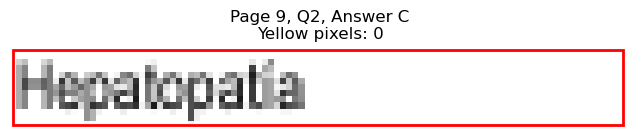

Page 9, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=366.8, y1=205.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 148
Page 9, Q2, D: Yellow percentage: 0.0%


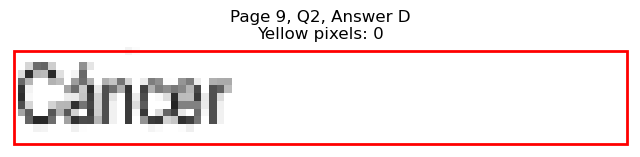

Page 9, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=369.2, y1=217.7
Page 9, Q2, E: Yellow pixels: 957
Page 9, Q2, E: Total non-white pixels: 1092
Page 9, Q2, E: Yellow percentage: 87.6%


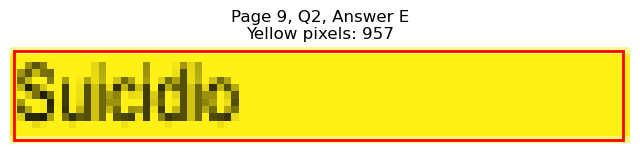


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=133.8, y1=289.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 244
Page 9, Q3, A: Yellow percentage: 0.0%


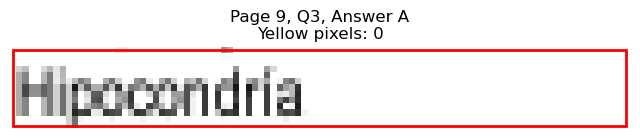

Page 9, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=109.0, y1=302.0
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 127
Page 9, Q3, B: Yellow percentage: 0.0%


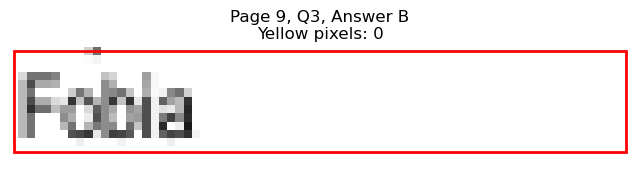

Page 9, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=129.0, y1=314.0
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 238
Page 9, Q3, C: Yellow percentage: 0.0%


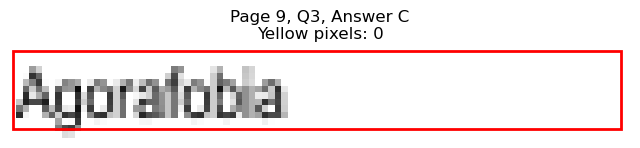

Page 9, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=365.4, y1=289.9
Page 9, Q3, D: Yellow pixels: 838
Page 9, Q3, D: Total non-white pixels: 1040
Page 9, Q3, D: Yellow percentage: 80.6%


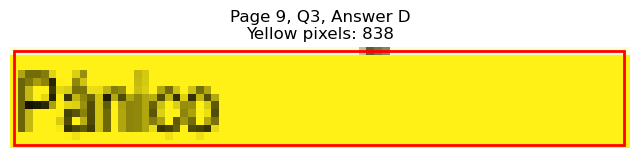

Page 9, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=384.6, y1=302.0
Page 9, Q3, E: Yellow pixels: 99
Page 9, Q3, E: Total non-white pixels: 336
Page 9, Q3, E: Yellow percentage: 29.5%


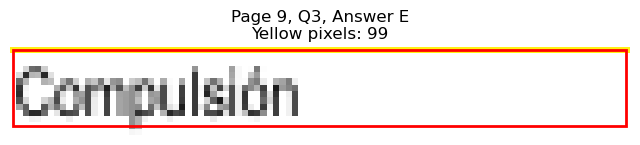


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=129.0, y1=350.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 223
Page 9, Q4, A: Yellow percentage: 0.0%


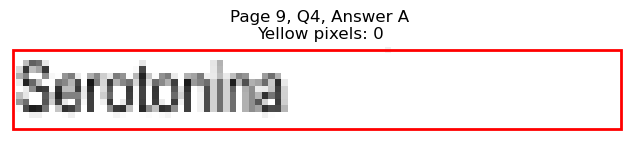

Page 9, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=125.7, y1=362.3
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 211
Page 9, Q4, B: Yellow percentage: 0.0%


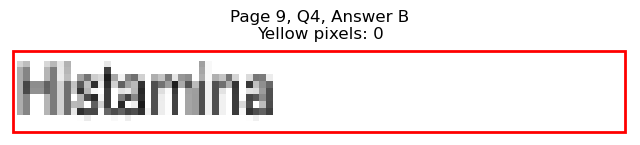

Page 9, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=111.3, y1=374.3
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 131
Page 9, Q4, C: Yellow percentage: 0.0%


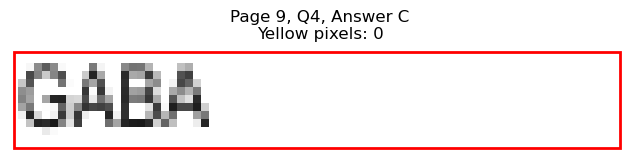

Page 9, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=378.3, y1=350.2
Page 9, Q4, D: Yellow pixels: 944
Page 9, Q4, D: Total non-white pixels: 1209
Page 9, Q4, D: Yellow percentage: 78.1%


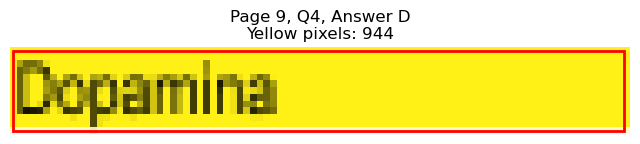

Page 9, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=390.3, y1=362.3
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 370
Page 9, Q4, E: Yellow percentage: 0.0%


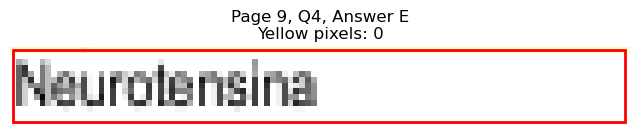


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=164.4, y1=422.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 420
Page 9, Q5, A: Yellow percentage: 0.0%


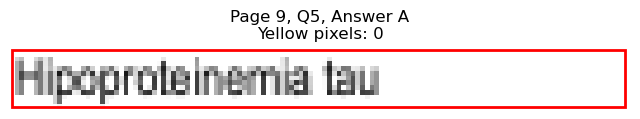

Page 9, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=142.1, y1=434.5
Page 9, Q5, B: Yellow pixels: 109
Page 9, Q5, B: Total non-white pixels: 439
Page 9, Q5, B: Yellow percentage: 24.8%


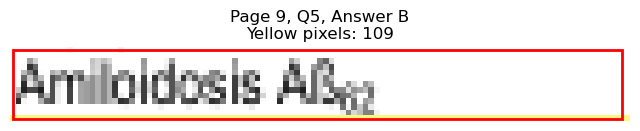

Page 9, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=160.1, y1=446.5
Page 9, Q5, C: Yellow pixels: 1341
Page 9, Q5, C: Total non-white pixels: 1651
Page 9, Q5, C: Yellow percentage: 81.2%


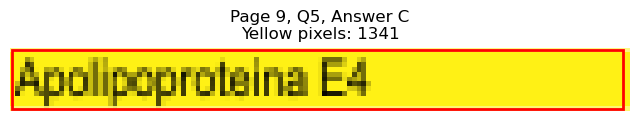

Page 9, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=408.4, y1=422.5
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 389
Page 9, Q5, D: Yellow percentage: 0.0%


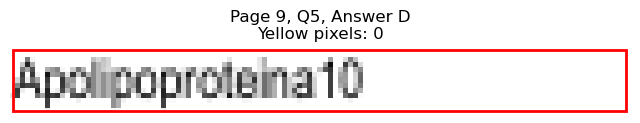

Page 9, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=383.1, y1=434.5
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 250
Page 9, Q5, E: Yellow percentage: 0.0%


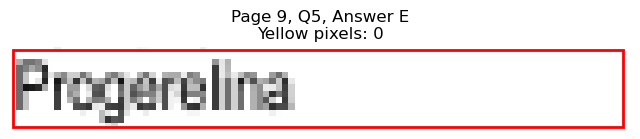


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=112.2, y1=482.8
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 204
Page 9, Q6, A: Yellow percentage: 0.0%


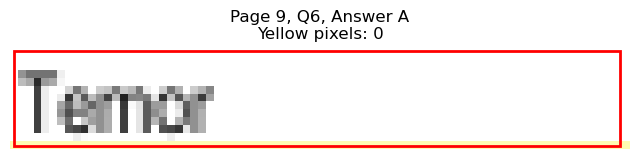

Page 9, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=134.3, y1=494.8
Page 9, Q6, B: Yellow pixels: 1003
Page 9, Q6, B: Total non-white pixels: 1313
Page 9, Q6, B: Yellow percentage: 76.4%


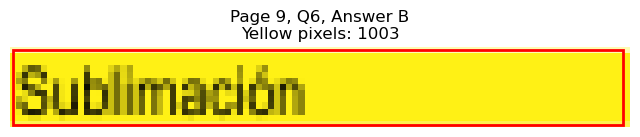

Page 9, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=131.9, y1=506.8
Page 9, Q6, C: Yellow pixels: 98
Page 9, Q6, C: Total non-white pixels: 341
Page 9, Q6, C: Yellow percentage: 28.7%


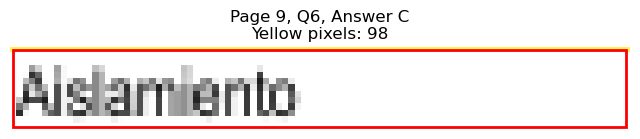

Page 9, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=383.1, y1=482.8
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 255
Page 9, Q6, D: Yellow percentage: 0.0%


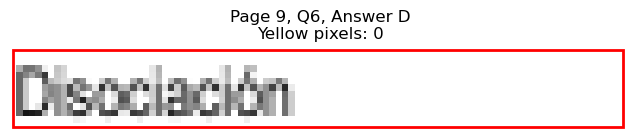

Page 9, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=395.6, y1=494.8
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 301
Page 9, Q6, E: Yellow percentage: 0.0%


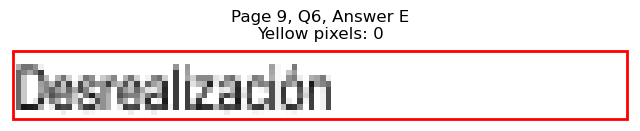


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=130.9, y1=567.0
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 253
Page 9, Q7, A: Yellow percentage: 0.0%


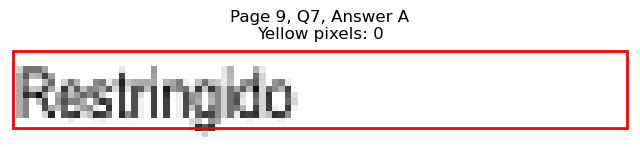

Page 9, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=120.4, y1=579.2
Page 9, Q7, B: Yellow pixels: 87
Page 9, Q7, B: Total non-white pixels: 280
Page 9, Q7, B: Yellow percentage: 31.1%


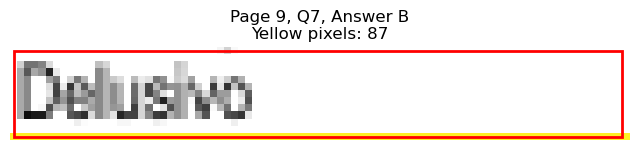

Page 9, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=132.4, y1=591.2
Page 9, Q7, C: Yellow pixels: 991
Page 9, Q7, C: Total non-white pixels: 1287
Page 9, Q7, C: Yellow percentage: 77.0%


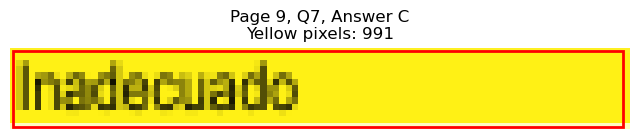

Page 9, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=368.2, y1=567.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 175
Page 9, Q7, D: Yellow percentage: 0.0%


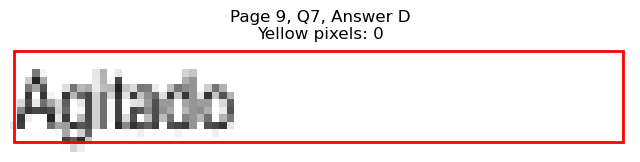

Page 9, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=375.4, y1=579.2
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 202
Page 9, Q7, E: Yellow percentage: 0.0%


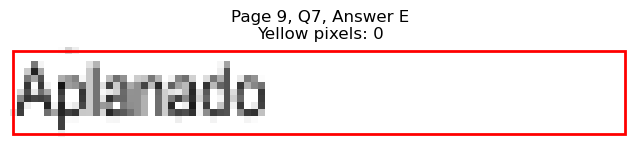


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=639.3, x1=199.4, y1=651.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 595
Page 9, Q8, A: Yellow percentage: 0.0%


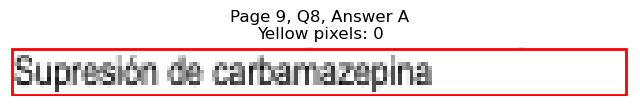

Page 9, Q8 - B: Detected box: x0=85.0, y0=651.4, x1=192.3, y1=663.5
Page 9, Q8, B: Yellow pixels: 159
Page 9, Q8, B: Total non-white pixels: 709
Page 9, Q8, B: Yellow percentage: 22.4%


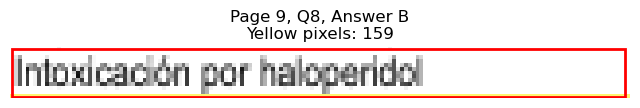

Page 9, Q8 - C: Detected box: x0=85.0, y0=663.4, x1=163.0, y1=675.5
Page 9, Q8, C: Yellow pixels: 1368
Page 9, Q8, C: Total non-white pixels: 1677
Page 9, Q8, C: Yellow percentage: 81.6%


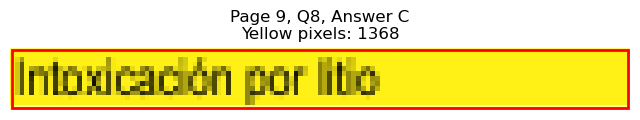

Page 9, Q8 - D: Detected box: x0=336.7, y0=639.3, x1=438.7, y1=651.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 511
Page 9, Q8, D: Yellow percentage: 0.0%


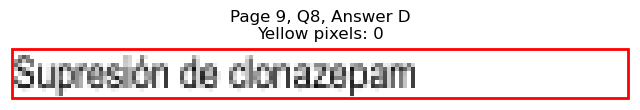

Page 9, Q8 - E: Detected box: x0=336.7, y0=651.4, x1=437.2, y1=663.5
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 501
Page 9, Q8, E: Yellow percentage: 0.0%


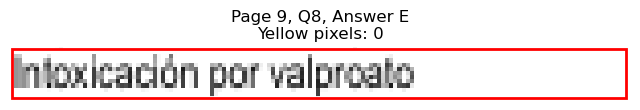


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=128.5, y1=711.7
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 227
Page 9, Q9, A: Yellow percentage: 0.0%


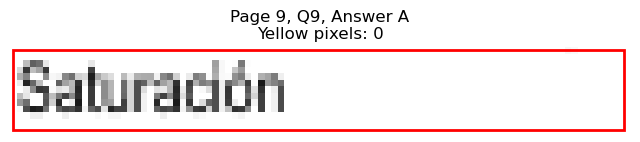

Page 9, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=133.3, y1=723.8
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 249
Page 9, Q9, B: Yellow percentage: 0.0%


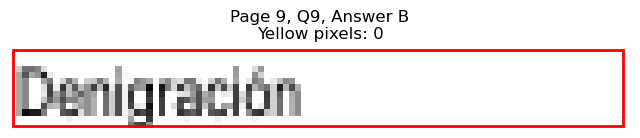

Page 9, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=128.1, y1=735.8
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 230
Page 9, Q9, C: Yellow percentage: 0.0%


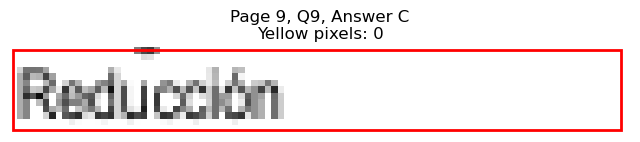

Page 9, Q9 - D: Detected box: x0=336.7, y0=699.5, x1=374.0, y1=711.7
Page 9, Q9, D: Yellow pixels: 968
Page 9, Q9, D: Total non-white pixels: 1144
Page 9, Q9, D: Yellow percentage: 84.6%


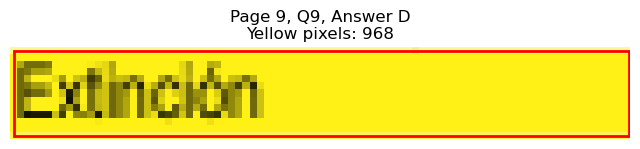

Page 9, Q9 - E: Detected box: x0=336.7, y0=711.7, x1=380.4, y1=723.8
Page 9, Q9, E: Yellow pixels: 95
Page 9, Q9, E: Total non-white pixels: 331
Page 9, Q9, E: Yellow percentage: 28.7%


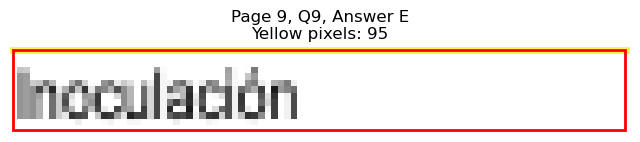


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=157.3, x1=121.8, y1=169.4
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 183
Page 10, Q1, A: Yellow percentage: 0.0%


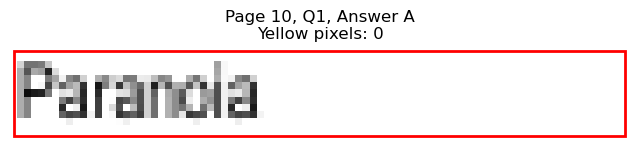

Page 10, Q1 - B: Detected box: x0=85.0, y0=169.4, x1=166.8, y1=181.5
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 384
Page 10, Q1, B: Yellow percentage: 0.0%


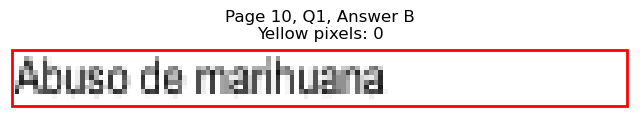

Page 10, Q1 - C: Detected box: x0=85.0, y0=181.4, x1=142.0, y1=193.5
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 332
Page 10, Q1, C: Yellow percentage: 0.0%


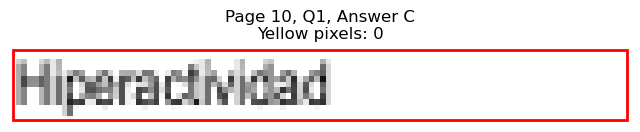

Page 10, Q1 - D: Detected box: x0=336.7, y0=157.3, x1=430.0, y1=169.4
Page 10, Q1, D: Yellow pixels: 1494
Page 10, Q1, D: Total non-white pixels: 1885
Page 10, Q1, D: Yellow percentage: 79.3%


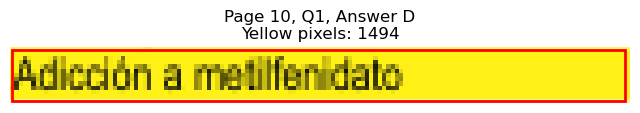

Page 10, Q1 - E: Detected box: x0=336.7, y0=169.4, x1=426.2, y1=181.5
Page 10, Q1, E: Yellow pixels: 141
Page 10, Q1, E: Total non-white pixels: 608
Page 10, Q1, E: Yellow percentage: 23.2%


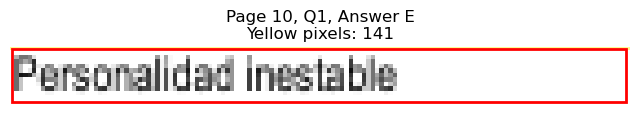


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=265.8, x1=137.2, y1=277.9
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 267
Page 10, Q2, A: Yellow percentage: 0.0%


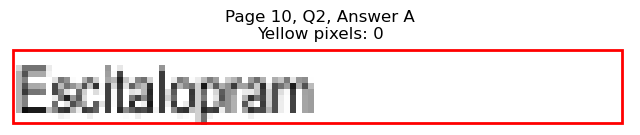

Page 10, Q2 - B: Detected box: x0=85.0, y0=277.8, x1=135.7, y1=289.9
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 248
Page 10, Q2, B: Yellow percentage: 0.0%


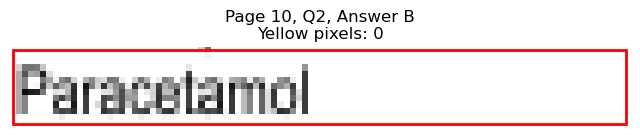

Page 10, Q2 - C: Detected box: x0=85.0, y0=289.9, x1=126.6, y1=302.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 224
Page 10, Q2, C: Yellow percentage: 0.0%


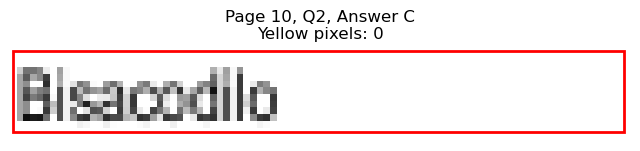

Page 10, Q2 - D: Detected box: x0=336.7, y0=265.8, x1=390.3, y1=277.9
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 358
Page 10, Q2, D: Yellow percentage: 0.0%


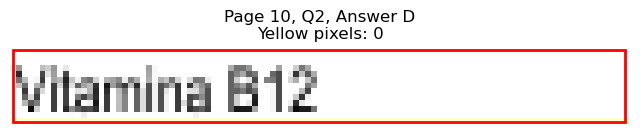

Page 10, Q2 - E: Detected box: x0=336.7, y0=277.8, x1=382.2, y1=289.9
Page 10, Q2, E: Yellow pixels: 973
Page 10, Q2, E: Total non-white pixels: 1261
Page 10, Q2, E: Yellow percentage: 77.2%


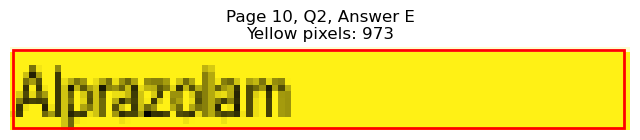


Page 10, Q2 - Selected Answer: E (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=362.2, x1=167.8, y1=374.3
Page 10, Q3, A: Yellow pixels: 134
Page 10, Q3, A: Total non-white pixels: 556
Page 10, Q3, A: Yellow percentage: 24.1%


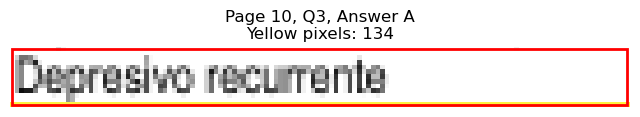

Page 10, Q3 - B: Detected box: x0=85.0, y0=374.2, x1=173.5, y1=386.3
Page 10, Q3, B: Yellow pixels: 1313
Page 10, Q3, B: Total non-white pixels: 1820
Page 10, Q3, B: Yellow percentage: 72.1%


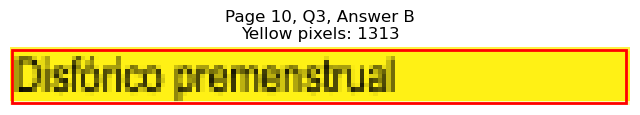

Page 10, Q3 - C: Detected box: x0=85.0, y0=386.3, x1=164.9, y1=398.4
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 524
Page 10, Q3, C: Yellow percentage: 0.0%


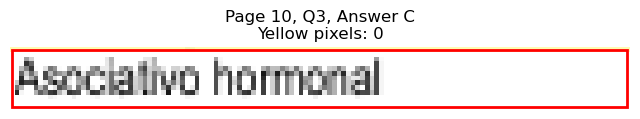

Page 10, Q3 - D: Detected box: x0=336.7, y0=362.2, x1=412.8, y1=374.3
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 406
Page 10, Q3, D: Yellow percentage: 0.0%


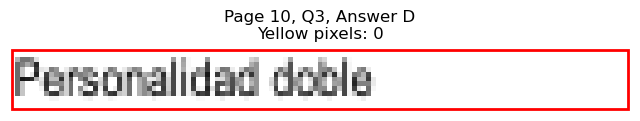

Page 10, Q3 - E: Detected box: x0=336.7, y0=374.2, x1=370.6, y1=386.3
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 175
Page 10, Q3, E: Yellow percentage: 0.0%


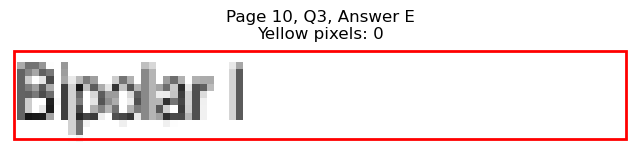


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=422.4, x1=208.5, y1=434.5
Page 10, Q4, A: Yellow pixels: 1748
Page 10, Q4, A: Total non-white pixels: 2275
Page 10, Q4, A: Yellow percentage: 76.8%


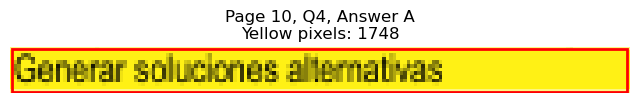

Page 10, Q4 - B: Detected box: x0=85.0, y0=434.4, x1=212.8, y1=446.5
Page 10, Q4, B: Yellow pixels: 179
Page 10, Q4, B: Total non-white pixels: 826
Page 10, Q4, B: Yellow percentage: 21.7%


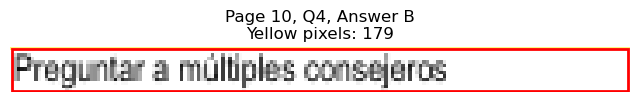

Page 10, Q4 - C: Detected box: x0=85.0, y0=446.6, x1=231.9, y1=458.7
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 741
Page 10, Q4, C: Yellow percentage: 0.0%


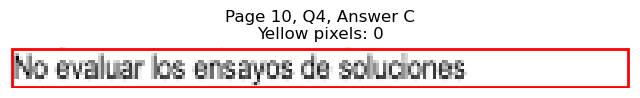

Page 10, Q4 - D: Detected box: x0=336.7, y0=422.4, x1=469.3, y1=434.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 704
Page 10, Q4, D: Yellow percentage: 0.0%


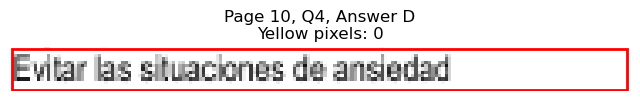

Page 10, Q4 - E: Detected box: x0=336.7, y0=434.4, x1=416.1, y1=446.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 398
Page 10, Q4, E: Yellow percentage: 0.0%


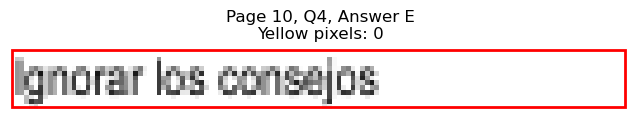


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=494.7, x1=132.4, y1=506.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 246
Page 10, Q5, A: Yellow percentage: 0.0%


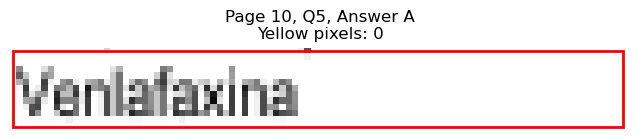

Page 10, Q5 - B: Detected box: x0=85.0, y0=506.8, x1=128.5, y1=518.9
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 215
Page 10, Q5, B: Yellow percentage: 0.0%


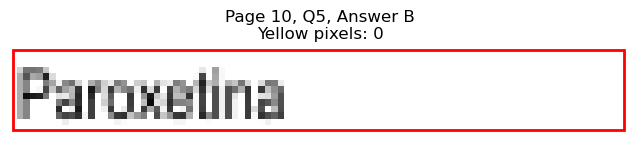

Page 10, Q5 - C: Detected box: x0=85.0, y0=518.8, x1=130.9, y1=530.9
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 259
Page 10, Q5, C: Yellow percentage: 0.0%


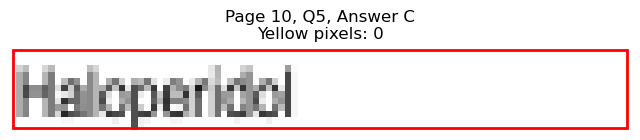

Page 10, Q5 - D: Detected box: x0=336.7, y0=494.7, x1=387.0, y1=506.8
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 254
Page 10, Q5, D: Yellow percentage: 0.0%


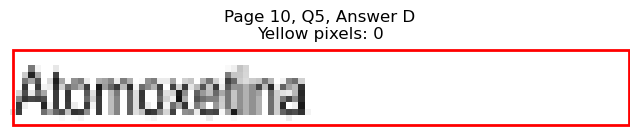

Page 10, Q5 - E: Detected box: x0=336.7, y0=506.8, x1=378.3, y1=518.9
Page 10, Q5, E: Yellow pixels: 936
Page 10, Q5, E: Total non-white pixels: 1209
Page 10, Q5, E: Yellow percentage: 77.4%


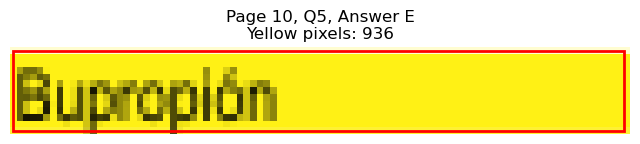


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=567.1, x1=124.2, y1=579.2
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 207
Page 10, Q6, A: Yellow percentage: 0.0%


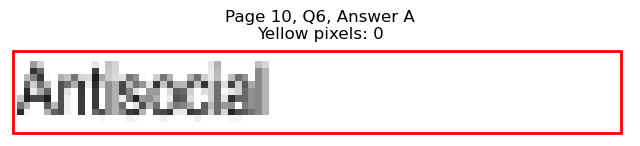

Page 10, Q6 - B: Detected box: x0=85.0, y0=579.1, x1=118.5, y1=591.2
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 183
Page 10, Q6, B: Yellow percentage: 0.0%


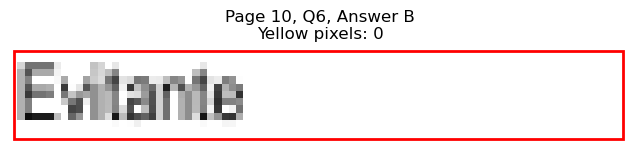

Page 10, Q6 - C: Detected box: x0=85.0, y0=591.2, x1=110.8, y1=603.3
Page 10, Q6, C: Yellow pixels: 820
Page 10, Q6, C: Total non-white pixels: 1001
Page 10, Q6, C: Yellow percentage: 81.9%


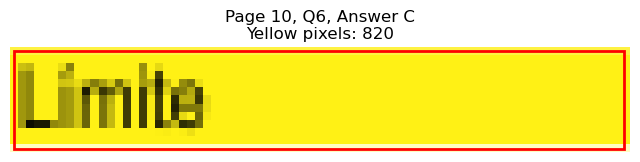

Page 10, Q6 - D: Detected box: x0=336.7, y0=567.1, x1=378.3, y1=579.2
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 210
Page 10, Q6, D: Yellow percentage: 0.0%


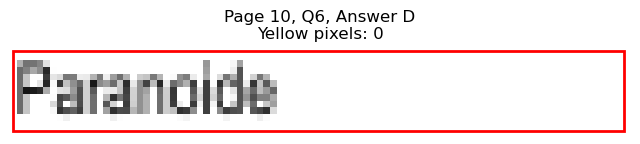

Page 10, Q6 - E: Detected box: x0=336.7, y0=579.1, x1=386.0, y1=591.2
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 255
Page 10, Q6, E: Yellow percentage: 0.0%


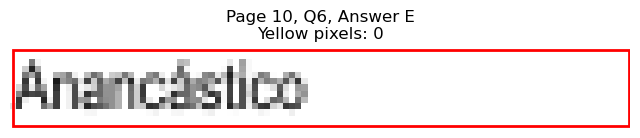


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=627.3, x1=163.5, y1=639.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 431
Page 10, Q7, A: Yellow percentage: 0.0%


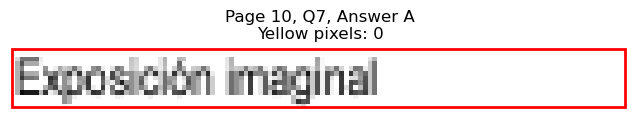

Page 10, Q7 - B: Detected box: x0=85.0, y0=639.3, x1=153.9, y1=651.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 391
Page 10, Q7, B: Yellow percentage: 0.0%


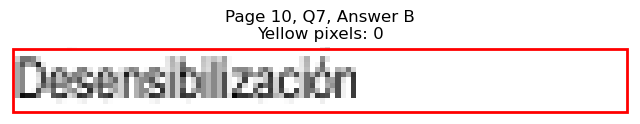

Page 10, Q7 - C: Detected box: x0=85.0, y0=651.4, x1=135.7, y1=663.5
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 282
Page 10, Q7, C: Yellow percentage: 0.0%


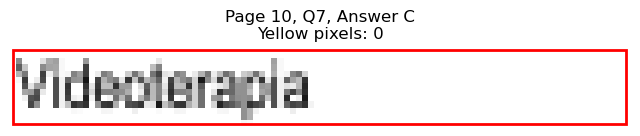

Page 10, Q7 - D: Detected box: x0=336.7, y0=627.3, x1=398.5, y1=639.4
Page 10, Q7, D: Yellow pixels: 1090
Page 10, Q7, D: Total non-white pixels: 1469
Page 10, Q7, D: Yellow percentage: 74.2%


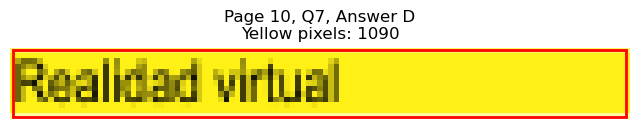

Page 10, Q7 - E: Detected box: x0=336.7, y0=639.3, x1=400.9, y1=651.4
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 439
Page 10, Q7, E: Yellow percentage: 0.0%


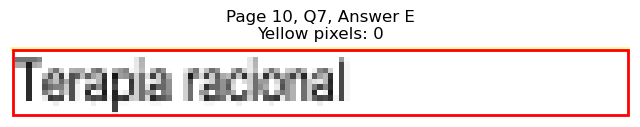


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=699.5, x1=138.6, y1=711.7
Page 10, Q8, A: Yellow pixels: 1138
Page 10, Q8, A: Total non-white pixels: 1365
Page 10, Q8, A: Yellow percentage: 83.4%


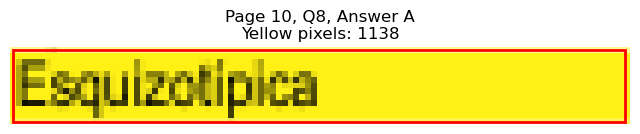

Page 10, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=118.5, y1=591.2
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 183
Page 10, Q8, B: Yellow percentage: 0.0%


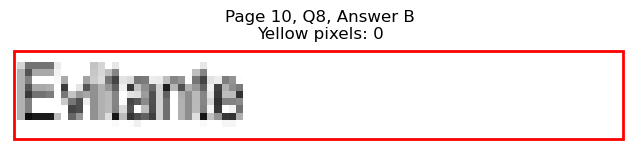

Page 10, Q8 - C: Detected box: x0=85.0, y0=723.7, x1=122.3, y1=735.8
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 195
Page 10, Q8, C: Yellow percentage: 0.0%


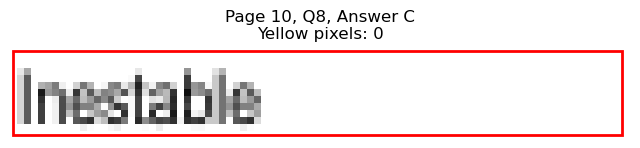

Page 10, Q8 - D: Detected box: x0=336.7, y0=699.5, x1=386.0, y1=711.7
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 258
Page 10, Q8, D: Yellow percentage: 0.0%


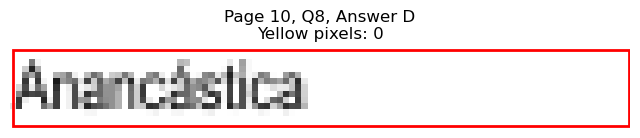

Page 10, Q8 - E: Detected box: x0=336.7, y0=711.7, x1=378.3, y1=723.8
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 210
Page 10, Q8, E: Yellow percentage: 0.0%


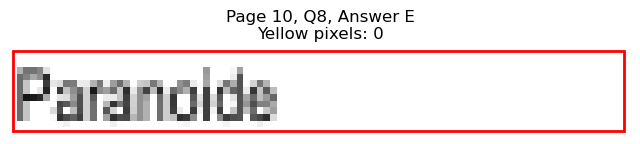


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=163.0, y1=109.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 406
Page 11, Q1, A: Yellow percentage: 0.0%


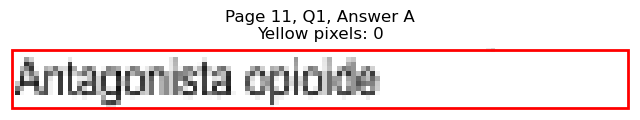

Page 11, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=148.6, y1=121.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 327
Page 11, Q1, B: Yellow percentage: 0.0%


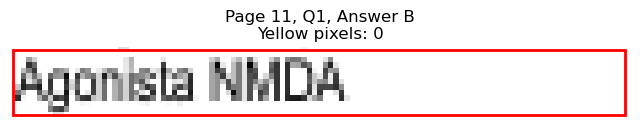

Page 11, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=160.6, y1=133.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 378
Page 11, Q1, C: Yellow percentage: 0.0%


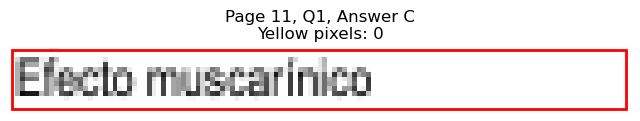

Page 11, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=412.3, y1=109.2
Page 11, Q1, D: Yellow pixels: 1191
Page 11, Q1, D: Total non-white pixels: 1651
Page 11, Q1, D: Yellow percentage: 72.1%


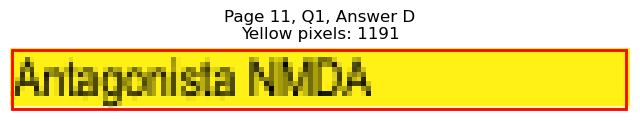

Page 11, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=431.5, y1=121.3
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 651
Page 11, Q1, E: Yellow percentage: 0.0%


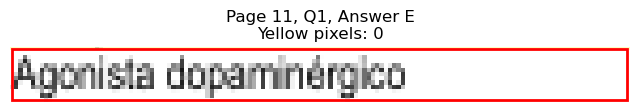


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=139.6, y1=217.7
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 275
Page 11, Q2, A: Yellow percentage: 0.0%


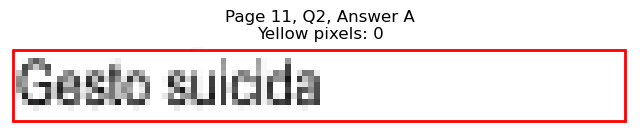

Page 11, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=138.1, y1=229.7
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 302
Page 11, Q2, B: Yellow percentage: 0.0%


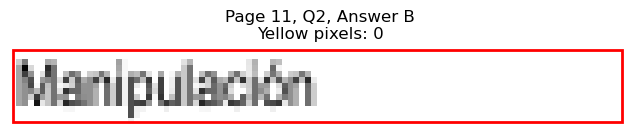

Page 11, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=159.1, y1=241.8
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 374
Page 11, Q2, C: Yellow percentage: 0.0%


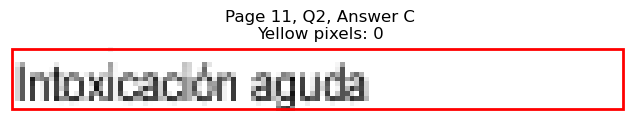

Page 11, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=379.3, y1=217.7
Page 11, Q2, D: Yellow pixels: 94
Page 11, Q2, D: Total non-white pixels: 300
Page 11, Q2, D: Yellow percentage: 31.3%


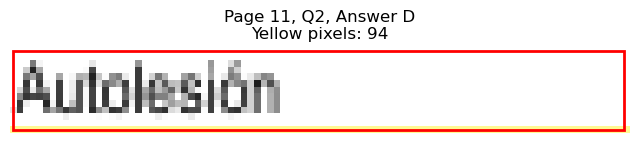

Page 11, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=417.6, y1=229.7
Page 11, Q2, E: Yellow pixels: 1408
Page 11, Q2, E: Total non-white pixels: 1716
Page 11, Q2, E: Yellow percentage: 82.1%


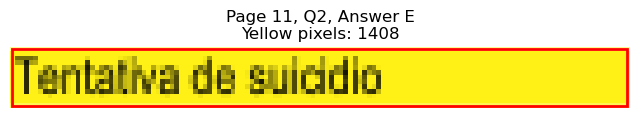


Page 11, Q2 - Selected Answer: E (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=151.5, y1=289.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 351
Page 11, Q3, A: Yellow percentage: 0.0%


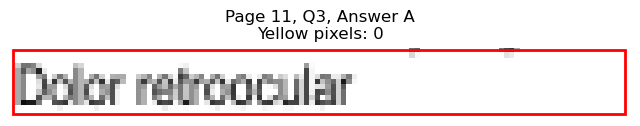

Page 11, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=126.1, y1=302.0
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 213
Page 11, Q3, B: Yellow percentage: 0.0%


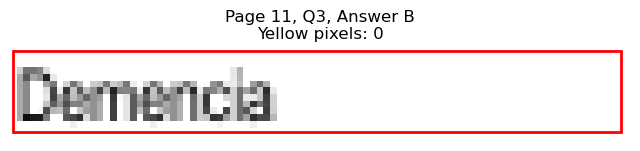

Page 11, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=136.7, y1=314.0
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 275
Page 11, Q3, C: Yellow percentage: 0.0%


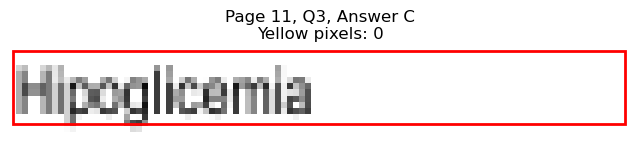

Page 11, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=383.6, y1=289.9
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 235
Page 11, Q3, D: Yellow percentage: 0.0%


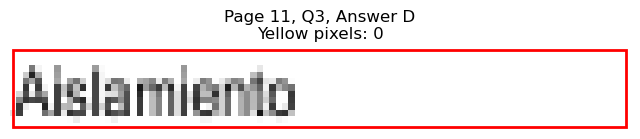

Page 11, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=429.1, y1=302.0
Page 11, Q3, E: Yellow pixels: 1337
Page 11, Q3, E: Total non-white pixels: 1873
Page 11, Q3, E: Yellow percentage: 71.4%


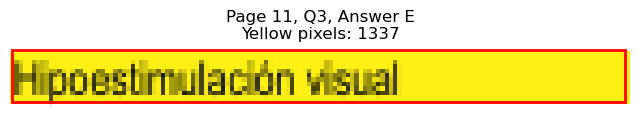


Page 11, Q3 - Selected Answer: E (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=121.3, y1=350.2
Page 11, Q4, A: Yellow pixels: 890
Page 11, Q4, A: Total non-white pixels: 1144
Page 11, Q4, A: Yellow percentage: 77.8%


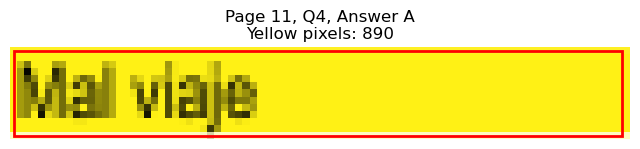

Page 11, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=118.9, y1=362.3
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 265
Page 11, Q4, B: Yellow percentage: 0.0%


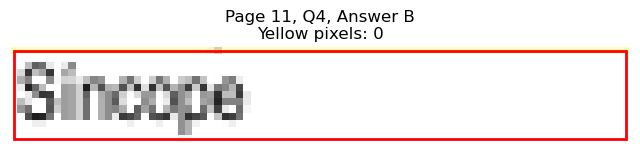

Page 11, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=114.1, y1=374.3
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 162
Page 11, Q4, C: Yellow percentage: 0.0%


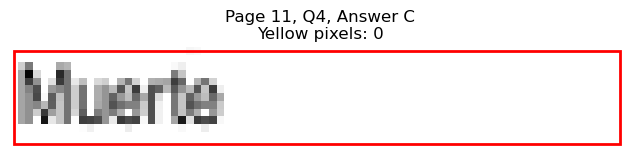

Page 11, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=363.4, y1=350.2
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 148
Page 11, Q4, D: Yellow percentage: 0.0%


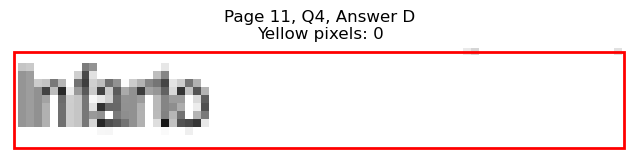

Page 11, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=370.2, y1=362.3
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 158
Page 11, Q4, E: Yellow percentage: 0.0%


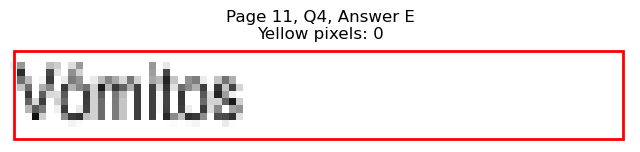


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=202.7, y1=410.4
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 617
Page 11, Q5, A: Yellow percentage: 0.0%


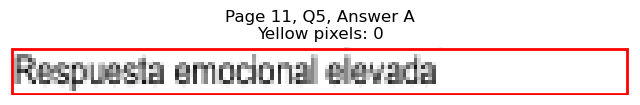

Page 11, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=174.5, y1=422.5
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 486
Page 11, Q5, B: Yellow percentage: 0.0%


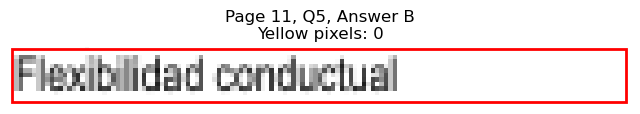

Page 11, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=195.2, y1=434.5
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 570
Page 11, Q5, C: Yellow percentage: 0.0%


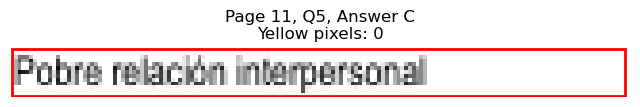

Page 11, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=491.7, y1=410.4
Page 11, Q5, D: Yellow pixels: 1843
Page 11, Q5, D: Total non-white pixels: 2470
Page 11, Q5, D: Yellow percentage: 74.6%


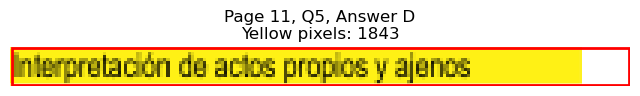

Page 11, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=458.7, y1=422.5
Page 11, Q5, E: Yellow pixels: 173
Page 11, Q5, E: Total non-white pixels: 745
Page 11, Q5, E: Yellow percentage: 23.2%


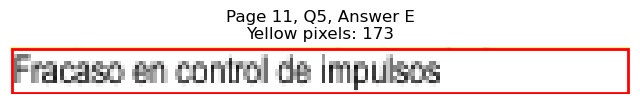


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=178.3, y1=506.8
Page 11, Q6, A: Yellow pixels: 1345
Page 11, Q6, A: Total non-white pixels: 1885
Page 11, Q6, A: Yellow percentage: 71.4%


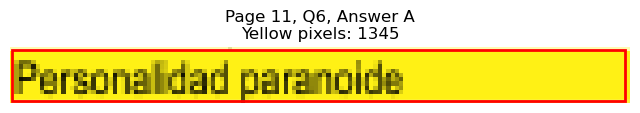

Page 11, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=172.1, y1=518.9
Page 11, Q6, B: Yellow pixels: 138
Page 11, Q6, B: Total non-white pixels: 594
Page 11, Q6, B: Yellow percentage: 23.2%


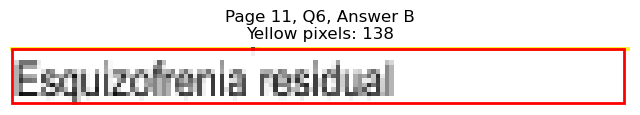

Page 11, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=162.5, y1=530.9
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 394
Page 11, Q6, C: Yellow percentage: 0.0%


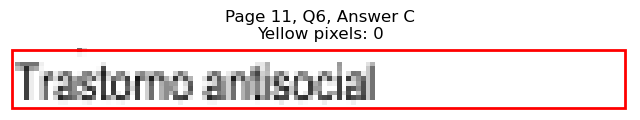

Page 11, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=442.5, y1=506.8
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 545
Page 11, Q6, D: Yellow percentage: 0.0%


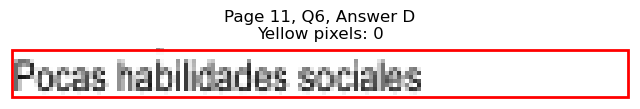

Page 11, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=398.0, y1=518.9
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 312
Page 11, Q6, E: Yellow percentage: 0.0%


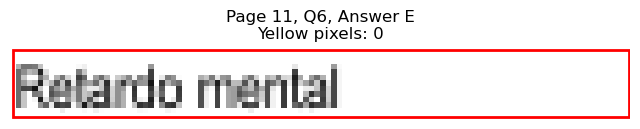


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=118.5, y1=603.3
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 175
Page 11, Q7, A: Yellow percentage: 0.0%


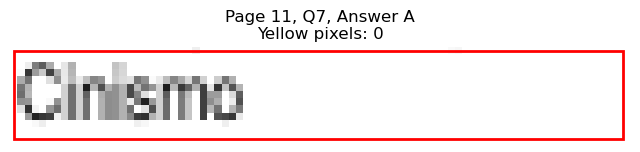

Page 11, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=160.6, y1=615.3
Page 11, Q7, B: Yellow pixels: 127
Page 11, Q7, B: Total non-white pixels: 480
Page 11, Q7, B: Yellow percentage: 26.5%


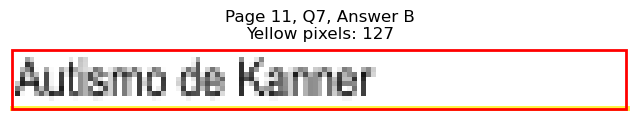

Page 11, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=175.9, y1=627.3
Page 11, Q7, C: Yellow pixels: 1325
Page 11, Q7, C: Total non-white pixels: 1846
Page 11, Q7, C: Yellow percentage: 71.8%


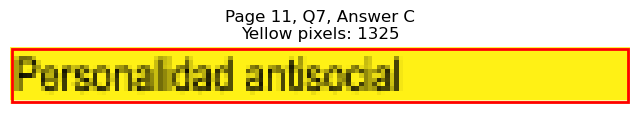

Page 11, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=387.0, y1=603.3
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 256
Page 11, Q7, D: Yellow percentage: 0.0%


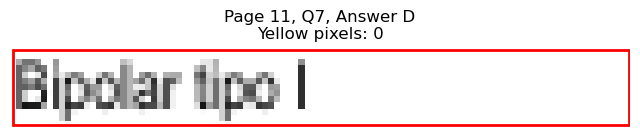

Page 11, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=418.5, y1=615.3
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 427
Page 11, Q7, E: Yellow percentage: 0.0%


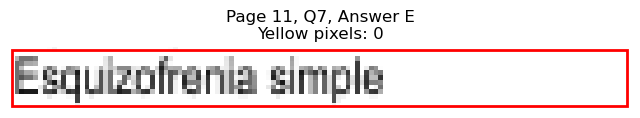


Page 11, Q7 - Selected Answer: C (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=210.9, y1=663.5
Page 11, Q8, A: Yellow pixels: 177
Page 11, Q8, A: Total non-white pixels: 827
Page 11, Q8, A: Yellow percentage: 21.4%


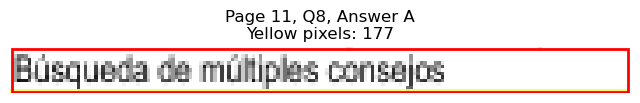

Page 11, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=250.1, y1=675.5
Page 11, Q8, B: Yellow pixels: 1787
Page 11, Q8, B: Total non-white pixels: 2483
Page 11, Q8, B: Yellow percentage: 72.0%


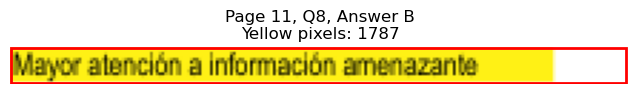

Page 11, Q8 - C: Detected box: x0=118.0, y0=675.4, x1=176.9, y1=687.5
Page 11, Q8, C: Yellow pixels: 110
Page 11, Q8, C: Total non-white pixels: 615
Page 11, Q8, C: Yellow percentage: 17.9%


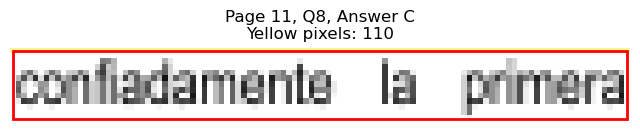

Page 11, Q8 - D: Detected box: x0=336.7, y0=651.4, x1=520.1, y1=663.5
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 926
Page 11, Q8, D: Yellow percentage: 0.0%


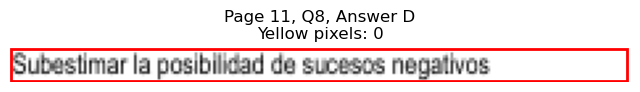

Page 11, Q8 - E: Detected box: x0=336.7, y0=663.4, x1=486.0, y1=675.5
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 758
Page 11, Q8, E: Yellow percentage: 0.0%


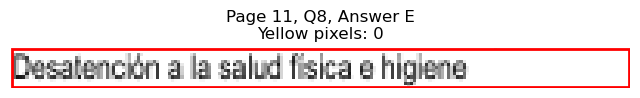


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=85.0, y0=723.7, x1=144.9, y1=735.8
Page 11, Q9, A: Yellow pixels: 0
Page 11, Q9, A: Total non-white pixels: 321
Page 11, Q9, A: Yellow percentage: 0.0%


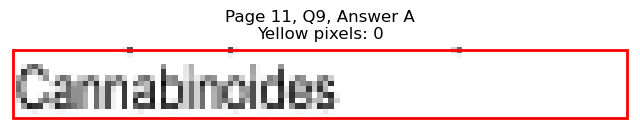

Page 11, Q9 - B: Detected box: x0=85.0, y0=735.8, x1=128.1, y1=747.9
Page 11, Q9, B: Yellow pixels: 951
Page 11, Q9, B: Total non-white pixels: 1235
Page 11, Q9, B: Yellow percentage: 77.0%


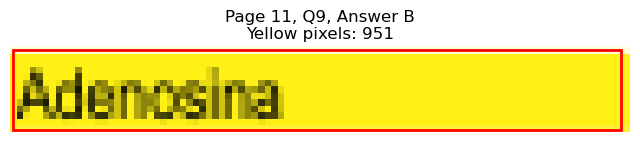

Page 11, Q9 - C: Detected box: x0=85.0, y0=747.8, x1=146.8, y1=759.9
Page 11, Q9, C: Yellow pixels: 113
Page 11, Q9, C: Total non-white pixels: 430
Page 11, Q9, C: Yellow percentage: 26.3%


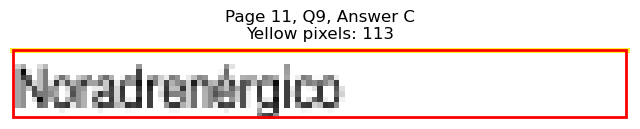

Page 11, Q9 - D: Detected box: x0=336.7, y0=723.7, x1=387.9, y1=735.8
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 275
Page 11, Q9, D: Yellow percentage: 0.0%


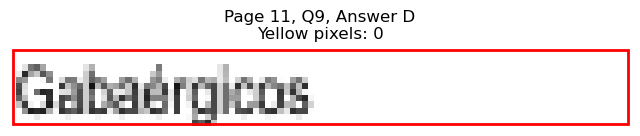

Page 11, Q9 - E: Detected box: x0=336.7, y0=735.8, x1=398.0, y1=747.9
Page 11, Q9, E: Yellow pixels: 0
Page 11, Q9, E: Total non-white pixels: 346
Page 11, Q9, E: Yellow percentage: 0.0%


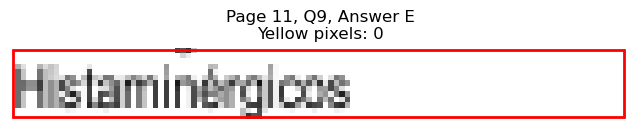


Page 11, Q9 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 6 questions
Page 12, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=126.1, y1=109.2
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 221
Page 12, Q1, A: Yellow percentage: 0.0%


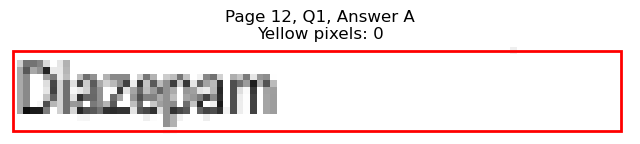

Page 12, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=103.2, y1=121.3
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 95
Page 12, Q1, B: Yellow percentage: 0.0%


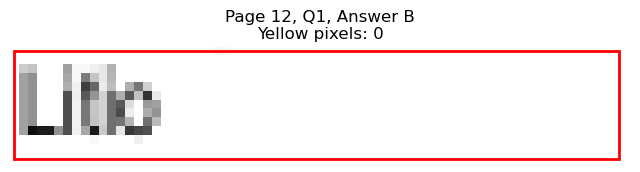

Page 12, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=118.5, y1=133.3
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 175
Page 12, Q1, C: Yellow percentage: 0.0%


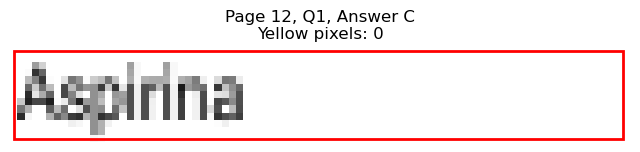

Page 12, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=375.9, y1=109.2
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 220
Page 12, Q1, D: Yellow percentage: 0.0%


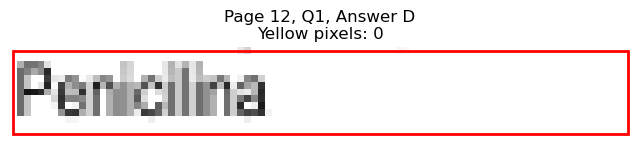

Page 12, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=399.9, y1=121.3
Page 12, Q1, E: Yellow pixels: 1099
Page 12, Q1, E: Total non-white pixels: 1482
Page 12, Q1, E: Yellow percentage: 74.2%


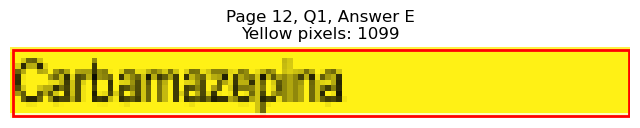


Page 12, Q1 - Selected Answer: E (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=128.1, y1=169.4
Page 12, Q2, A: Yellow pixels: 1040
Page 12, Q2, A: Total non-white pixels: 1235
Page 12, Q2, A: Yellow percentage: 84.2%


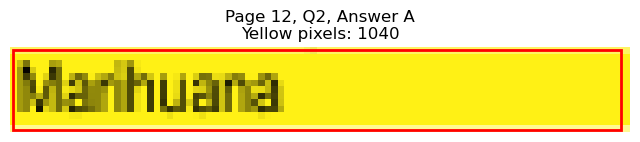

Page 12, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=119.4, y1=181.5
Page 12, Q2, B: Yellow pixels: 86
Page 12, Q2, B: Total non-white pixels: 251
Page 12, Q2, B: Yellow percentage: 34.3%


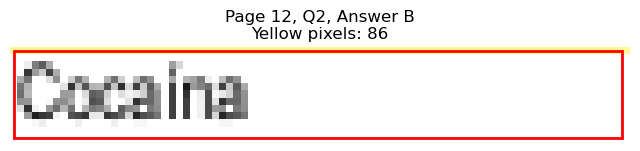

Page 12, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=128.5, y1=193.5
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 237
Page 12, Q2, C: Yellow percentage: 0.0%


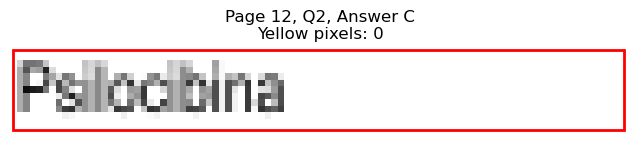

Page 12, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=375.4, y1=169.4
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 200
Page 12, Q2, D: Yellow percentage: 0.0%


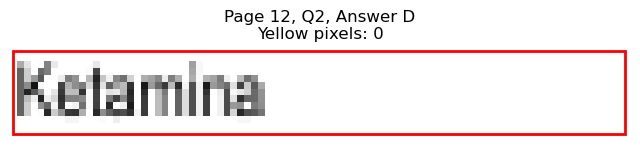

Page 12, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=384.6, y1=181.5
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 258
Page 12, Q2, E: Yellow percentage: 0.0%


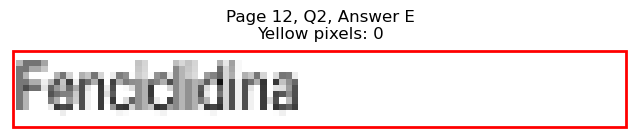


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=141.5, y1=253.8
Page 12, Q3, A: Yellow pixels: 1073
Page 12, Q3, A: Total non-white pixels: 1404
Page 12, Q3, A: Yellow percentage: 76.4%


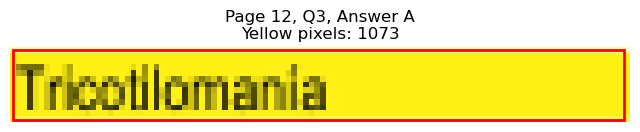

Page 12, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=140.5, y1=265.8
Page 12, Q3, B: Yellow pixels: 107
Page 12, Q3, B: Total non-white pixels: 390
Page 12, Q3, B: Yellow percentage: 27.4%


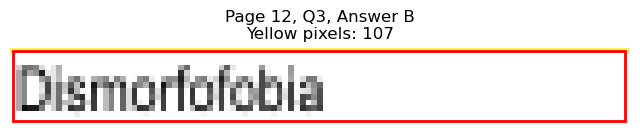

Page 12, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=121.3, y1=277.9
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 184
Page 12, Q3, C: Yellow percentage: 0.0%


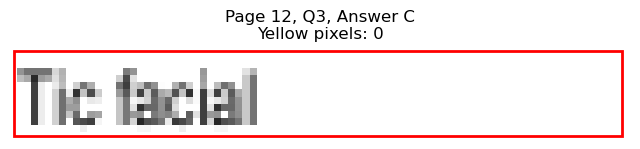

Page 12, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=426.7, y1=253.8
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 492
Page 12, Q3, D: Yellow percentage: 0.0%


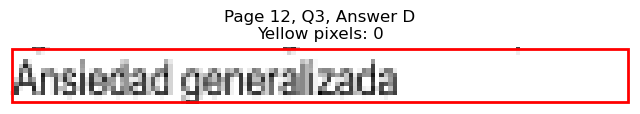

Page 12, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=385.0, y1=265.8
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 247
Page 12, Q3, E: Yellow percentage: 0.0%


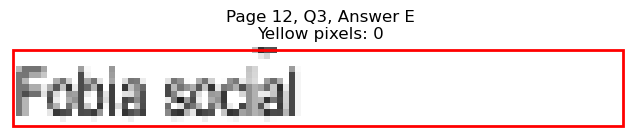


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=133.8, y1=326.0
Page 12, Q4, A: Yellow pixels: 980
Page 12, Q4, A: Total non-white pixels: 1400
Page 12, Q4, A: Yellow percentage: 70.0%


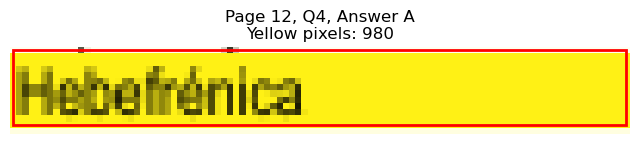

Page 12, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=126.7, y1=338.2
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 301
Page 12, Q4, B: Yellow percentage: 0.0%


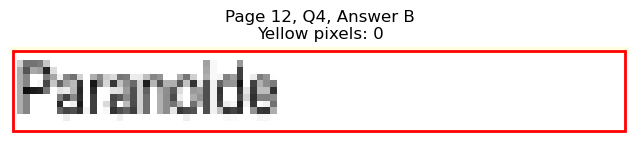

Page 12, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=134.3, y1=350.2
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 253
Page 12, Q4, C: Yellow percentage: 0.0%


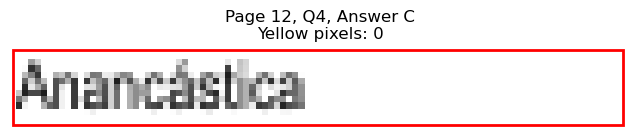

Page 12, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=383.6, y1=326.0
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 247
Page 12, Q4, D: Yellow percentage: 0.0%


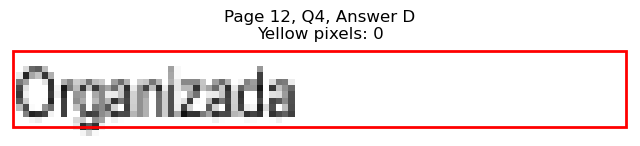

Page 12, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=380.2, y1=338.2
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 244
Page 12, Q4, E: Yellow percentage: 0.0%


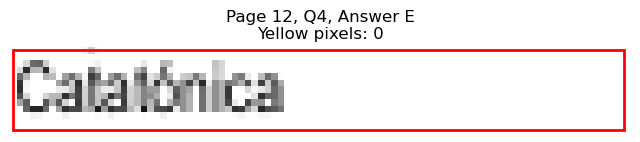


Page 12, Q4 - Selected Answer: A (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=231.9, y1=410.4
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 700
Page 12, Q5, A: Yellow percentage: 0.0%


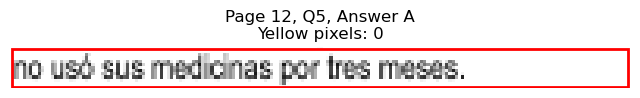

Page 12, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=256.9, y1=422.5
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 843
Page 12, Q5, B: Yellow percentage: 0.0%


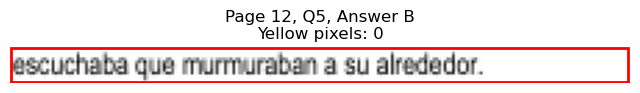

Page 12, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=264.1, y1=434.5
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 900
Page 12, Q5, C: Yellow percentage: 0.0%


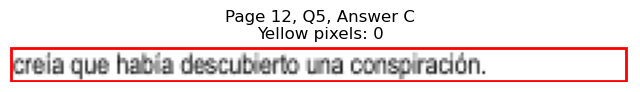

Page 12, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=524.0, y1=410.4
Page 12, Q5, D: Yellow pixels: 1740
Page 12, Q5, D: Total non-white pixels: 2470
Page 12, Q5, D: Yellow percentage: 70.4%


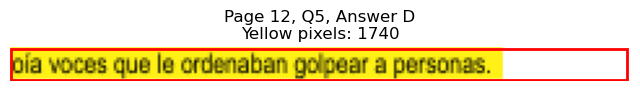

Page 12, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=506.6, y1=422.5
Page 12, Q5, E: Yellow pixels: 190
Page 12, Q5, E: Total non-white pixels: 1025
Page 12, Q5, E: Yellow percentage: 18.5%


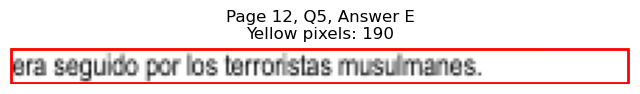


Page 12, Q5 - Selected Answer: D (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=172.1, y1=494.8
Page 12, Q6, A: Yellow pixels: 1311
Page 12, Q6, A: Total non-white pixels: 1807
Page 12, Q6, A: Yellow percentage: 72.6%


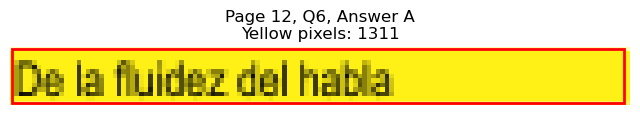

Page 12, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=147.3, y1=506.8
Page 12, Q6, B: Yellow pixels: 114
Page 12, Q6, B: Total non-white pixels: 434
Page 12, Q6, B: Yellow percentage: 26.3%


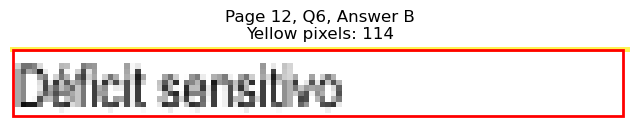

Page 12, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=187.0, y1=518.9
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 486
Page 12, Q6, C: Yellow percentage: 0.0%


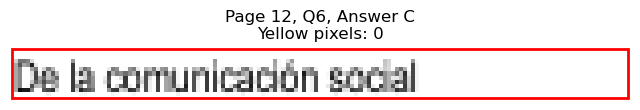

Page 12, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=415.2, y1=494.8
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 407
Page 12, Q6, D: Yellow percentage: 0.0%


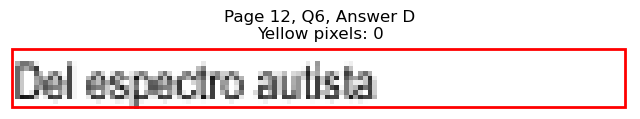

Page 12, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=450.1, y1=506.8
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 619
Page 12, Q6, E: Yellow percentage: 0.0%


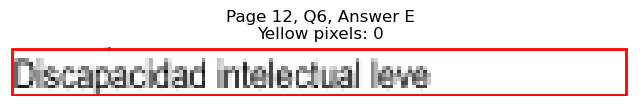


Page 12, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de15 años, estudiante de secundaria, ha ...
1   ¿Cuál de las siguientes alternativas contiene ...
2   Julia de 33 años, secretaria de un estudio jur...
3   Gianinna de 45 años, profesional medianamente ...
4   Mujer de 87 años, usuaria de aspirina, con dia...
..                                                ...
95  ¿Cuál de las siguientes sustancias está relaci...
96  Mujer de 14 años, mayor de 5 hermanos, que des...
97  ¿Cuál es la forma de esquizofrenia que se cara...
98  Varón de 30 años, con antecedentes de esquizof...
99  Niño de 5 años, con repetición de sonidos y sí...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                              Anorexia nervosa   
1   Asociación, ansiedad, ambivalencia y alogia   
2                                Psicosis aguda   
3                          Bipolar fase maniaca   
4                                      Arritmia   
..                                          ...   
95                                    Marihuana   
96                               Tricotilomanía   
97                                  Hebefrénica   
98         no usó sus medicinas por tres meses.   
99                      De la fluidez del habla   

                                    option_B  \
0                                   Facticio   
1    Alogia, anhedonia, apatía y afectividad   
2                                  Celotipia   
3                   Personalidad histriónica   
4                                   Sangrado   
..                                       ...   
95                                   Cocaína   
96                             Dismorfofobia   
97                                 Paranoide   
98  escuchaba que murmuraban a su alrededor.   
99                         Déficit sensitivo   

                                           option_C  \
0                                          Obesidad   
1   Asociación, afectividad, autismo y ambivalencia   
2                                         Catatonía   
3                            Pseudología fantástica   
4                                       Somnolencia   
..                                              ...   
95                                      Psilocibina   
96                                       Tic facial   
97                                      Anancástica   
98    creía que había descubierto una conspiración.   
99                        De la comunicación social   

                                          option_D  \
0                                        Depresión   
1        Autismo, abreacción, angustia y anhedonia   
2                                       Erotomanía   
3                         Complejo de inferioridad   
4                                    Irritabilidad   
..                                             ...   
95                                        Ketamina   
96                           Ansiedad generalizada   
97                                      Organizada   
98  oía voces que le ordenaban golpear a personas.   
99                            Del espectro autista   

                                       option_E  
0                                  De atracones  
1     Abuso, apatía, abstinencia y ambivalencia  
2                                  Grandiosidad  
3                       Personalidad narcisista  
4                                      Ataraxia  
..                                          ...  
95                                 Fenciclidina  
96                                 Fobia social  
97                                   Catatónica  
98  era seguido por los terroristas musulmanes.  
99                Discapacidad intelectual leve  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Varón de15 años, estudiante de secundaria, ha ...   
1   ¿Cuál de las siguientes alternativas contiene ...   
2   Julia de 33 años, secretaria de un estudio jur...   
3   Gianinna de 45 años, profesional medianamente ...   
4   Mujer de 87 años, usuaria de aspirina, con dia...   
..                                                ...   
95  ¿Cuál de las siguientes sustancias está relaci...   
96  Mujer de 14 años, mayor de 5 hermanos, que des...   
97  ¿Cuál es la forma de esquizofrenia que se cara...   
98  Varón de 30 años, con antecedentes de esquizof...   
99  Niño de 5 años, con repetición de sonidos y sí...   

                                       option_A  \
0                              Anorexia nervosa   
1   Asociación, ansiedad, ambivalencia y alogia   
2                                Psicosis aguda   
3                          Bipolar fase maniaca   
4                                      Arritmia   
..                                          ...   
95                                    Marihuana   
96                               Tricotilomanía   
97                                  Hebefrénica   
98         no usó sus medicinas por tres meses.   
99                      De la fluidez del habla   

                                    option_B  \
0                                   Facticio   
1    Alogia, anhedonia, apatía y afectividad   
2                                  Celotipia   
3                   Personalidad histriónica   
4                                   Sangrado   
..                                       ...   
95                                   Cocaína   
96                             Dismorfofobia   
97                                 Paranoide   
98  escuchaba que murmuraban a su alrededor.   
99                         Déficit sensitivo   

                                           option_C  \
0                                          Obesidad   
1   Asociación, afectividad, autismo y ambivalencia   
2                                         Catatonía   
3                            Pseudología fantástica   
4                                       Somnolencia   
..                                              ...   
95                                      Psilocibina   
96                                       Tic facial   
97                                      Anancástica   
98    creía que había descubierto una conspiración.   
99                        De la comunicación social   

                                          option_D  \
0                                        Depresión   
1        Autismo, abreacción, angustia y anhedonia   
2                                       Erotomanía   
3                         Complejo de inferioridad   
4                                    Irritabilidad   
..                                             ...   
95                                        Ketamina   
96                           Ansiedad generalizada   
97                                      Organizada   
98  oía voces que le ordenaban golpear a personas.   
99                            Del espectro autista   

                                       option_E correct_answer  
0                                  De atracones              E  
1     Abuso, apatía, abstinencia y ambivalencia              C  
2                                  Grandiosidad              D  
3                       Personalidad narcisista              E  
4                                      Ataraxia              B  
..                                          ...            ...  
95                                 Fenciclidina              A  
96                                 Fobia social              A  
97                                   Catatónica              A  
98  era seguido por los terroristas musulmanes.              D  
99                Discapacidad intelectual leve              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PSIQUIATRIA.csv
